In [1]:
# General libraries
import os
import math
import re
import itertools
import warnings
import random

# Data handling and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import geopandas as gpd
from IPython.display import display, HTML

# Dimensionality reduction
import umap

# Feature Selection
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, RepeatedKFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Data Preparation and Scoring
from sklearn import preprocessing as pp
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import reciprocal
from sklearn.metrics import make_scorer, accuracy_score, mean_absolute_error, mean_squared_error, r2_score
from matplotlib.colors import LogNorm

# Machine Learning Algorithms
import tensorflow as tf
from tensorflow import keras
from keras import optimizers, models, layers, regularizers
from keras.optimizers import Nadam, Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l1, l2
import xgboost as xgb
from xgboost import XGBRegressor
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# Custom imports
from zoomin.data.constants import (countries_dict, open_stack_list_NUTS3, open_stack_list_LAU, data_col_dic,
                                    data_col_dic_hist, data_columns, osm_network_length, osm_stations_quantity,
                                    freight_traffic_flow, vehicle_stock_DE, vehicle_stock_buildings_PL,
                                    economic_metric, socio_metric, demographic_metric, pixeles_quantity,
                                    industry_electricity_demand, industry_fuel_demand, industry_generation_capacity,
                                    industry_plants_quantity, environmental, railway_length, residential_energy_demand)
from zoomin.data.osmtags import networks_tags_dict, stations_tags_dict, name_tags_dict

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Tensorflow configuration to use the GPU

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # If there are GPUs available, print a message and enable memory growth
  print("GPU is available")
  for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
else:
  print("GPU is not available")

print(tf.config.list_physical_devices('GPU'))

GPU is available
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Pre-Processing
### Loading the data for EU

In [3]:
# Loading the data
cwd = os.getcwd()
DATA_PATH = os.path.join(cwd, '..', '..', '..', 'data', 'input')
RAW_DATA_PATH = os.path.join(DATA_PATH, 'raw')
PROCESSED_DATA_PATH = os.path.join(DATA_PATH, 'processed')
def read_Data():
        data_path = os.path.join(
        PROCESSED_DATA_PATH,
        'ancilliary_data',
        'processed'
        "data.csv")
        data_eu_raw = pd.read_csv(data_path)
        return data_eu_raw

data_eu_raw = read_Data()

### Filter Data for each country and creates its own csv file and saves it in the same directory

In [4]:
# define the directory where the data will be saved
output_dir = os.path.join(cwd, '..', '..', '..', 'data', 'output', 'spatial_disaggregation', 'data_raw')

# loop over the dictionary and filter the data and save it to the corresponding directory
for country, abbreviation in countries_dict.items():
    # filter the data based on the country abbreviation
    data_filtered = data_eu_raw[data_eu_raw["NUTS0_region_code"] == abbreviation]

    # create the directory for the country if it does not exist
    country_dir = os.path.join(output_dir, abbreviation)
    if not os.path.exists(country_dir):
        os.makedirs(country_dir)

    # save the filtered data to a CSV file in the country directory
    file_path_destination = os.path.join(country_dir, f"data_{abbreviation}_raw.csv")
    if not os.path.exists(file_path_destination):
        data_filtered.to_csv(file_path_destination, index=False)

### Loading data for specific country to use for testing

In [5]:
# territorial_unit = input(
#         'Please enter a character from: LAU, NUTS3, NUTS2, NUTS1, NUTS0, Europe')
territorial_unit = 'NUTS3'
region = input('Please load data for specific country: EU, BE, EL, LT, PT, BG, ES, LU, RO, CZ, FR, HU, SI, DK, HR, MT, SK, DE, IT, NL, FI, EE, CY, AT, SE, IE, LV, PL')
def read_Data(region):
        data_path = os.path.join(cwd, '..', '..', '..', 'data', 'output', 'spatial_disaggregation', 'data_raw', f'{region}',
        f"data_{region}_raw.csv")
        data_region_raw = pd.read_csv(data_path)
        return data_region_raw

data_region_raw = read_Data(region)

### CHeck Nan - Uniqueness - Distributions

#### Nan and fill

Drop columns with more than 100 Nan values and replace the remaining Nan values with the mean of each column

In [6]:
def check_nan_values_in_integers_float_columns_drop_and_replace_nan_with_mean(df):
    num_numeric_cols = 0
    num_dropped_cols = 0

    for col in df.columns:
        if df[col].dtype == 'float64' or df[col].dtype == 'float32' or df[col].dtype == 'int64' or df[col].dtype =='int32':
            num_numeric_cols += 1
            num_nans = df[col].isnull().sum()

            if num_nans > 0:
                print("The number of rows with NaN values in column", col, "is", num_nans)
                proportion_nans = num_nans / len(df[col])

                if proportion_nans > 0.1:
                    df.drop(col, axis=1, inplace=True)
                    num_dropped_cols += 1
                    print(f"Dropped column '{col}' due to more than 10% missing values.")
                else:
                    mean_val = df[col].mean()
                    df[col] = df[col].fillna(mean_val)
            else:
                print('The number of rows with NaN values in column', col, 'is', 0)
        else:
            print(f"Skipping non-numeric column '{col}'")

    percentage_dropped_cols = (num_dropped_cols / num_numeric_cols) * 100 if num_numeric_cols != 0 else 0

    print('----------------------------------------------------------------------------')
    print(df.select_dtypes(include=['float64', 'float32']).isnull().sum())
    print('----------------------------------------------------------------------------')

    print(f"\nTotal number of numeric columns: {num_numeric_cols}")
    print(f"Total number of dropped columns: {num_dropped_cols}")
    print(f"Percentage of dropped columns: {percentage_dropped_cols:.2f}%")

    return df

def convert_float_to_int(df):
    for column in df.columns:
        if df[column].dtype == 'float64' or df[column].dtype == 'float32':
            if not df[column].isnull().any():
                df[column] = df[column].astype(int)
    return df

def filter_rows_with_nan_in_string_cols(df):
    """
    Filter rows that contain NaN values in string/object columns of a pandas DataFrame.

    Parameters:
        df (pandas.DataFrame): The DataFrame to filter.

    Returns:
        pandas.DataFrame: The filtered DataFrame containing only unique rows with NaN values in string/object columns.
    """
    string_columns = df.select_dtypes(include=['object']).columns
    filtered_rows = pd.DataFrame()
    for col in string_columns:
        if df[col].isna().any():
            nan_rows = df[df[col].isna()]
            filtered_rows = pd.concat([filtered_rows, nan_rows]).drop_duplicates()

    return filtered_rows

##### EU

In [7]:
df_eu = check_nan_values_in_integers_float_columns_drop_and_replace_nan_with_mean(data_eu_raw)
df_eu = convert_float_to_int(df_eu)
filter_rows_with_nan_in_string_cols(df_eu)
df_eu['EU_region_code'] = df_eu['EU_region_code'].fillna('EU')
df_eu['NUTS0_region_code'] = df_eu['NUTS0_region_code'].fillna('EL')
df_eu['NUTS1_region_code'] = df_eu['NUTS1_region_code'].fillna('EL')
df_eu['NUTS2_region_code'] = df_eu['NUTS2_region_code'].fillna('EL')
filter_rows_with_nan_in_string_cols(df_eu)

Skipping non-numeric column 'EU_region_code'
Skipping non-numeric column 'NUTS0_region_code'
Skipping non-numeric column 'NUTS1_region_code'
Skipping non-numeric column 'NUTS2_region_code'
Skipping non-numeric column 'NUTS3_region_code'
The number of rows with NaN values in column deaths_value is 15
The number of rows with NaN values in column electricity demand of chemical industries_value is 0
The number of rows with NaN values in column electricity demand of iron and steel industries_value is 0
The number of rows with NaN values in column electricity demand of non-ferrous metal industries_value is 0
The number of rows with NaN values in column electricity demand of non-metallic mineral industries_value is 0
The number of rows with NaN values in column electricity demand of paper and printing industries_value is 0
The number of rows with NaN values in column electricity demand of refineries_value is 0
The number of rows with NaN values in column employment in nace sector G-I_value is

Empty DataFrame
Columns: []
Index: []

##### Country

In [8]:
df_country = check_nan_values_in_integers_float_columns_drop_and_replace_nan_with_mean(data_region_raw)
df_country = convert_float_to_int(df_country)
filter_rows_with_nan_in_string_cols(df_country)

Skipping non-numeric column 'EU_region_code'
Skipping non-numeric column 'NUTS0_region_code'
Skipping non-numeric column 'NUTS1_region_code'
Skipping non-numeric column 'NUTS2_region_code'
Skipping non-numeric column 'NUTS3_region_code'
The number of rows with NaN values in column deaths_value is 0
The number of rows with NaN values in column electricity demand of chemical industries_value is 0
The number of rows with NaN values in column electricity demand of iron and steel industries_value is 0
The number of rows with NaN values in column electricity demand of non-ferrous metal industries_value is 0
The number of rows with NaN values in column electricity demand of non-metallic mineral industries_value is 0
The number of rows with NaN values in column electricity demand of paper and printing industries_value is 0
The number of rows with NaN values in column electricity demand of refineries_value is 0
The number of rows with NaN values in column employment in nace sector G-I_value is 

Empty DataFrame
Columns: []
Index: []

### Exclude features with a % threshold of zero values per country.

#### EU

In [9]:
def remove_high_zero_features(df, threshold=0.8):
    """
    Removes features with a high percentage of zero values and returns the remaining dataframe
    """
    num_features = len(df.columns[5:])
    zeros_percentage = (df == 0).mean()

    # Calculate percentage of features with specific percentages of zero values
    all_zero = round((zeros_percentage == 1).sum() / num_features * 100, 2)
    at_least_95 = round((zeros_percentage >= 0.95).sum() / num_features * 100, 2)
    at_least_90 = round((zeros_percentage >= 0.9).sum() / num_features * 100, 2)
    at_least_80 = round((zeros_percentage >= 0.8).sum() / num_features * 100, 2)
    at_least_70 = round((zeros_percentage >= 0.7).sum() / num_features * 100, 2)
    at_least_60 = round((zeros_percentage >= 0.6).sum() / num_features * 100, 2)
    at_least_50 = round((zeros_percentage >= 0.5).sum() / num_features * 100, 2)

    print(f"Number of initial features: {num_features}")
    print(f"Percentage of columns with all zero values: {all_zero:.2f}%")
    print(f"Percentage of columns with at least 95% zero values: {at_least_95:.2f}%")
    print(f"Percentage of columns with at least 90% zero values: {at_least_90:.2f}%")
    print(f"Percentage of columns with at least 80% zero values: {at_least_80:.2f}%")
    print(f"Percentage of columns with at least 70% zero values: {at_least_70:.2f}%")
    print(f"Percentage of columns with at least 60% zero values: {at_least_60:.2f}%")
    print(f"Percentage of columns with at least 50% zero values: {at_least_50:.2f}%")

    # Remove features with high percentage of zero values
    to_remove = zeros_percentage[zeros_percentage >= threshold].index
    df = df.drop(to_remove, axis=1)
    num_features_after = len(df.columns[5:])

    print(f"Percentage of features removed due to high percentage of zeros: {100 * (1 - num_features_after/num_features):.2f}%")
    print(f"Number of remaining features: {num_features_after}")

    return df

df_eu = remove_high_zero_features(df_eu)

Number of initial features: 161
Percentage of columns with all zero values: 13.04%
Percentage of columns with at least 95% zero values: 31.68%
Percentage of columns with at least 90% zero values: 37.89%
Percentage of columns with at least 80% zero values: 49.07%
Percentage of columns with at least 70% zero values: 56.52%
Percentage of columns with at least 60% zero values: 60.87%
Percentage of columns with at least 50% zero values: 64.60%
Percentage of features removed due to high percentage of zeros: 49.07%
Number of remaining features: 82


#### Country

In [10]:
def remove_high_zero_features_country(df, threshold=0.5):
    """
    Removes features with a high percentage of zero values and returns the remaining dataframe
    """
    num_features = len(df.columns)
    zeros_percentage = (df == 0).mean()

    # Calculate percentage of features with specific percentages of zero values
    all_zero = round((zeros_percentage == 1).sum() / num_features * 100, 2)
    at_least_95 = round((zeros_percentage >= 0.95).sum() / num_features * 100, 2)
    at_least_90 = round((zeros_percentage >= 0.9).sum() / num_features * 100, 2)
    at_least_80 = round((zeros_percentage >= 0.8).sum() / num_features * 100, 2)
    at_least_70 = round((zeros_percentage >= 0.7).sum() / num_features * 100, 2)
    at_least_60 = round((zeros_percentage >= 0.6).sum() / num_features * 100, 2)
    at_least_50 = round((zeros_percentage >= 0.5).sum() / num_features * 100, 2)

    print(f"Number of initial features: {num_features}")
    print(f"Percentage of columns with all zero values: {all_zero:.2f}%")
    print(f"Percentage of columns with at least 95% zero values: {at_least_95:.2f}%")
    print(f"Percentage of columns with at least 90% zero values: {at_least_90:.2f}%")
    print(f"Percentage of columns with at least 80% zero values: {at_least_80:.2f}%")
    print(f"Percentage of columns with at least 70% zero values: {at_least_70:.2f}%")
    print(f"Percentage of columns with at least 60% zero values: {at_least_60:.2f}%")
    print(f"Percentage of columns with at least 50% zero values: {at_least_50:.2f}%")

    # Remove features with high percentage of zero values
    to_remove = zeros_percentage[zeros_percentage >= threshold].index
    df = df.drop(to_remove, axis=1)
    num_features_after = len(df.columns)

    print(f"Percentage of features removed due to high percentage of zeros: {100 * (1 - num_features_after/num_features):.2f}%")
    print(f"Number of remaining features: {num_features_after}")

    return df

df_country = remove_high_zero_features_country(df_country, threshold=0.5)

Number of initial features: 175
Percentage of columns with all zero values: 28.00%
Percentage of columns with at least 95% zero values: 46.86%
Percentage of columns with at least 90% zero values: 54.29%
Percentage of columns with at least 80% zero values: 58.86%
Percentage of columns with at least 70% zero values: 63.43%
Percentage of columns with at least 60% zero values: 63.43%
Percentage of columns with at least 50% zero values: 65.14%
Percentage of features removed due to high percentage of zeros: 65.14%
Number of remaining features: 61


## Sandardization

### Add geometry column to the dataset

In [11]:
# Add geographical coordinates for each location to dataset
def setup_polygons(territorial_unit, region):
    """Get polygons geodataframe for each country at a territoriial unit."""
    polygon_shp_path = os.path.join(
        PROCESSED_DATA_PATH, "shapefiles", f"{territorial_unit}.shp"
    )
    polygon_gdf = gpd.read_file(polygon_shp_path)
    polygon_gdf.drop(
        [
            col
            for col in polygon_gdf.columns
            if "geometry" not in col and "code" not in col
        ],
        axis=1,
        inplace=True,
    )
    polygon_gdf.drop(
        [col for col in polygon_gdf.columns if col.startswith("prnt")],
        axis=1,
        inplace=True,
    )
    polygon_gdf.rename(columns={"code": "NUTS3_region_code"}, inplace=True)
    polygon_gdf.reset_index(drop=True, inplace=True)
    return polygon_gdf


def add_centroids_to_df(df, polygon_gdf):
    """Add centroid coordinates to the DataFrame."""
    # Merge the input DataFrame with the polygon_gdf based on NUTS3_region_code
    df_merged = df.merge(polygon_gdf, on='NUTS3_region_code', how='left')

    # Convert the merged DataFrame into a GeoDataFrame
    df_merged = gpd.GeoDataFrame(df_merged, geometry=df_merged['geometry'])

    # Calculate the centroids of the polygons or multipolygons
    centroids = df_merged['geometry'].centroid

    # Add centroid_x and centroid_y columns to the DataFrame
    df_merged['centroid_x'] = centroids.x
    df_merged['centroid_y'] = centroids.y

    # Drop the 'geometry' column
    df_merged.drop(columns=['geometry'], inplace=True)

    return df_merged


def replace_nan_with_mean(df):
    for col in df.columns:
        if df[col].dtype in ['float64', 'float32', 'int64', 'int32']:
            mean_val = df[col].mean()
            df[col] = df[col].fillna(mean_val)
            print(f"Replaced NaN values in column '{col}' with mean value {mean_val:.4f}")

    return df

polygon_gdf = setup_polygons(territorial_unit, region)

# Add centroid_x and centroid_y to df_eu
df_eu_with_centroids = add_centroids_to_df(df_eu, polygon_gdf)

# Impute NaN values in df_eu_with_centroids
df_eu = replace_nan_with_mean(df_eu_with_centroids)

Replaced NaN values in column 'deaths_value' with mean value 3996.5453
Replaced NaN values in column 'electricity demand of non-metallic mineral industries_value' with mean value 33.4342
Replaced NaN values in column 'electricity demand of paper and printing industries_value' with mean value 350.6821
Replaced NaN values in column 'employment in nace sector G-I_value' with mean value 28821.1137
Replaced NaN values in column 'Distance_from_origin_region_to_E_road' with mean value 23.3359
Replaced NaN values in column 'Distance_within_E_road' with mean value 1394.3752
Replaced NaN values in column 'Distance_from_E_road_to_destination_region' with mean value 105.0906
Replaced NaN values in column 'Total_distance' with mean value 1523.3299
Replaced NaN values in column 'Traffic_flow_trucks_2010' with mean value 425.3265
Replaced NaN values in column 'Traffic_flow_trucks_2019' with mean value 472.2897
Replaced NaN values in column 'Traffic_flow_trucks_2030' with mean value 562.4402
Replaced 

In [12]:
df_eu.shape

(1170, 89)

In [13]:
def preprocess_scale_and_split_data(df, region, target_var):
    # Scale the dataframe
    def scale_dataframe(df):
        df = df.iloc[:, 5:].astype(int).copy()
        scaler = StandardScaler().fit(df)
        X_scaled = scaler.transform(df)
        df_scaled = pd.DataFrame(X_scaled, columns=df.columns)
        return df_scaled

    # Add a small value to the samples that are zero
    def add_small_value(df):
        zero_inds = np.where(df == 0.0)
        for i in range(len(zero_inds[0])):
            df.iloc[zero_inds[0][i], zero_inds[1][i]] = 0.01
        return df

    # Scale and add small values
    df_scaled = scale_dataframe(df)
    df_scaled = add_small_value(df_scaled)

    # Concatenate the first five columns
    first_five_columns_df = df.iloc[:, :5].copy()
    df_scaled = pd.concat([first_five_columns_df, df_scaled], axis=1)

    # Preprocess the data
    df_train = df_scaled.loc[df_scaled['NUTS0_region_code'] != region, :].copy()
    df_test = df_scaled.loc[df_scaled['NUTS0_region_code'] == region, :].copy()

    y_train = df_train[target_var]
    y_test = df_test[target_var]
    X_train = df_train.drop(target_var, axis=1)
    X_test = df_test.drop(target_var, axis=1)

    return X_train, y_train, X_test, y_test

agg_var_to_disagg = 'charging_stations_value'
# agg_var_to_disagg = input(
#         'Please enter a character from: charging_stations_value, fuel_stations_value, bus_stations_value, airport_stations_value, helicopter_station_value, train_station_value')
X_train, y_train, X_test, y_test = preprocess_scale_and_split_data(df_eu, region, agg_var_to_disagg)

## Feature Engineering

### Interaction features

In [14]:
def feature_engineering(data, new_features, columns_to_drop):
    for feature, components in new_features.items():
        data.loc[:, feature] = data[components[0]] / data[components[1]]
    data.drop(columns_to_drop, axis=1, inplace=True)
    return data

new_features = {
    'deaths_per_person': ('deaths_value', 'population_value'),
    'total_area_value_times_population_value': ('total area_value', 'population_value')
}

# columns_to_drop = ['deaths_value', 'total area_value']
columns_to_drop = []
# columns_to_keep_fixed = ['population_value', 'gross value added_value', 'total number of businesses_value', 'deaths_per_person', 'total_area_value_per_population_value']
columns_to_keep_fixed = ['population_value', 'gross value added_value', 'total number of businesses_value', 'deaths_value', 'total area_value', 'bicycle_stations_value', ]



# X_train = feature_engineering(X_train, new_features, columns_to_drop)
# X_test = feature_engineering(X_test, new_features, columns_to_drop)


## Dimensionality reduction

Common numerical features: ['Traffic_flow_tons_2010', 'population_value', 'number of pixels with natural grasslands_value', 'number of pixels with dump sites_value', 'number of pixels with mixed forest_value', 'charging_stations_value', 'Distance_from_origin_region_to_E_road', 'number of pixels with water bodies_value', 'Traffic_flow_trucks_2030', 'number of pixels with complex cultivation patterns_value', 'gross domestic product_value', 'number of pixels with broad-leaved forest_value', 'Traffic_flow_trucks_2019', 'bicycle_stations_value', 'number of pixels with industrial or commercial units_value', 'Traffic_flow_trucks_2010', 'number of pixels with pastures_value', 'number of pixels with mineral extraction sites_value', 'railway length (with power source - overhead electrified)_value', 'number of pixels with airports_value', 'total area_value', 'airport_stations_value', 'number of pixels with sport and leisure facilities_value', 'Distance_from_E_road_to_destination_region', 'Distanc

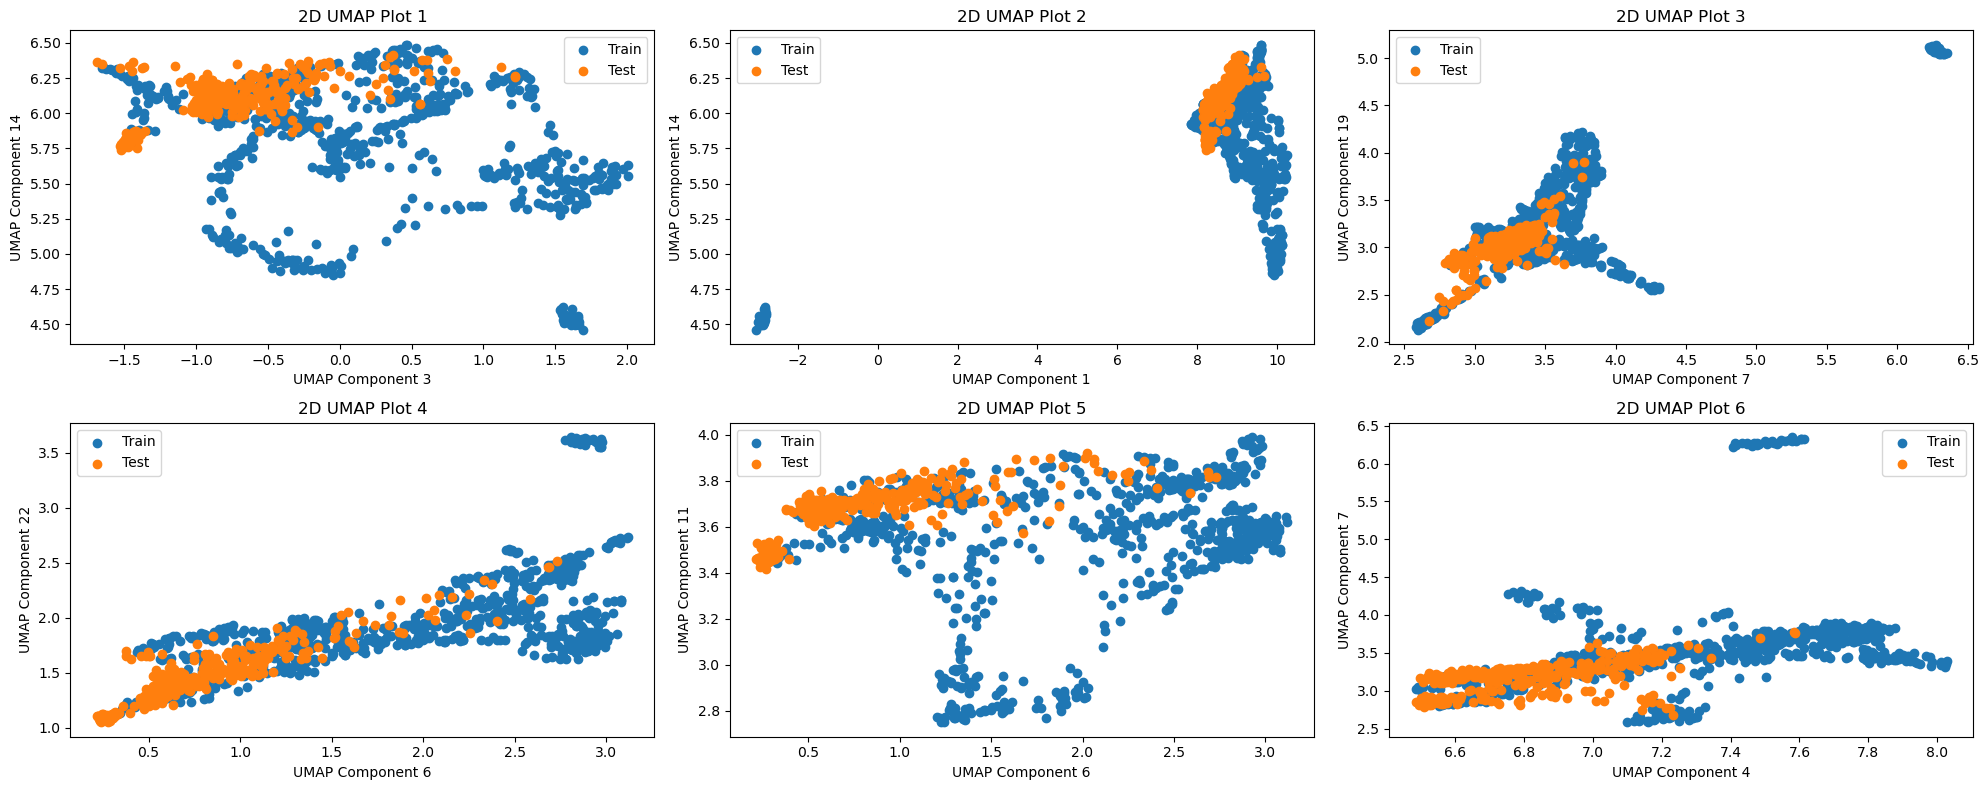

Shape of the reduced train data: (769, 25)
Shape of the reduced test data: (401, 25)
Shape of the train data: (769, 73)
Shape of the test data: (401, 73)


In [15]:
def perform_multiple_random_2d_umap_plots_and_dimensionality_reduction(X_train, y_train, X_test, y_test, columns_to_keep, n_components=30, random_state=42, plot_combinations=6):
    # 1. Apply UMAP
    reducer = umap.UMAP(n_components=n_components, random_state=random_state)
    reduced_data_train = reducer.fit_transform(X_train)
    reduced_data_test = reducer.transform(X_test)

    # 2. Plot the 2D scatter plots for random component combinations
    component_indices = range(n_components)
    combinations = list(itertools.combinations(component_indices, 2))
    random.seed(random_state)
    selected_combinations = random.sample(combinations, plot_combinations)

    # Set the layout for subplots
    rows, cols = 2, 3
    fig, axes = plt.subplots(rows, cols, figsize=(20, 8))

    for idx, (c1, c2) in enumerate(selected_combinations):
        row = idx // cols
        col = idx % cols
        ax = axes[row, col]
        ax.scatter(reduced_data_train[:, c1], reduced_data_train[:, c2], label='Train')
        ax.scatter(reduced_data_test[:, c1], reduced_data_test[:, c2], label='Test')
        ax.set_xlabel(f'UMAP Component {c1 + 1}')
        ax.set_ylabel(f'UMAP Component {c2 + 1}')
        ax.set_title(f'2D UMAP Plot {idx + 1}')
        ax.legend()

    plt.tight_layout()
    plt.show()

    # 3. Print the shape of the reduced data
    print(f"Shape of the reduced train data: {reduced_data_train.shape}")
    print(f"Shape of the reduced test data: {reduced_data_test.shape}")

    # 4. Create DataFrames for the reduced data
    reduced_train_df = pd.DataFrame(reduced_data_train, columns=[f'UMAP{i + 1}' for i in range(n_components)], index=X_train.index)
    reduced_test_df = pd.DataFrame(reduced_data_test, columns=[f'UMAP{i + 1}' for i in range(n_components)], index=X_test.index)

    # 5. Concatenate the reduced data with the target variable and specified columns
    reduced_train_df = pd.concat([X_train[columns_to_keep], y_train, reduced_train_df], axis=1)
    reduced_test_df = pd.concat([X_test[columns_to_keep], y_test, reduced_test_df], axis=1)

    return reduced_train_df, reduced_test_df


def intersperse_columns(columns_to_keep_fixed, common_numerical_features, target_feature):

    # Initialize an empty list called combined_columns.
    combined_columns = []

    # Create a new list called common_numerical_features that contains all the elements from the original common_numerical_features list, except for the target_feature.
    # This is done using a list comprehension.
    common_numerical_features = [col for col in common_numerical_features if col != target_feature]

    # Create an empty set called added_features to keep track of the features added to combined_columns.
    added_features = set()

    # Iterate through the elements of columns_to_keep_fixed using a for loop. For each element (referred to as fixed_col):
    for fixed_col in columns_to_keep_fixed:
        # Append fixed_col to the combined_columns list and add it to the added_features set if it's not already in the set.
        if fixed_col not in added_features:
            combined_columns.append(fixed_col)
            added_features.add(fixed_col)
        # Check if there are still elements left in the common_numerical_features list. If so, pop the first element from the list and append it to combined_columns.
        while common_numerical_features:
            next_col = common_numerical_features.pop(0)
            if next_col not in added_features:
                combined_columns.append(next_col)
                added_features.add(next_col)
                break

    # Add any remaining common_numerical_features that are not already in added_features.
    for col in common_numerical_features:
        if col not in added_features:
            combined_columns.append(col)

    return combined_columns


def get_common_numerical_features(df1, df2, exclude_columns=None):
    if exclude_columns is None:
        exclude_columns = []

    # Get numerical columns for each dataframe
    num_cols_df1 = set(df1.select_dtypes(include=[np.number]).columns) - set(exclude_columns)
    num_cols_df2 = set(df2.select_dtypes(include=[np.number]).columns) - set(exclude_columns)

    # Find the common numerical columns
    common_numerical_cols = list(num_cols_df1.intersection(num_cols_df2))

    return common_numerical_cols

common_numerical_features = get_common_numerical_features(df_eu, df_country, exclude_columns=columns_to_drop)
print("Common numerical features:", common_numerical_features)

new_columns_to_keep = intersperse_columns(columns_to_keep_fixed, common_numerical_features, agg_var_to_disagg)

print("New columns to keep:", new_columns_to_keep)

n_components = 25
reduced_train_df, reduced_test_df = perform_multiple_random_2d_umap_plots_and_dimensionality_reduction(X_train[new_columns_to_keep], y_train, X_test[new_columns_to_keep], y_test, new_columns_to_keep, n_components=n_components, random_state=42, plot_combinations=6)

print(f"Shape of the train data: {reduced_train_df.shape}")
print(f"Shape of the test data: {reduced_test_df.shape}")

In [16]:
reduced_train_df.shape

(769, 73)

### Analysing the distribution and scale of the reduced features using descriptive statistics and box plots:

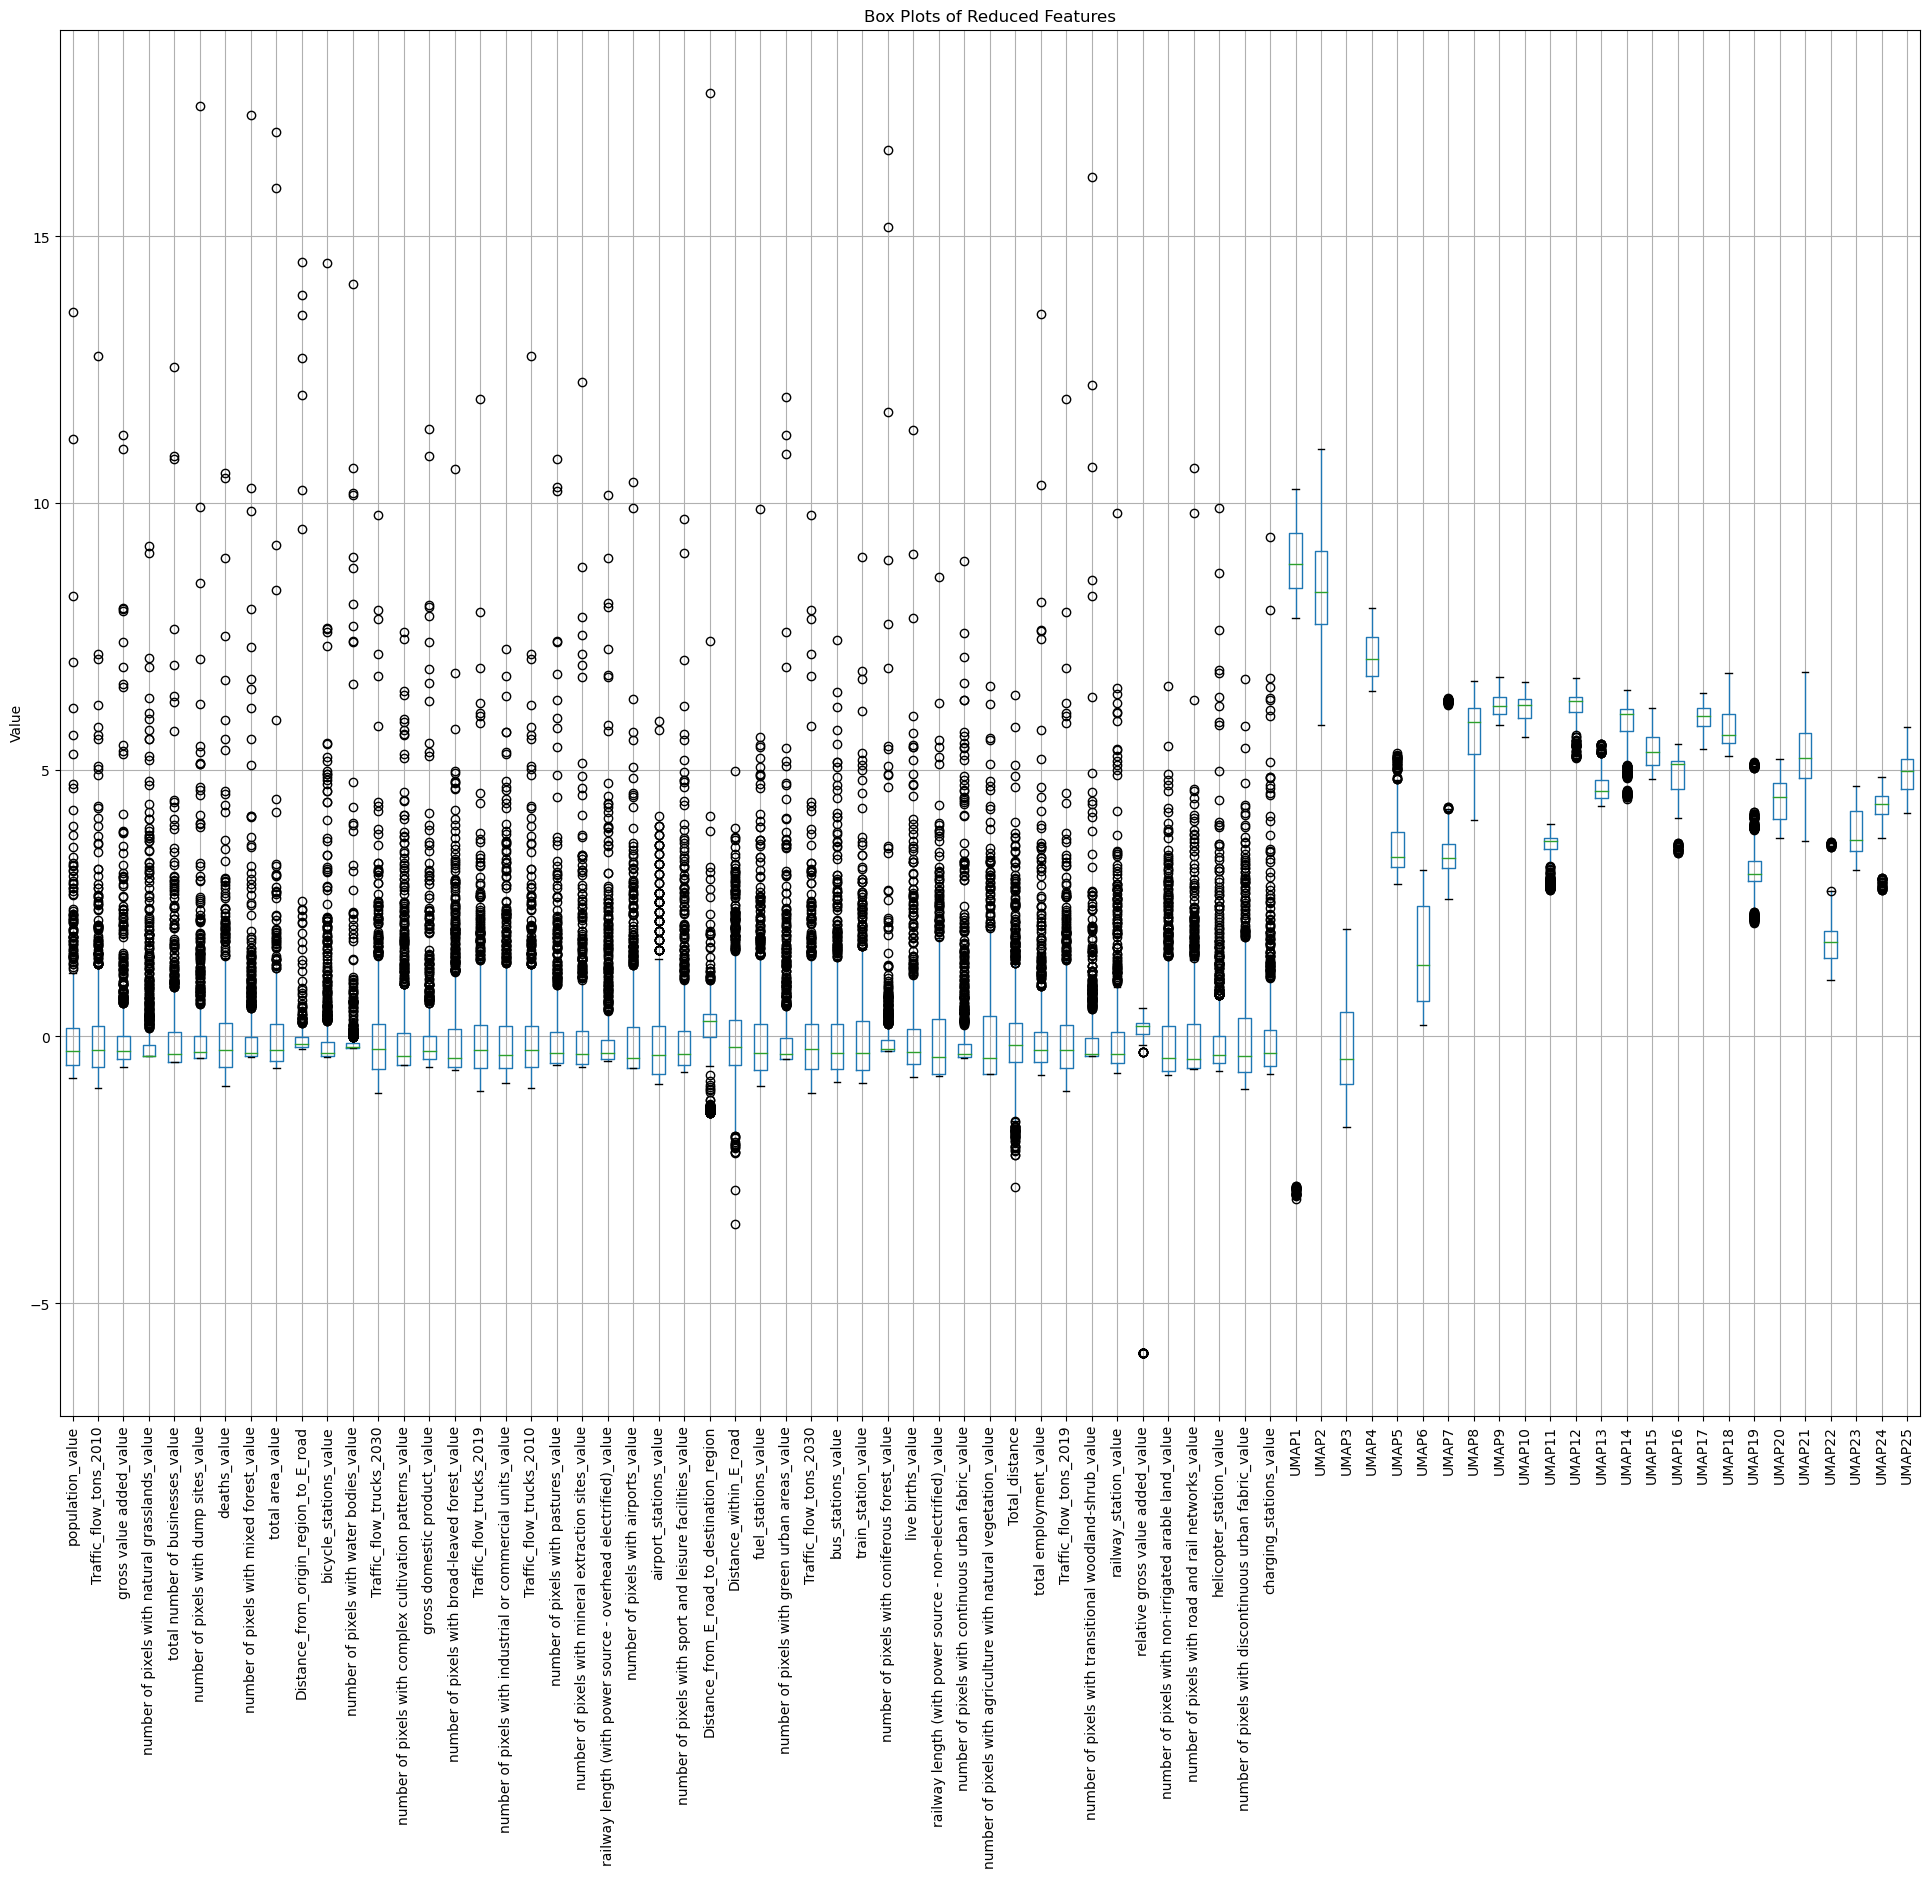

population_value  Traffic_flow_tons_2010  gross value added_value  \
0            -0.737458               -0.884397                -0.516610   
1            -0.475706               -0.444368                -0.306536   
2            -0.610286               -0.588985                -0.433735   
3            -0.289477                0.114561                -0.147775   
4            -0.260014                0.222439                -0.156777   
...                ...                     ...                      ...   
1165          0.621491               -0.075478                -0.093496   
1166          0.658195               -0.439525                -0.060292   
1167          0.559552               -0.485281                -0.183732   
1168          0.945669                0.677331                -0.152647   
1169          0.892789                0.798569                -0.043453   

      number of pixels with natural grasslands_value  \
0                                          -0.371131   
1                                          -0.299162   
2                                          -0.359652   
3                                          -0.110903   
4                                          -0.177962   
...                                              ...   
1165                                       -0.355273   
1166                                       -0.033648   
1167                                       -0.112905   
1168                                       -0.243707   
1169                                       -0.354929   

      total number of businesses_value  \
0                            -0.422980   
1                            -0.244557   
2                            -0.343771   
3                            -0.186943   
4                            -0.140835   
...                                ...   
1165                          1.018742   
1166                          1.223052   
1167                          0.685745   
1168                          1.154169   
1169                          0.769633   

      number of pixels with dump sites_value  deaths_value  \
0                                  -0.396489     -0.856020   
1                                  -0.396489     -0.557523   
2                                  -0.396489     -0.688070   
3                                  -0.396489     -0.384195   
4                                  -0.345058     -0.294719   
...                                      ...           ...   
1165                               -0.029616      0.868955   
1166                               -0.396489      0.648933   
1167                                0.697272      0.760655   
1168                               -0.396489      0.730341   
1169                                1.396731      0.841085   

      number of pixels with mixed forest_value  total area_value  \
0                                    -0.145426         -0.478605   
1                                    -0.334215         -0.296703   
2                                     0.048444         -0.350223   
3                                     0.566365         -0.035937   
4                                     0.812520         -0.033937   
...                                        ...               ...   
1165                                 -0.245343          0.462250   
1166                                  0.983775          0.539780   
1167                                  1.387972          0.980779   
1168                                  0.791534          0.900583   
1169                                  0.436156          0.530610   

      Distance_from_origin_region_to_E_road  ...    UMAP16    UMAP17  \
0                                  0.068950  ...  5.124921  6.384515   
1                                 -0.055208  ...  5.142988  6.007387   
2                                 -0.075900  ...  5.094271  6.121814   
3                                 -0.148326  ...  5.126549  5.838894   
4    

In [17]:
def analyze_reduced_data(train_df, test_df):
    """
    Calculate descriptive statistics and visualize distributions of reduced features using box plots.

    Args:
    train_df (pd.DataFrame): Reduced train dataset.
    test_df (pd.DataFrame): Reduced test dataset.

    Returns:
    None
    """
    # Combine the train and test datasets
    combined_reduced_df = pd.concat([reduced_train_df, reduced_test_df])
    # Sort the DataFrame by index
    combined_reduced_df  = combined_reduced_df.sort_index()

    # Calculate descriptive statistics
    statistics = combined_reduced_df.describe().transpose()
    # print(statistics)

    # Visualize distributions using box plots
    plt.figure(figsize=(24, 18))
    combined_reduced_df.boxplot()
    plt.xticks(rotation=90)
    plt.title('Box Plots of Reduced Features')
    plt.ylabel('Value')
    plt.show()

    return combined_reduced_df

analyze_reduced_data(reduced_train_df, reduced_test_df)

        We can see that the mean and standard deviation values for the initial features are near 0 and 1, respectively, which indicates that they have been standardized already. The UMAP components, however, show a different scale, with means ranging from 2.69 to 6.40 and standard deviations ranging from 0.14 to 0.34.

        Since the scales of the UMAP components are different from the initial features, it may be beneficial to standardize the UMAP components before clustering. 

#### Function to Standarize UMAP components

In [18]:
def standardize_umap_components(train_df, test_df):
    """
    Standardize UMAP components in train and test datasets.

    Args:
    train_df (pd.DataFrame): Reduced train dataset.
    test_df (pd.DataFrame): Reduced test dataset.

    Returns:
    (pd.DataFrame, pd.DataFrame): Scaled train and test datasets.
    """
    # Get UMAP feature columns
    umap_columns = [col for col in train_df.columns if col.startswith('UMAP')]

    # Initialize StandardScaler
    scaler = StandardScaler()

    # Scale UMAP components in train data
    train_df[umap_columns] = scaler.fit_transform(train_df[umap_columns])

    # Scale UMAP components in test data
    test_df[umap_columns] = scaler.transform(test_df[umap_columns])

    return train_df, test_df

reduced_train_df, reduced_test_df = standardize_umap_components(reduced_train_df, reduced_test_df)


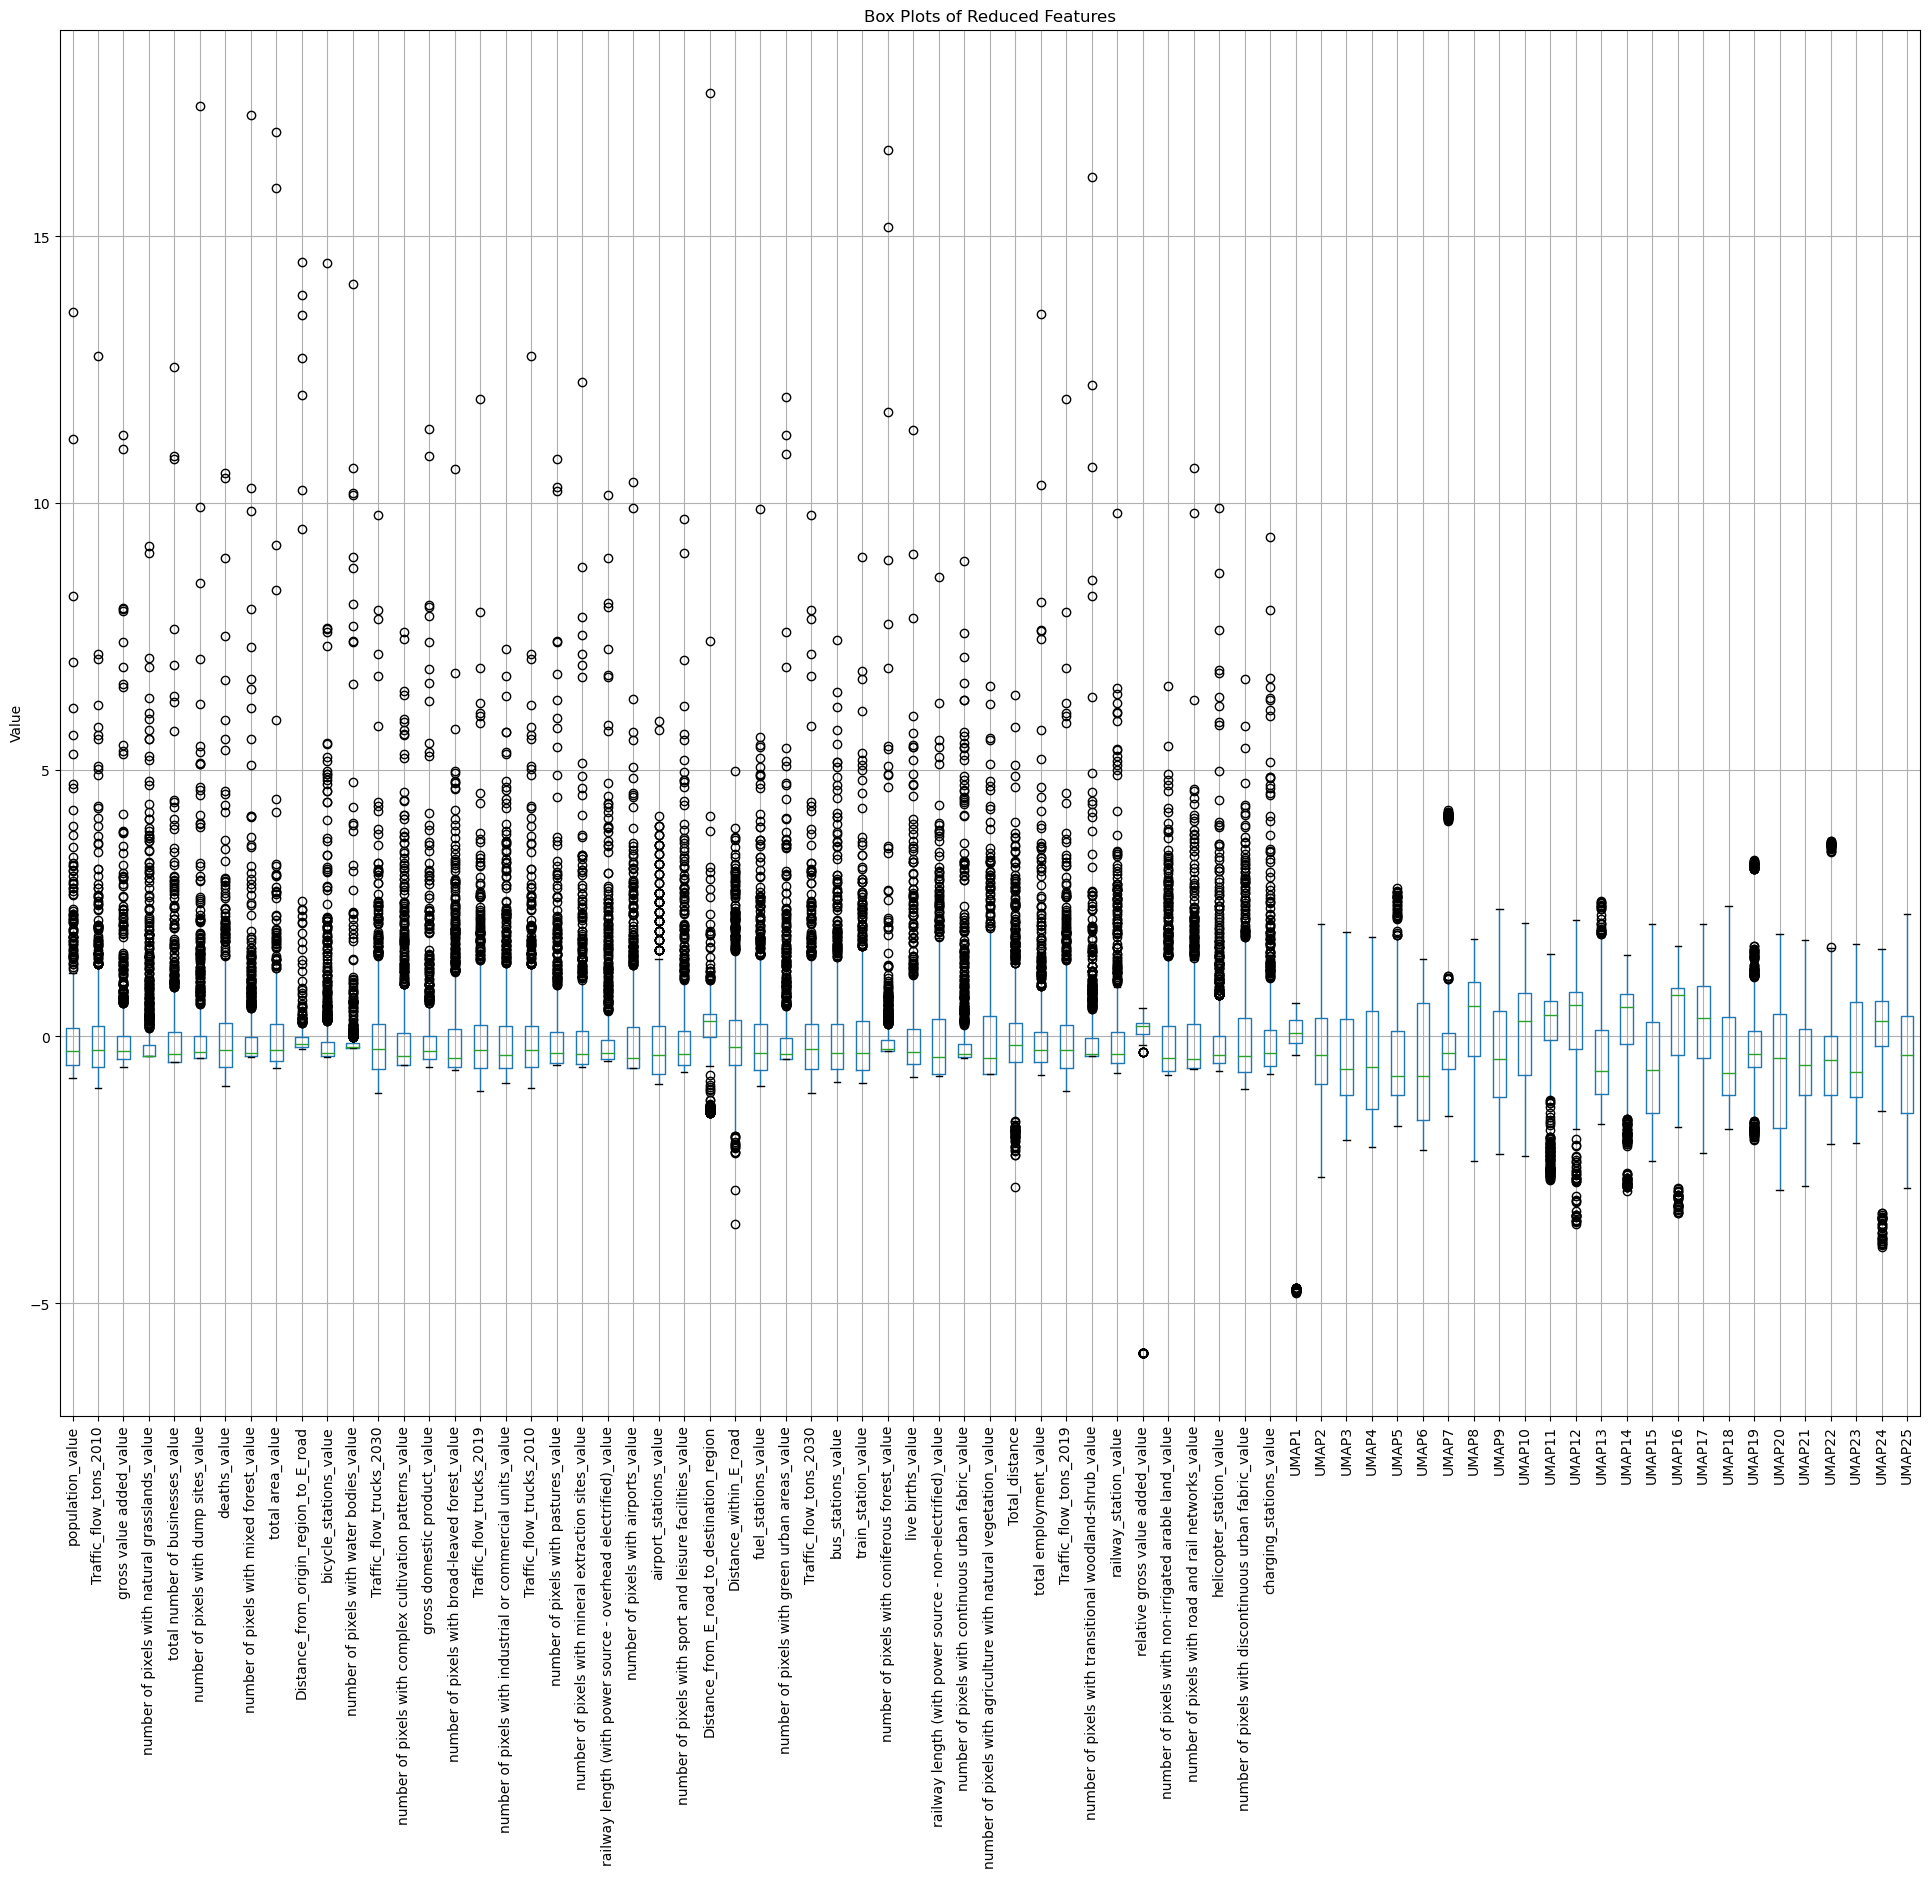

population_value  Traffic_flow_tons_2010  gross value added_value  \
0            -0.737458               -0.884397                -0.516610   
1            -0.475706               -0.444368                -0.306536   
2            -0.610286               -0.588985                -0.433735   
3            -0.289477                0.114561                -0.147775   
4            -0.260014                0.222439                -0.156777   
...                ...                     ...                      ...   
1165          0.621491               -0.075478                -0.093496   
1166          0.658195               -0.439525                -0.060292   
1167          0.559552               -0.485281                -0.183732   
1168          0.945669                0.677331                -0.152647   
1169          0.892789                0.798569                -0.043453   

      number of pixels with natural grasslands_value  \
0                                          -0.371131   
1                                          -0.299162   
2                                          -0.359652   
3                                          -0.110903   
4                                          -0.177962   
...                                              ...   
1165                                       -0.355273   
1166                                       -0.033648   
1167                                       -0.112905   
1168                                       -0.243707   
1169                                       -0.354929   

      total number of businesses_value  \
0                            -0.422980   
1                            -0.244557   
2                            -0.343771   
3                            -0.186943   
4                            -0.140835   
...                                ...   
1165                          1.018742   
1166                          1.223052   
1167                          0.685745   
1168                          1.154169   
1169                          0.769633   

      number of pixels with dump sites_value  deaths_value  \
0                                  -0.396489     -0.856020   
1                                  -0.396489     -0.557523   
2                                  -0.396489     -0.688070   
3                                  -0.396489     -0.384195   
4                                  -0.345058     -0.294719   
...                                      ...           ...   
1165                               -0.029616      0.868955   
1166                               -0.396489      0.648933   
1167                                0.697272      0.760655   
1168                               -0.396489      0.730341   
1169                                1.396731      0.841085   

      number of pixels with mixed forest_value  total area_value  \
0                                    -0.145426         -0.478605   
1                                    -0.334215         -0.296703   
2                                     0.048444         -0.350223   
3                                     0.566365         -0.035937   
4                                     0.812520         -0.033937   
...                                        ...               ...   
1165                                 -0.245343          0.462250   
1166                                  0.983775          0.539780   
1167                                  1.387972          0.980779   
1168                                  0.791534          0.900583   
1169                                  0.436156          0.530610   

      Distance_from_origin_region_to_E_road  ...    UMAP16    UMAP17  \
0                                  0.068950  ...  0.832255  1.883649   
1                                 -0.055208  ...  0.876826  0.333878   
2                                 -0.075900  ...  0.756641  0.804103   
3                                 -0.148326  ...  0.836270 -0.358530   
4    

In [19]:
analyze_reduced_data(reduced_train_df, reduced_test_df)

## Feature Selection

        This code includes feature selection methods such as correlation matrix, univariate feature selection (F-Regression and Mutual Information), Lasso (L1 Regularization), Ridge (L2 Regularization), and Random Forest Importance.

        The final step combines the selected features from different methods and calculates the cross-validation scores with all features and selected features. You can compare these scores to decide whether to use all features or only the selected ones.

Number of Highly correlated features selected by correlation_matrix:  0
Highly correlated features: []


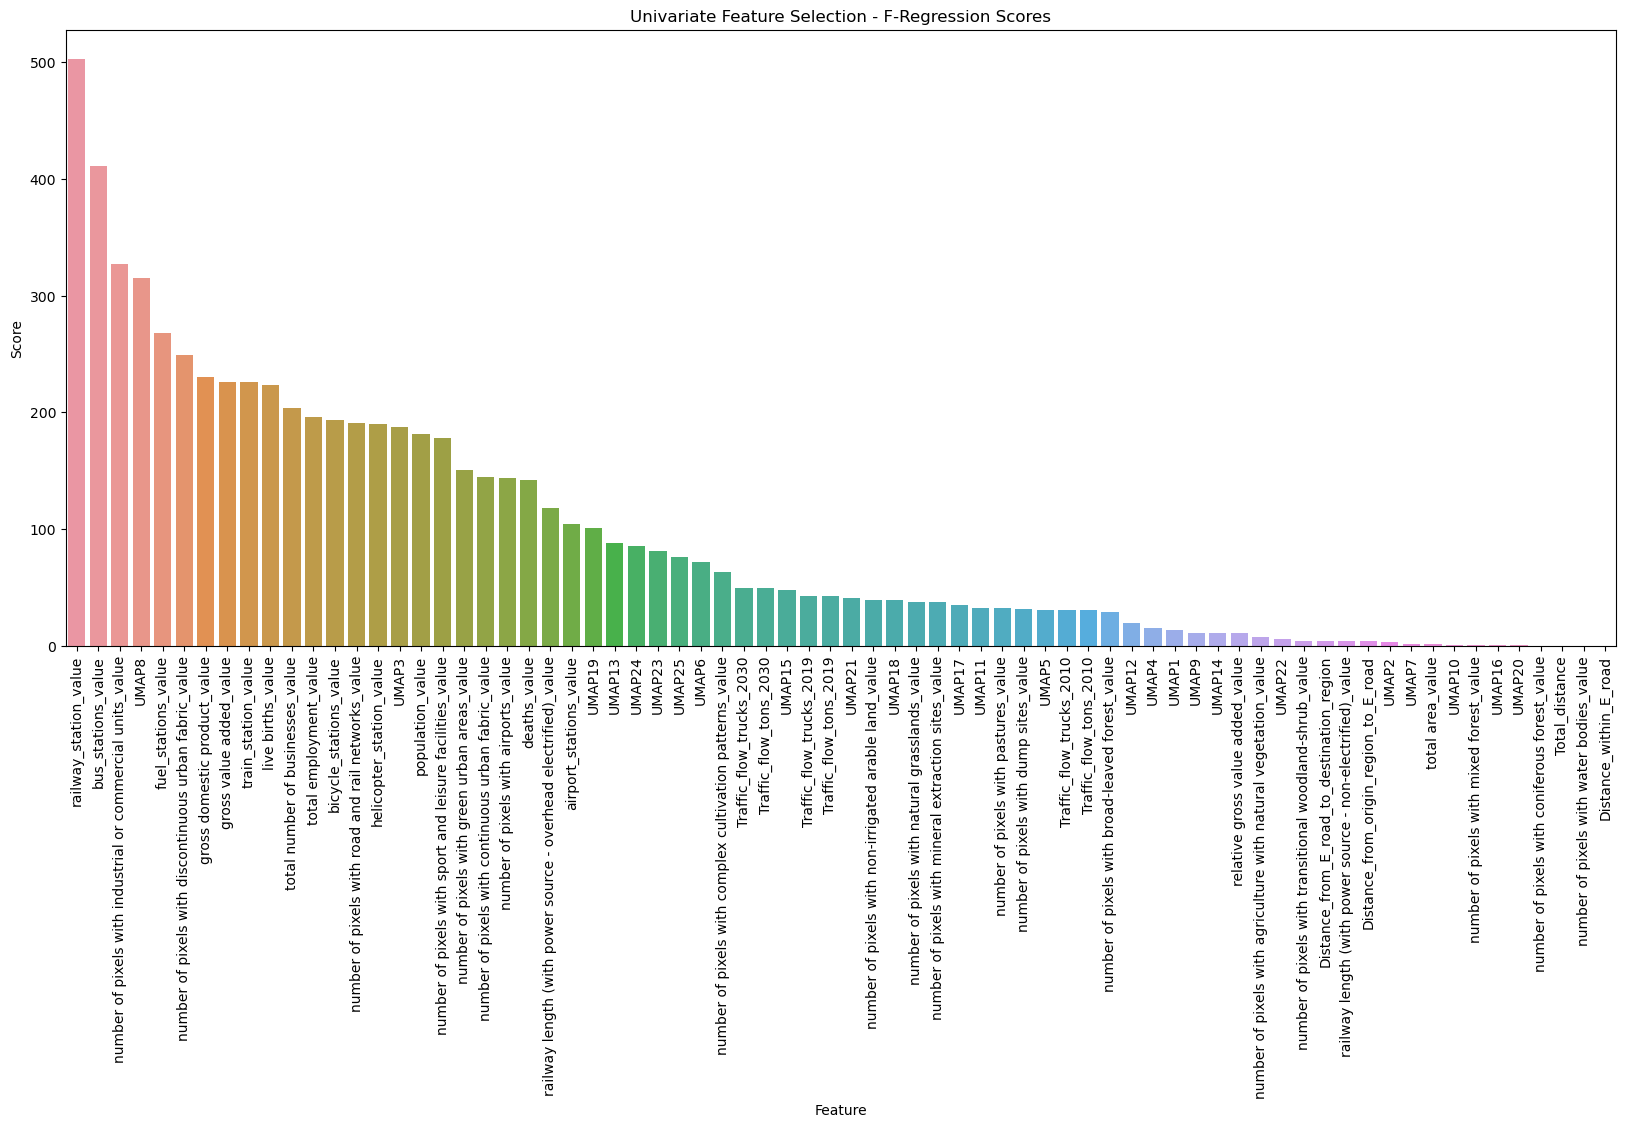

Number of selected k features based by univariate F-Regression:  3
Top k features based on F-Regression: ['railway_station_value', 'bus_stations_value', 'number of pixels with industrial or commercial units_value']


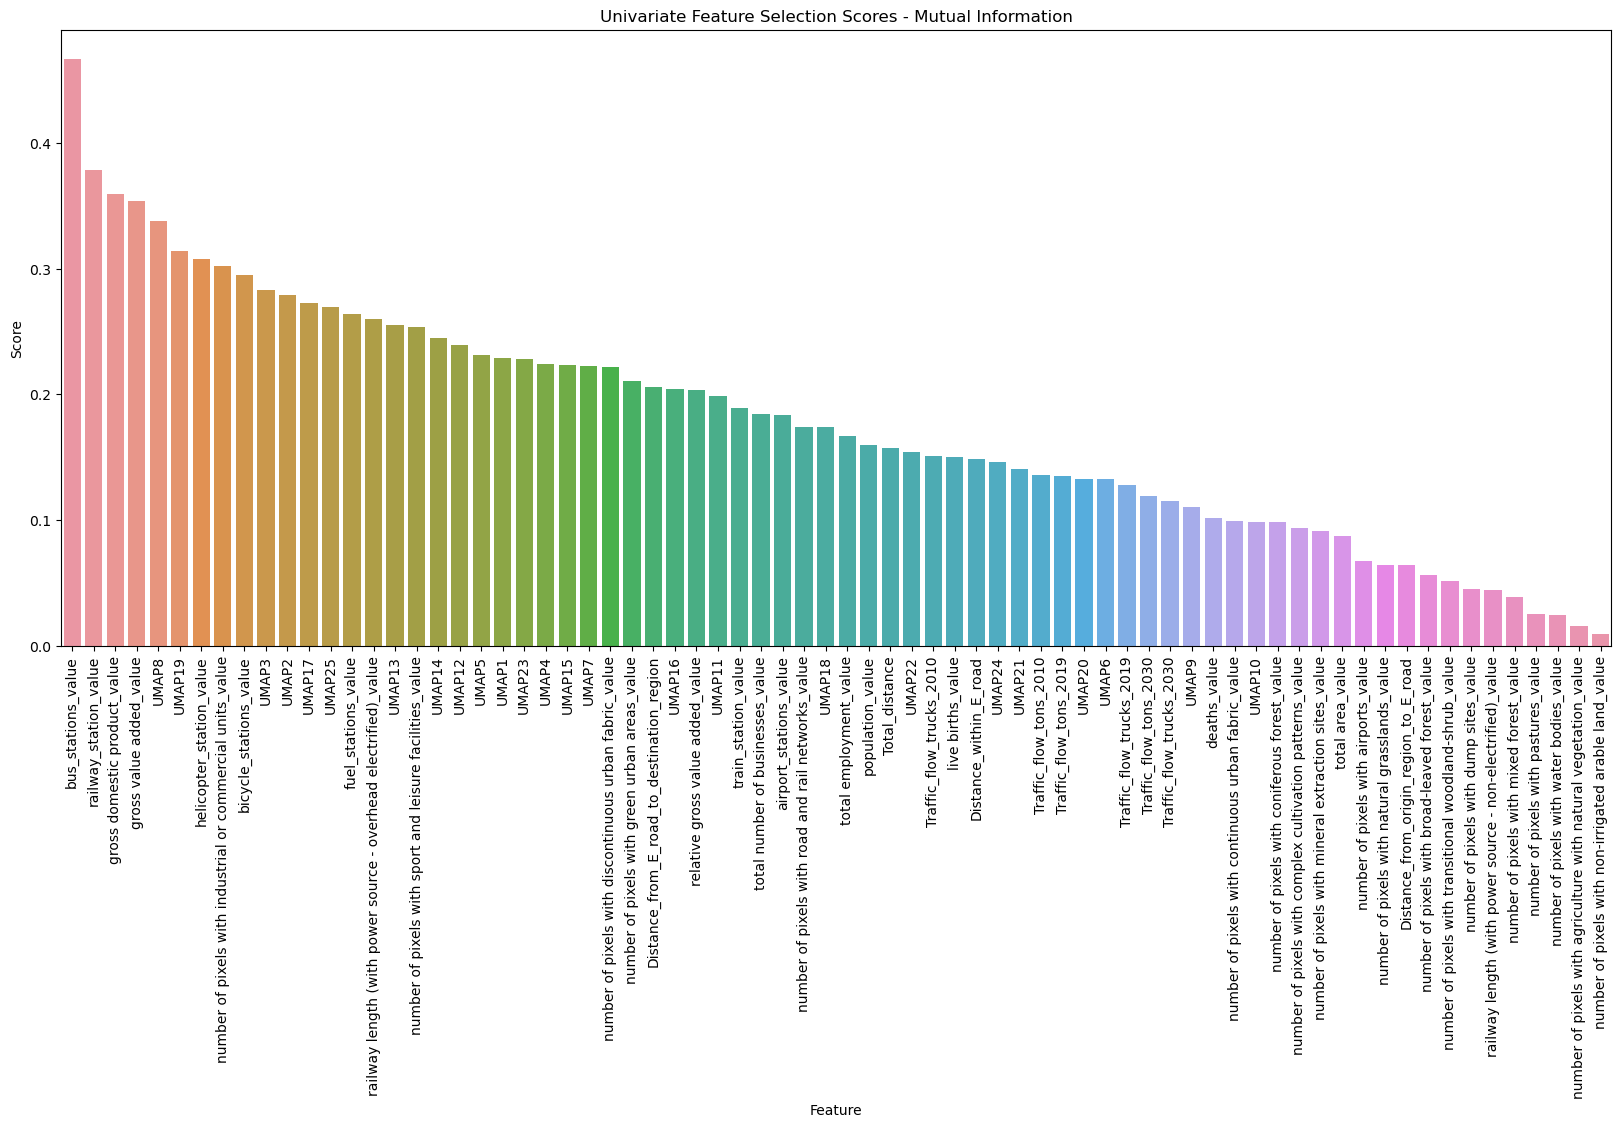

Number of selected k features based by univariate Mutual Information:  3
Top k features based on Mutual Information: ['bus_stations_value', 'railway_station_value', 'gross domestic product_value', 'gross value added_value', 'UMAP8', 'UMAP19', 'helicopter_station_value', 'number of pixels with industrial or commercial units_value']


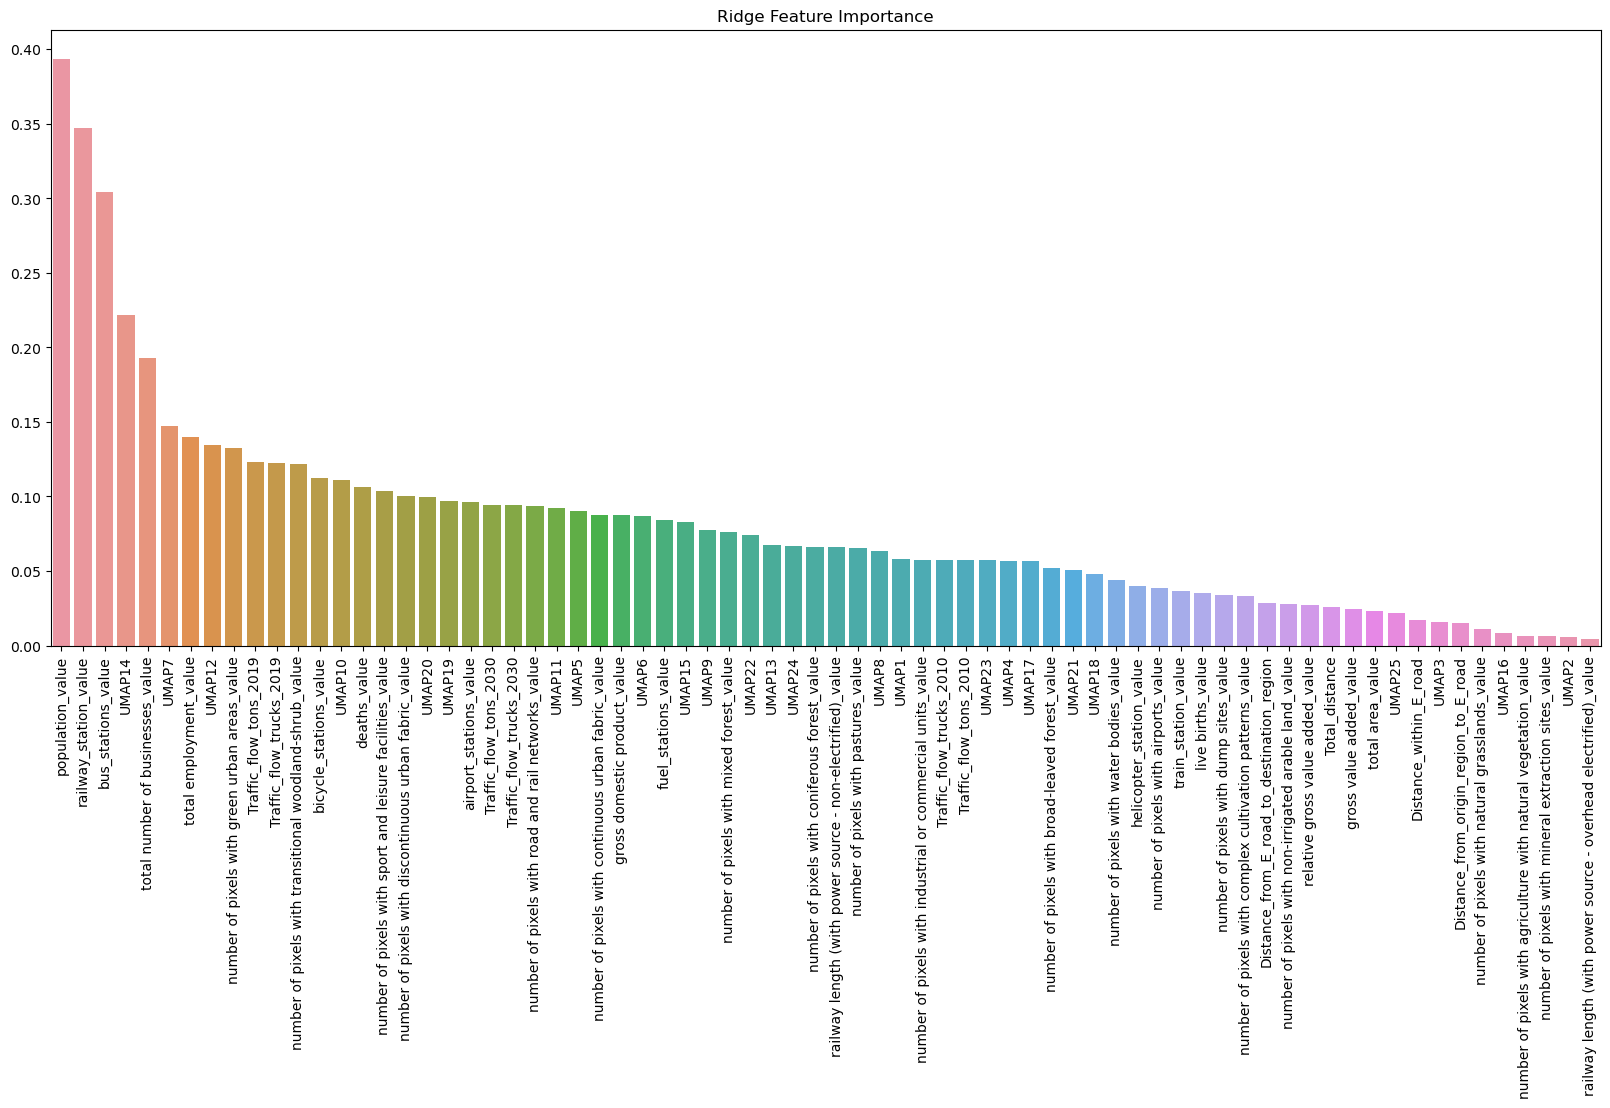

Number of selected features by Ridge (L2 Regularization): 6
Top 6 selected features based on Ridge (L2 Regularization) : 
['population_value', 'railway_station_value', 'bus_stations_value', 'UMAP14', 'total number of businesses_value', 'UMAP7']
--------------------------------------------------------------------------------------------------
selected_features_3:  ['population_value', 'railway_station_value', 'bus_stations_value', 'UMAP14', 'total number of businesses_value', 'UMAP7']
Number of selected features:  6


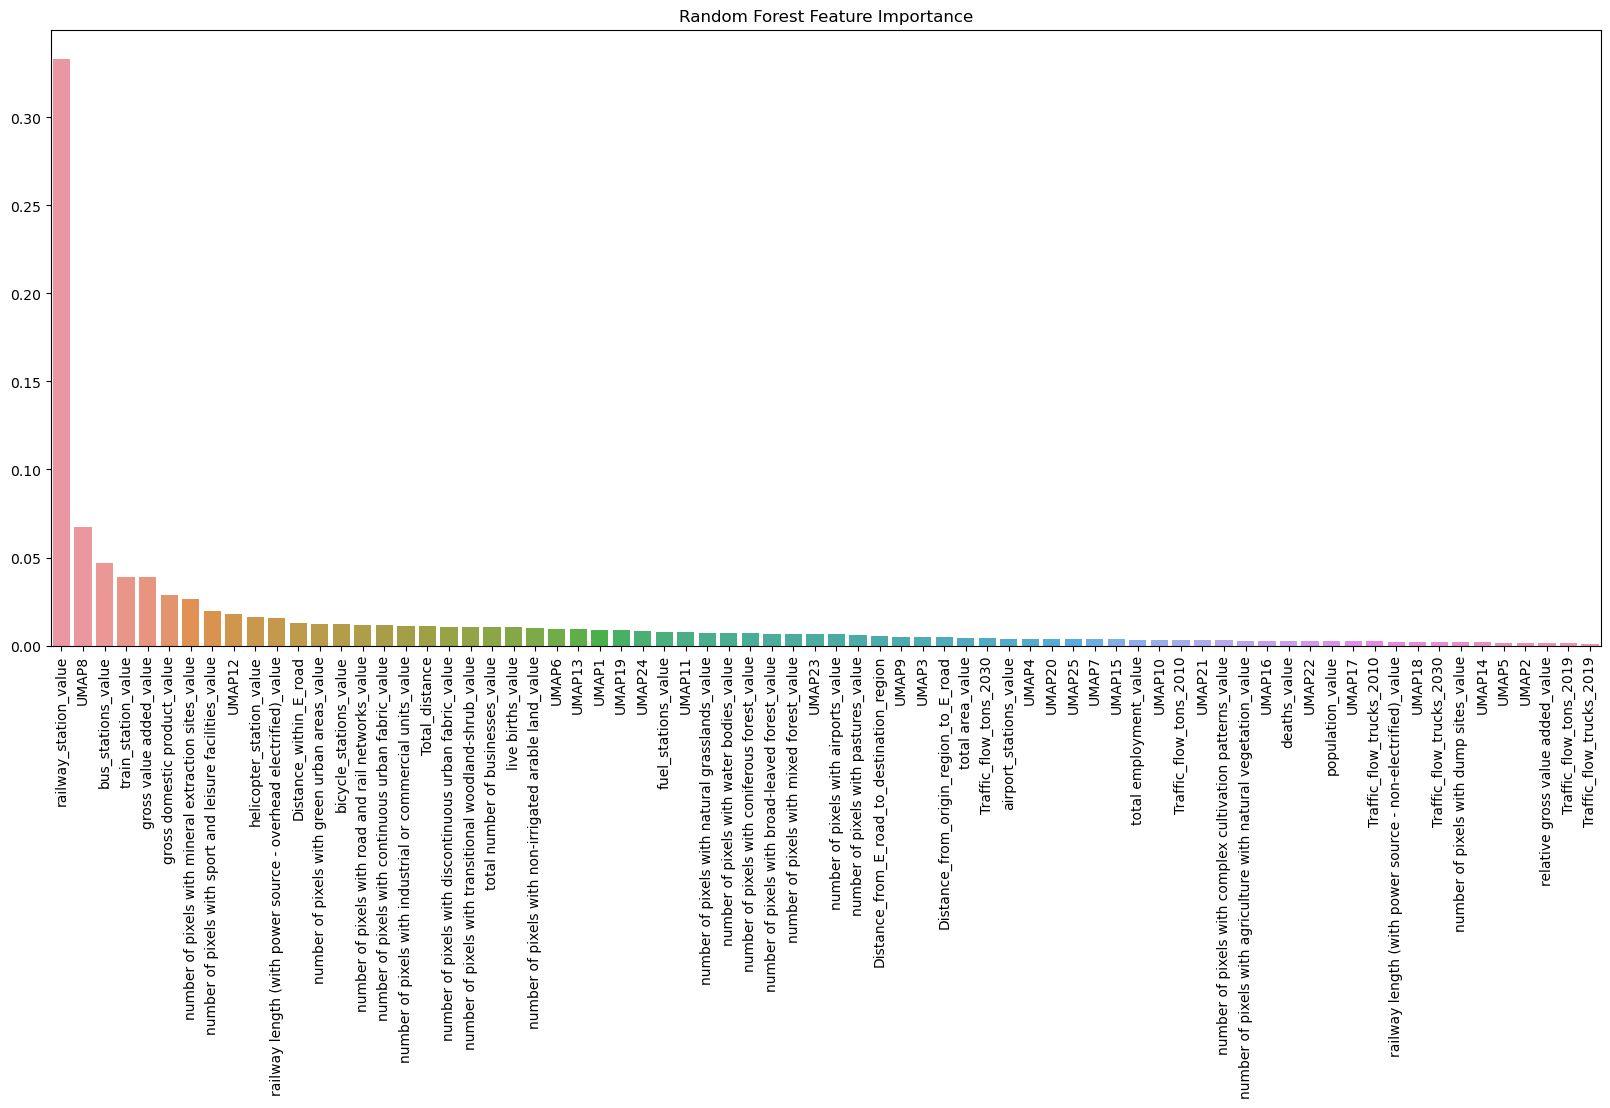

Number of selected features by Random Forest : 5
Top 5 features based on Random Forest : ['railway_station_value', 'UMAP8', 'bus_stations_value', 'train_station_value', 'gross value added_value']
--------------------------------------------------------------------------------------------------
selected_features:  ['UMAP19', 'railway_station_value', 'population_value', 'bus_stations_value', 'UMAP7', 'UMAP8', 'gross value added_value', 'train_station_value', 'number of pixels with industrial or commercial units_value', 'total number of businesses_value', 'helicopter_station_value', 'UMAP14', 'gross domestic product_value']
Numbeer of selected features:  13
--------------------------------------------------------------
Linear Regression
Cross-validation score with all features: -0.06514169121549669
Cross-validation score with selected features: 0.2807306838866129
--------------------------------------------------------------
Decision Tree
Cross-validation score with all features: -0.14127

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\rofer\anaconda3

--------------------------------------------------------------
MLP Regressor
Cross-validation score with all features: 0.0669464925785698
Cross-validation score with selected features: 0.3667267330202774
--------------------------------------------------------------
Average cross-validation score across all models with all features_score: 0.14237144418119607
Average cross-validation score across all models with selected_features_score: 0.2064099510878655


c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [20]:
# Define X_train, y_train, X_test, and y_test from your reduced_train_df and reduced_test_df
X_train = reduced_train_df.drop(agg_var_to_disagg, axis=1)
y_train = reduced_train_df[agg_var_to_disagg]
X_test = reduced_test_df.drop(agg_var_to_disagg, axis=1)
y_test = reduced_test_df[agg_var_to_disagg]

# 1. Correlation Matrix
def correlation_matrix(X_train, y_train, threshold):
    corr = pd.concat([X_train, y_train], axis=1).corr()

    # Filter features with correlation higher than the threshold
    high_corr_features = [column for column in corr.columns if abs(corr.loc[agg_var_to_disagg, column]) > threshold and column != agg_var_to_disagg]
    return high_corr_features

high_corr_features = correlation_matrix(X_train, y_train, threshold=0.70)
print('Number of Highly correlated features selected by correlation_matrix: ', len(high_corr_features))
print("Highly correlated features:", high_corr_features)

def plot_most_correlated_eu(dataframe, most_correlated_list, fig_size=(20, 8)):
    """
    Plot a correlation matrix for the most correlated columns in a Pandas DataFrame.

    Parameters:
    dataframe (pandas.DataFrame): The input DataFrame containing the columns to plot.
    most_correlated_list (list): A list of column names to include in the correlation matrix.
    fig_size (tuple): The size of the figure in inches (default: (8, 6)).

    Returns:
    None
    """
    # Split list of most correlated variables into sublists of length 20
    sublists = [most_correlated_list[i:i+10] for i in range(0, len(most_correlated_list), 10)]

    # Plot correlation matrix for each sublist of variables
    for i, sublist in enumerate(sublists):
        fig_title = f"Most Correlated Variables {i+1}-{i+len(sublist)} - EU"
        file_path_destination = os.path.join(cwd, '..', '..', '..', 'data', 'output',
                                             'spatial_disaggregation',
                                             'data_visualization',
                                             'correlation_matrix',
                                             'EU',
                                             f"{fig_title}.png")
        df = dataframe[sublist]
        corr = df.corr()
        print(f"Correlation matrix for {fig_title}:")
        fig, ax = plt.subplots(figsize=fig_size)
        sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='coolwarm', annot=True, ax=ax)
        ax.set_title(f'Correlation Matrix - {fig_title}')

        # # Save data to file if it doesn't exist
        # plt.savefig(file_path_destination)

        plt.show()

plot_most_correlated_eu(pd.concat([X_train, y_train], axis=1), high_corr_features)


# 2. Univariate Feature Selection F-Regression
def univariate_feature_selection_f_regression(X_train, y_train, k, score_func=f_regression):
    selector = SelectKBest(score_func=score_func, k=k)
    selector.fit(X_train, y_train)

    scores = pd.DataFrame({'Feature': X_train.columns, 'Score': selector.scores_})
    scores.sort_values(by='Score', ascending=False, inplace=True)

    plt.figure(figsize=(20, 8))
    sns.barplot(x='Feature', y='Score', data=scores)
    plt.xticks(rotation=90)
    plt.title('Univariate Feature Selection - F-Regression Scores')
    plt.show()

    # Filter the top k features
    top_k_features = scores['Feature'].head(k).tolist()
    return top_k_features

top_k_features = univariate_feature_selection_f_regression(X_train, y_train, k=3, score_func=f_regression)
print('Number of selected k features based by univariate F-Regression: ', len(top_k_features))
print("Top k features based on F-Regression:", top_k_features)


# 3. Univariate Feature Selection Mutual Information
def univariate_feature_selection_mutual_information(X_train, y_train, k, score_func=f_regression):
    selector = SelectKBest(score_func=score_func, k=k)
    selector.fit(X_train, y_train)

    scores = pd.DataFrame({'Feature': X_train.columns, 'Score': selector.scores_})
    scores.sort_values(by='Score', ascending=False, inplace=True)

    plt.figure(figsize=(20, 8))
    sns.barplot(x='Feature', y='Score', data=scores)
    plt.xticks(rotation=90)
    plt.title('Univariate Feature Selection Scores - Mutual Information')
    plt.show()

    # Filter the top k features
    top_k_features = scores['Feature'].head(k).tolist()
    return top_k_features

top_k_features_mutual_info = univariate_feature_selection_mutual_information(X_train, y_train, k=8, score_func=mutual_info_regression)
print('Number of selected k features based by univariate Mutual Information: ', len(top_k_features))
print("Top k features based on Mutual Information:", top_k_features_mutual_info)


# # 3. Lasso (L1 Regularization)
# def lasso_feature_selection(X_train, y_train):
#     lasso = LassoCV(cv=5, random_state=42, max_iter=10000, tol=1e-4)
#     lasso.fit(X_train, y_train)

#     coef = pd.Series(lasso.coef_, index=X_train.columns)
#     selected_features = coef[coef != 0].index.tolist()

#     plt.figure(figsize=(12, 6))
#     sns.barplot(x=coef.index, y=coef.values)
#     plt.xticks(rotation=90)
#     plt.title('Lasso Feature Importance')
#     plt.show()

#     return selected_features

# selected_features_lasso = lasso_feature_selection(X_train, y_train)
# print('Number of selected features by Lasso (L1 Regularization: ', len(selected_features_lasso))
# print("Features selected by Lasso (L1 Regularization):", selected_features_lasso)


# 4. Ridge (L2 Regularization)
def ridge_feature_selection(X_train, y_train, top_k):
    ridge = RidgeCV(cv=5)
    ridge.fit(X_train, y_train)

    coef = pd.Series(ridge.coef_, index=X_train.columns)
    coef_sorted = coef.abs().sort_values(ascending=False)

    plt.figure(figsize=(20, 8))
    sns.barplot(x=coef_sorted.index, y=coef_sorted.values)
    plt.xticks(rotation=90)
    plt.title('Ridge Feature Importance')
    plt.show()

    # Print the number of selected features and their length
    num_selected_features = len(coef_sorted[:top_k])
    print(f"Number of selected features by Ridge (L2 Regularization): {num_selected_features}")
    print(f"Top {top_k} selected features based on Ridge (L2 Regularization) : ")
    print(coef_sorted[:top_k].index.tolist())

    return coef_sorted[:top_k]

ridge_importance = ridge_feature_selection(X_train, y_train, top_k=6)

# Get the selected features from Ridge regularization
selected_features_ridge = list(ridge_importance.index)
print('--------------------------------------------------------------------------------------------------')
print('selected_features_3: ', selected_features_ridge)
print('Number of selected features: ', len(selected_features_ridge))

# 5. Random Forest Importance
def random_forest_feature_importance(X_train, y_train, top_k):
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train)

    importance = pd.Series(rf.feature_importances_, index=X_train.columns)
    importance.sort_values(ascending=False, inplace=True)

    # Select the top K features
    top_k_importance = importance[:top_k]

    plt.figure(figsize=(20, 8))
    sns.barplot(x=importance.index, y=importance.values)
    plt.xticks(rotation=90)
    plt.title(f'Random Forest Feature Importance')
    plt.show()

    # Print the number of selected features and their length
    num_selected_features = len(top_k_importance)
    print(f"Number of selected features by Random Forest : {num_selected_features}")
    print(f"Top {num_selected_features} features based on Random Forest : {top_k_importance.index.tolist()}")

    return top_k_importance.index.tolist()

rf_importance = random_forest_feature_importance(X_train, y_train, top_k=5)

# 6. Combine selected features from different methods
selected_features = list(set(high_corr_features + top_k_features + top_k_features_mutual_info + selected_features_ridge + rf_importance))
print('--------------------------------------------------------------------------------------------------')
print('selected_features: ', selected_features)
print('Numbeer of selected features: ', len(selected_features))

selected_features = selected_features

# 7. Perform cross-validation with all and selected features for each model
# Define the models to train
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Support Vector': SVR(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Elastic Net Regression': ElasticNet(),
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'MLP Regressor': MLPRegressor(random_state=42)
}

results_all_features = []
results_selected_features = []
for name, model in models.items():
    # Cross-validation score with all features
    all_features_score = np.mean(cross_val_score(model, X_train, y_train, cv=5))

    # Cross-validation score with selected features
    selected_features_score = np.mean(cross_val_score(model, X_train[selected_features], y_train, cv=5))

    # Print the results
    print('--------------------------------------------------------------')
    print(name)
    print("Cross-validation score with all features:", all_features_score)
    print("Cross-validation score with selected features:", selected_features_score)

    results_all_features.append(all_features_score)
    results_selected_features.append(selected_features_score)

# Print average score
print('--------------------------------------------------------------')
print('Average cross-validation score across all models with all features_score:', np.mean(results_all_features))
print('Average cross-validation score across all models with selected_features_score:', np.mean(results_selected_features))

# CLustering

## Aglomerative Clustering

### Silouette

In [21]:
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import AgglomerativeClustering
# from sklearn.metrics import silhouette_score

# # Assuming X_train, X_test, and selected_features are already defined

# # Combine the train and test datasets
# X_combined = pd.concat([X_train, X_test])
# # Sort the DataFrame by index
# X_combined = X_combined.sort_index()
# # Select the features
# X_combined_selected = X_combined[selected_features]

# # Standardize the data
# scaler = StandardScaler()
# X_combined_selected_std = scaler.fit_transform(X_combined_selected)

# def find_best_agglo_params(X_combined_selected_std):
#     best_n_clusters = 0
#     best_score = -1

#     for n_clusters in range(2, 11):  # Searching through a range of number of clusters
#         # Create an AgglomerativeClustering estimator with the current number of clusters
#         agglo = AgglomerativeClustering(n_clusters=n_clusters)
#         agglo.fit(X_combined_selected_std)
#         labels = agglo.labels_

#         # Calculate the silhouette score if there's more than one cluster
#         if len(np.unique(labels)) > 1:
#             score = silhouette_score(X_combined_selected_std, labels)
#             print(f'n_clusters: {n_clusters}, score: {score}')

#             if score > best_score:
#                 best_n_clusters = n_clusters
#                 best_score = score

#     print(f'Best parameters: n_clusters={best_n_clusters}, score={best_score}')
#     return best_n_clusters, best_score

# # Call the function with your data:
# best_n_clusters, best_score = find_best_agglo_params(X_combined_selected_std)

# # Fit the AgglomerativeClustering model with the best number of clusters
# agglo = AgglomerativeClustering(n_clusters=best_n_clusters)
# agglo.fit(X_combined_selected_std)
# labels = agglo.labels_

# # Assign the cluster labels to the original data
# X_combined_selected_with_labels = X_combined_selected.copy()
# X_combined_selected_with_labels['Cluster'] = labels

# # Function to shorten feature names
# def shorten_feature_names(name, index, max_length=25):
#     if len(name) > max_length:
#         return f"{name[:max_length]}..._{index}"
#     else:
#         return name

# # Apply the function to the column names
# shortened_column_names = [shorten_feature_names(name, idx) for idx, name in enumerate(X_combined_selected_with_labels.columns)]
# X_combined_selected_with_labels_shortened_names = X_combined_selected_with_labels.copy()
# X_combined_selected_with_labels_shortened_names.columns = shortened_column_names

In [22]:
# import matplotlib.pyplot as plt

# def plot_silhouette_scores(X_std, cluster_range, clusterer):
#     scores = []

#     for n_clusters in cluster_range:
#         if clusterer == 'agglomerative':
#             model = AgglomerativeClustering(n_clusters=n_clusters)
#         else:
#             raise ValueError("Invalid clusterer. Supported options: 'agglomerative'")

#         model.fit(X_std)
#         labels = model.labels_
#         score = silhouette_score(X_std, labels)
#         scores.append(score)

#     plt.plot(cluster_range, scores, marker='o')
#     plt.xlabel('Number of clusters')
#     plt.ylabel('Silhouette Score')
#     plt.title(f'Silhouette Scores for {clusterer.capitalize()} Clustering')
#     plt.grid()
#     plt.show()

# # Call the function with your data and a range of cluster sizes
# plot_silhouette_scores(X_combined_selected_std, range(2, 11), clusterer='agglomerative')


### Calinski-Harabasz

In [23]:
# from sklearn.metrics import calinski_harabasz_score

# def find_best_agglo_params_calinski(X_std):
#     best_n_clusters = 0
#     best_score = -1

#     for n_clusters in range(2, 11):  # Searching through a range of number of clusters
#         # Create an AgglomerativeClustering estimator with the current number of clusters
#         agglo = AgglomerativeClustering(n_clusters=n_clusters)
#         agglo.fit(X_std)
#         labels = agglo.labels_

#         # Calculate the Calinski-Harabasz score if there's more than one cluster
#         if len(np.unique(labels)) > 1:
#             score = calinski_harabasz_score(X_std, labels)
#             print(f'n_clusters: {n_clusters}, score: {score}')

#             if score > best_score:
#                 best_n_clusters = n_clusters
#                 best_score = score

#     print(f'Best parameters based on Calinski-Harabasz index: n_clusters={best_n_clusters}, score={best_score}')
#     return best_n_clusters, best_score

# # Call the function with your data:
# best_n_clusters, best_score = find_best_agglo_params_calinski(X_combined_selected_std)


In [24]:
# def plot_calinski_harabasz_scores(X_std, cluster_range, clusterer):
#     scores = []

#     for n_clusters in cluster_range:
#         if clusterer == 'agglomerative':
#             model = AgglomerativeClustering(n_clusters=n_clusters)
#         else:
#             raise ValueError("Invalid clusterer. Supported options: 'agglomerative'")

#         model.fit(X_std)
#         labels = model.labels_
#         score = calinski_harabasz_score(X_std, labels)
#         scores.append(score)

#     plt.plot(cluster_range, scores, marker='o')
#     plt.xlabel('Number of clusters')
#     plt.ylabel('Calinski-Harabasz Score')
#     plt.title(f'Calinski-Harabasz Scores for {clusterer.capitalize()} Clustering')
#     plt.grid()
#     plt.show()

# # Call the function with your data and a range of cluster sizes
# plot_calinski_harabasz_scores(X_combined_selected_std, range(2, 11), clusterer='agglomerative')


#### Plot

In [25]:
# import math
# import seaborn as sns
# import matplotlib.pyplot as plt

# def plot_sub_matrices(data, features_per_matrix=3):
#     # Create a new DataFrame with ordered cluster labels
#     data_ordered = data.copy()
#     data_ordered['Ordered_Cluster'] = data['Cluster'].replace({-1: max(data['Cluster']) + 1}).astype(int)

#     num_features = len(data.columns) - 2  # Subtract 2 for the 'Cluster' and 'Ordered_Cluster' columns
#     num_matrices = math.ceil(num_features / features_per_matrix)

#     for matrix_idx in range(num_matrices):
#         start_idx = matrix_idx * features_per_matrix
#         end_idx = min((matrix_idx + 1) * features_per_matrix, num_features)

#         selected_features = data.columns[start_idx:end_idx]
#         sub_data = data_ordered[[*selected_features, 'Ordered_Cluster']]

#         # Increase the figure size
#         g = sns.pairplot(sub_data, hue='Ordered_Cluster', diag_kind='hist', palette='viridis')
#         g.fig.set_size_inches(12, 12)

#         plt.suptitle(f'Optimized Aglomerative Clustering (Matrix {matrix_idx + 1})', y=1.02)
#         plt.show()


# def shorten_feature_names(name, index, max_length=25):
#     if len(name) > max_length:
#         return f"{name[:max_length]}..._{index}"
#     else:
#         return name

# # Apply the function to the column names
# shortened_column_names = [shorten_feature_names(name, idx) for idx, name in enumerate(X_combined_selected_with_labels.columns)]
# X_combined_selected_with_labels_shortened_names = X_combined_selected_with_labels.copy()
# X_combined_selected_with_labels_shortened_names.columns = shortened_column_names

# # Call the function to create the scatter plot matrices
# plot_sub_matrices(X_combined_selected_with_labels_shortened_names, features_per_matrix=3)

## DBSCAN clustering

In [32]:
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import AgglomerativeClustering
# from sklearn.metrics import silhouette_score

# # Assuming X_train, X_test, and selected_features are already defined

# # Combine the train and test datasets
# X_combined = pd.concat([X_train, X_test])
# # Sort the DataFrame by index
# X_combined = X_combined.sort_index()
# # Select the features
# X_combined_selected = X_combined[selected_features]

# # Standardize the data
# scaler = StandardScaler()
# X_combined_selected_std = scaler.fit_transform(X_combined_selected)

# import numpy as np
# from sklearn.cluster import DBSCAN
# from sklearn.metrics import silhouette_score

# def find_best_dbscan_params(X_combined_selected_std):
#     best_eps = 0
#     best_min_samples = 0
#     best_score = -1

#     for eps in np.linspace(1, 10, 10):  # Wider range and finer steps for eps
#         for min_samples in range(2, 10):  # Wider range for min_samples
#             # Create a DBSCAN estimator with the current hyperparameters
#             dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#             dbscan.fit(X_combined_selected_std)
#             labels = dbscan.labels_
#             n_clusters = len(np.unique(labels))
#             n_noise = list(labels).count(-1)

#             # Calculate the silhouette score if there's more than one cluster and less noise points than total points
#             if n_clusters > 1 and n_noise < len(X_combined_selected_std) - 1:
#                 score = silhouette_score(X_combined_selected_std, labels)
#                 print(f'eps: {eps}, min_samples: {min_samples}, score: {score}')

#                 if score > best_score:
#                     best_eps = eps
#                     best_min_samples = min_samples
#                     best_score = score

#     print(f'Best parameters: eps={best_eps}, min_samples={best_min_samples}, score={best_score}')
#     return best_eps, best_min_samples, best_score

# # Call the function with your data:
# best_eps, best_min_samples, best_score = find_best_dbscan_params(X_combined_selected_std)


eps: 1.0, min_samples: 2, score: -0.06725796403206585
eps: 1.0, min_samples: 3, score: -0.03052780224957539
eps: 1.0, min_samples: 4, score: -0.027813717763386165
eps: 1.0, min_samples: 5, score: 0.0891065998705915
eps: 1.0, min_samples: 6, score: 0.1282135127086183
eps: 1.0, min_samples: 7, score: 0.1313001453196591
eps: 1.0, min_samples: 8, score: 0.13029829122598285
eps: 1.0, min_samples: 9, score: 0.13914020354400367
eps: 2.0, min_samples: 2, score: 0.4788263430532625
eps: 2.0, min_samples: 3, score: 0.531387734134502
eps: 2.0, min_samples: 4, score: 0.591486448317861
eps: 2.0, min_samples: 5, score: 0.5920339307726278
eps: 2.0, min_samples: 6, score: 0.5918927738947345
eps: 2.0, min_samples: 7, score: 0.5913838145530385
eps: 2.0, min_samples: 8, score: 0.5923414505201863
eps: 2.0, min_samples: 9, score: 0.5919981947279076
eps: 3.0, min_samples: 2, score: 0.5349760081864549
eps: 3.0, min_samples: 3, score: 0.5370073420088096
eps: 3.0, min_samples: 4, score: 0.5820558256877016
eps: 

### Silouette

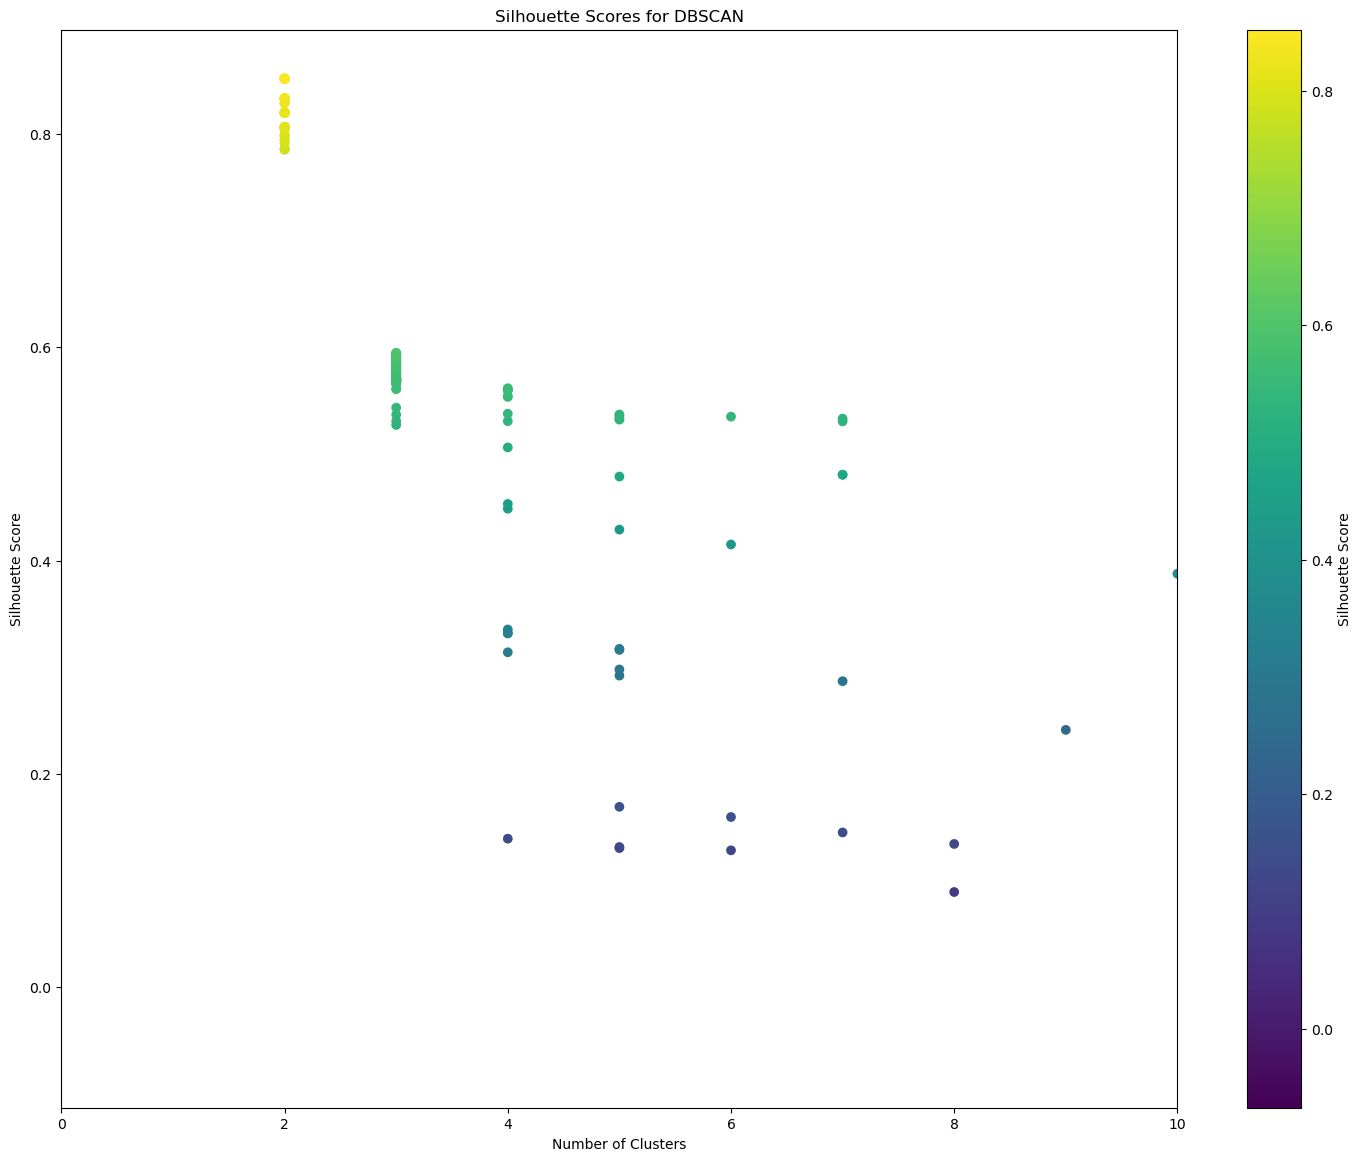

In [29]:
# def plot_dbscan_silhouette_scores(X_std, eps_range, min_samples_range):
#     scores = []
#     n_clusters_values = []

#     for eps in eps_range:
#         for min_samples in min_samples_range:
#             model = DBSCAN(eps=eps, min_samples=min_samples)
#             model.fit(X_std)
#             labels = model.labels_
#             n_clusters = len(np.unique(labels))

#             if n_clusters > 1:
#                 score = silhouette_score(X_std, labels)
#                 scores.append(score)
#                 n_clusters_values.append(n_clusters)

#     fig = plt.figure(figsize=(18, 14))  # Increase the figure size
#     ax = fig.add_subplot(111)
#     sc = ax.scatter(n_clusters_values, scores, c=scores, cmap='viridis', marker='o')
#     ax.set_xlabel('Number of Clusters')
#     ax.set_ylabel('Silhouette Score')
#     ax.set_title('Silhouette Scores for DBSCAN')
#     ax.set_xlim(0, 10)  # Set x-axis limit to 10
#     plt.colorbar(sc, label='Silhouette Score')
#     plt.show()

# # Call the function with your data and ranges for eps and min_samples
# plot_dbscan_silhouette_scores(X_combined_selected_std, np.linspace(1, 10, 50), range(2, 10))

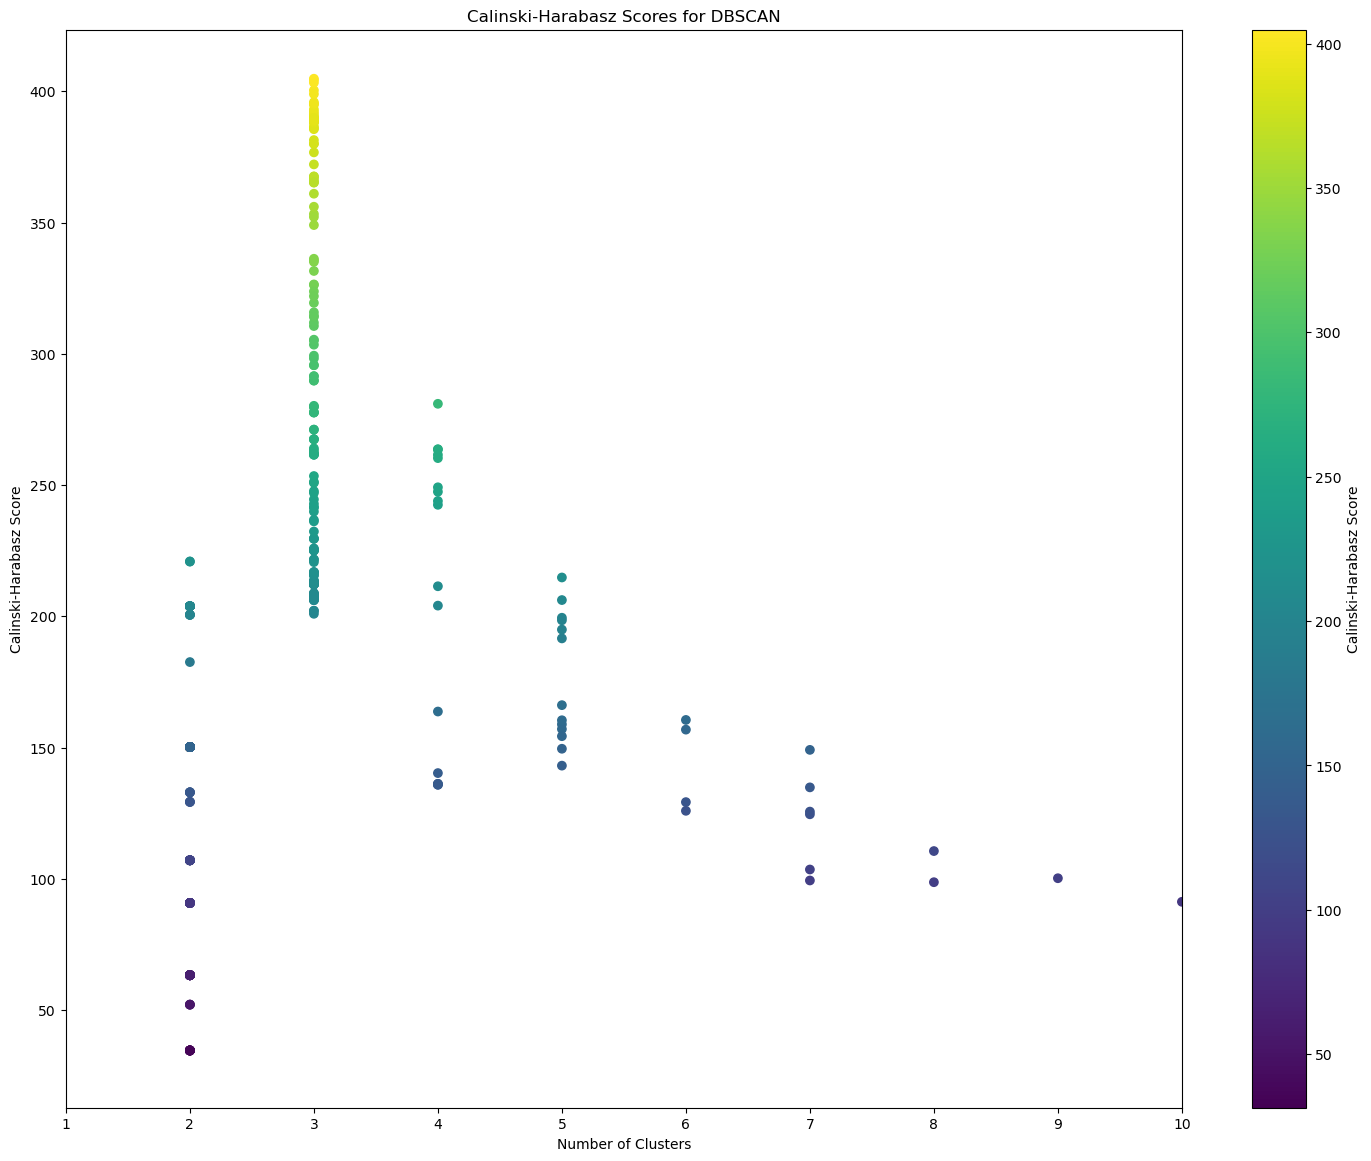

In [30]:
# from sklearn.metrics import calinski_harabasz_score

# def plot_dbscan_calinski_harabasz_scores(X_std, eps_range, min_samples_range):
#     scores = []
#     n_clusters_values = []

#     for eps in eps_range:
#         for min_samples in min_samples_range:
#             model = DBSCAN(eps=eps, min_samples=min_samples)
#             model.fit(X_std)
#             labels = model.labels_
#             n_clusters = len(np.unique(labels))

#             if n_clusters > 1:
#                 score = calinski_harabasz_score(X_std, labels)
#                 scores.append(score)
#                 n_clusters_values.append(n_clusters)

#     fig = plt.figure(figsize=(18, 14))
#     ax = fig.add_subplot(111)
#     sc = ax.scatter(n_clusters_values, scores, c=scores, cmap='viridis', marker='o')
#     ax.set_xlabel('Number of Clusters')
#     ax.set_ylabel('Calinski-Harabasz Score')
#     ax.set_title('Calinski-Harabasz Scores for DBSCAN')
#     ax.set_xlim(1, 10)
#     plt.colorbar(sc, label='Calinski-Harabasz Score')
#     plt.show()

# # Call the function with your data and ranges for eps and min_samples
# plot_dbscan_calinski_harabasz_scores(X_combined_selected_std, np.linspace(1, 10, 50), range(2, 10))



In [37]:
# ### 4.Apply the DBSCAN clustering algorithm:
# # Initialize the DBSCAN model with specified parameters
# dbscan = DBSCAN(eps=9, min_samples=3)

# # Fit the model and predict the cluster labels
# cluster_labels = dbscan.fit_predict(X_combined_selected_std)

In [34]:
# ### 4.Apply the DBSCAN clustering algorithm:
# # Initialize the DBSCAN model with specified parameters
# dbscan = DBSCAN(eps=8.89795918367347, min_samples=3)

# # Fit the model and predict the cluster labels
# cluster_labels = dbscan.fit_predict(X_combined_selected_std)

# ### 5.Evaluate the clustering results using the silhouette score:
# # Calculate the silhouette score
# sil_score = silhouette_score(X_combined_selected_std, cluster_labels)

# print(f'Silhouette Score: {sil_score}')

# # 6. Create a scatter plot matrix for any number of features
# import seaborn as sns

# # Create a new DataFrame with the selected features
# X_combined_selected_with_labels = X_combined_selected.copy()
# # Add a column for the cluster labels
# X_combined_selected_with_labels['Cluster'] = cluster_labels

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [31]:
# import math
# import seaborn as sns
# import matplotlib.pyplot as plt

# def plot_sub_matrices(data, features_per_matrix=3):
#     # Create a new DataFrame with ordered cluster labels
#     data_ordered = data.copy()
#     data_ordered['Ordered_Cluster'] = data['Cluster'].replace({-1: max(data['Cluster']) + 1}).astype(int)

#     num_features = len(data.columns) - 2  # Subtract 2 for the 'Cluster' and 'Ordered_Cluster' columns
#     num_matrices = math.ceil(num_features / features_per_matrix)

#     for matrix_idx in range(num_matrices):
#         start_idx = matrix_idx * features_per_matrix
#         end_idx = min((matrix_idx + 1) * features_per_matrix, num_features)

#         selected_features = data.columns[start_idx:end_idx]
#         sub_data = data_ordered[[*selected_features, 'Ordered_Cluster']]

#         # Increase the figure size
#         g = sns.pairplot(sub_data, hue='Ordered_Cluster', diag_kind='hist', palette='viridis')
#         g.fig.set_size_inches(12, 12)

#         plt.suptitle(f'Optimized DBSCAN Clustering (Matrix {matrix_idx + 1})', y=1.02)
#         plt.show()


# def shorten_feature_names(name, index, max_length=25):
#     if len(name) > max_length:
#         return f"{name[:max_length]}..._{index}"
#     else:
#         return name

# # Apply the function to the column names
# shortened_column_names = [shorten_feature_names(name, idx) for idx, name in enumerate(X_combined_selected_with_labels.columns)]
# X_combined_selected_with_labels_shortened_names = X_combined_selected_with_labels.copy()
# X_combined_selected_with_labels_shortened_names.columns = shortened_column_names

# # Call the function to create the scatter plot matrices
# plot_sub_matrices(X_combined_selected_with_labels_shortened_names, features_per_matrix=3)

NameError: name 'X_combined_selected_with_labels' is not defined

In [ ]:
# ### 4.Apply the DBSCAN clustering algorithm:
# # Initialize the DBSCAN model with specified parameters
# dbscan = DBSCAN(eps=8.89795918367347, min_samples=2)

# # Fit the model and predict the cluster labels
# cluster_labels = dbscan.fit_predict(X_combined_selected_std)

# ### 5.Evaluate the clustering results using the silhouette score:
# # Calculate the silhouette score
# sil_score = silhouette_score(X_combined_selected_std, cluster_labels)

# print(f'Silhouette Score: {sil_score}')

# # 6. Create a scatter plot matrix for any number of features
# import seaborn as sns

# # Create a new DataFrame with the selected features
# X_combined_selected_with_labels = X_combined_selected.copy()
# # Add a column for the cluster labels
# X_combined_selected_with_labels['Cluster'] = cluster_labels

## K-means

In [ ]:
# import math
# import seaborn as sns
# import matplotlib.pyplot as plt

# def plot_sub_matrices(data, features_per_matrix=3):
#     # Create a new DataFrame with ordered cluster labels
#     data_ordered = data.copy()
#     data_ordered['Ordered_Cluster'] = data['Cluster'].replace({-1: max(data['Cluster']) + 1}).astype(int)

#     num_features = len(data.columns) - 2  # Subtract 2 for the 'Cluster' and 'Ordered_Cluster' columns
#     num_matrices = math.ceil(num_features / features_per_matrix)

#     for matrix_idx in range(num_matrices):
#         start_idx = matrix_idx * features_per_matrix
#         end_idx = min((matrix_idx + 1) * features_per_matrix, num_features)

#         selected_features = data.columns[start_idx:end_idx]
#         sub_data = data_ordered[[*selected_features, 'Ordered_Cluster']]

#         # Increase the figure size
#         g = sns.pairplot(sub_data, hue='Ordered_Cluster', diag_kind='hist', palette='viridis')
#         g.fig.set_size_inches(12, 12)

#         plt.suptitle(f'Optimized K-Means Clustering (Matrix {matrix_idx + 1})', y=1.02)
#         plt.show()


# def shorten_feature_names(name, index, max_length=25):
#     if len(name) > max_length:
#         return f"{name[:max_length]}..._{index}"
#     else:
#         return name

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

n_clusters: 2, score: 0.5375527640874076
n_clusters: 3, score: 0.3344235614550322


c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

n_clusters: 4, score: 0.31264870944190604
n_clusters: 5, score: 0.3183619516365676


c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

n_clusters: 6, score: 0.3266913990200777
n_clusters: 7, score: 0.332950561172893


c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


n_clusters: 8, score: 0.3280013798062071
n_clusters: 9, score: 0.3028517167300359


c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

n_clusters: 10, score: 0.3218198684001232
Best parameters: n_clusters=2, score=0.5375527640874076
Silhouette Score: 0.5375527640874076


c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


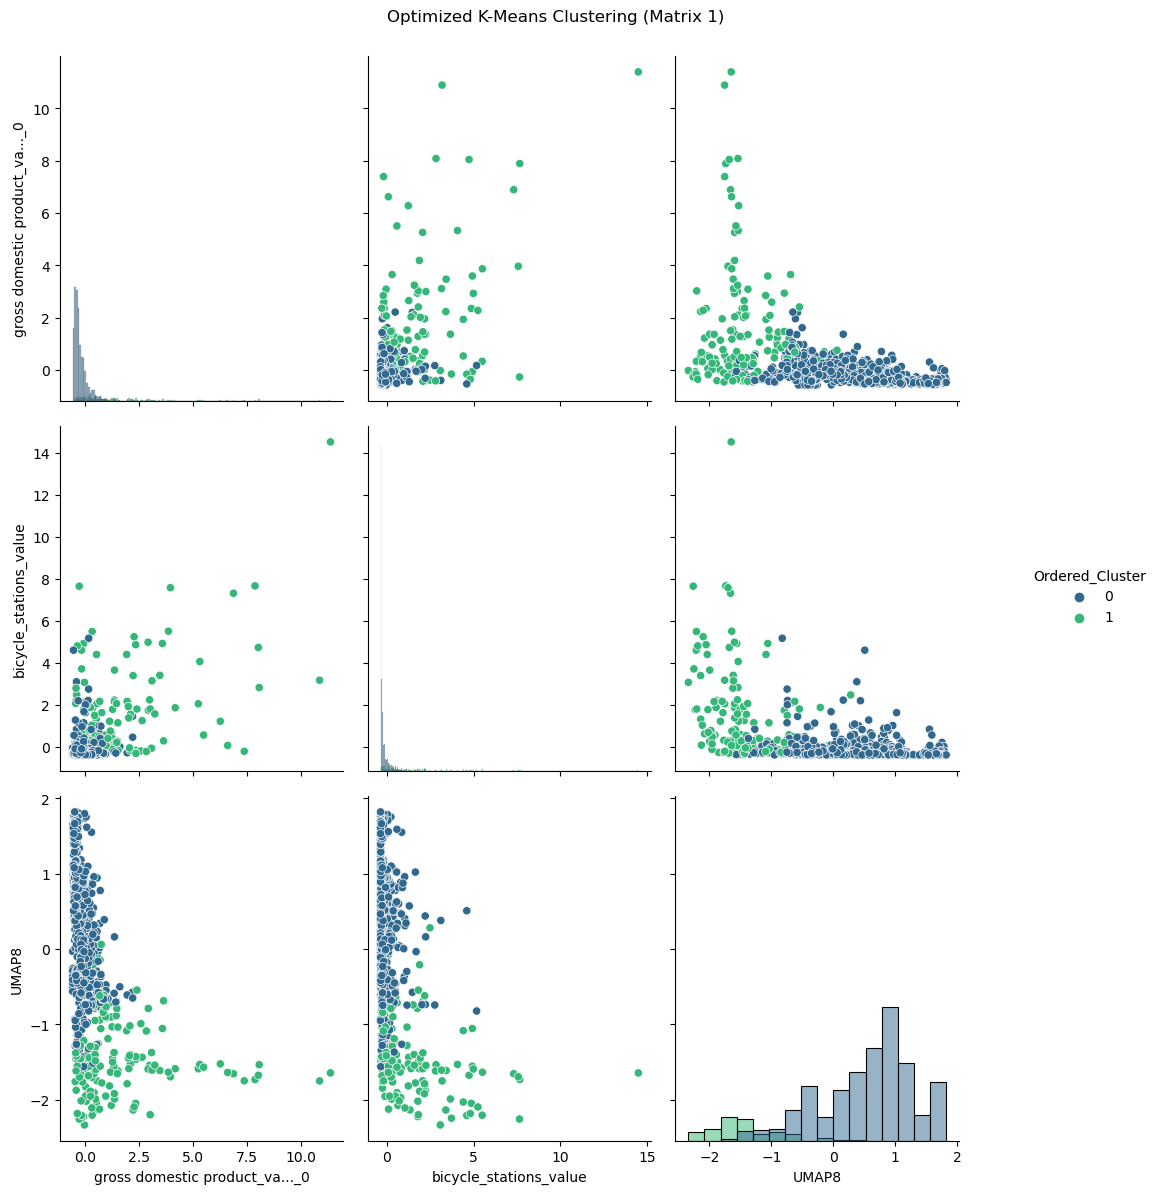

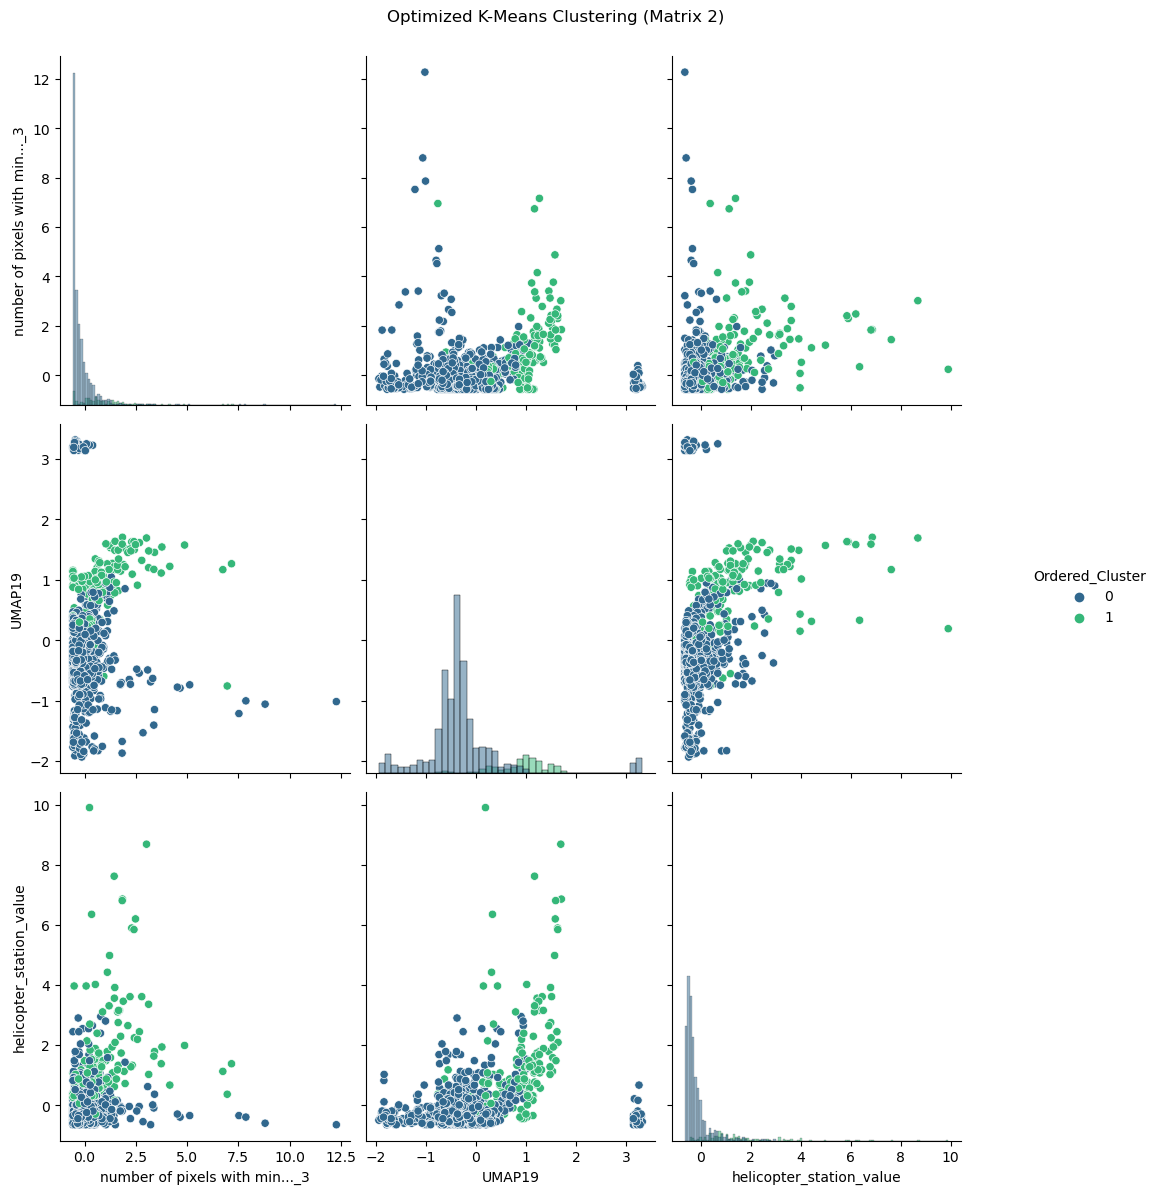

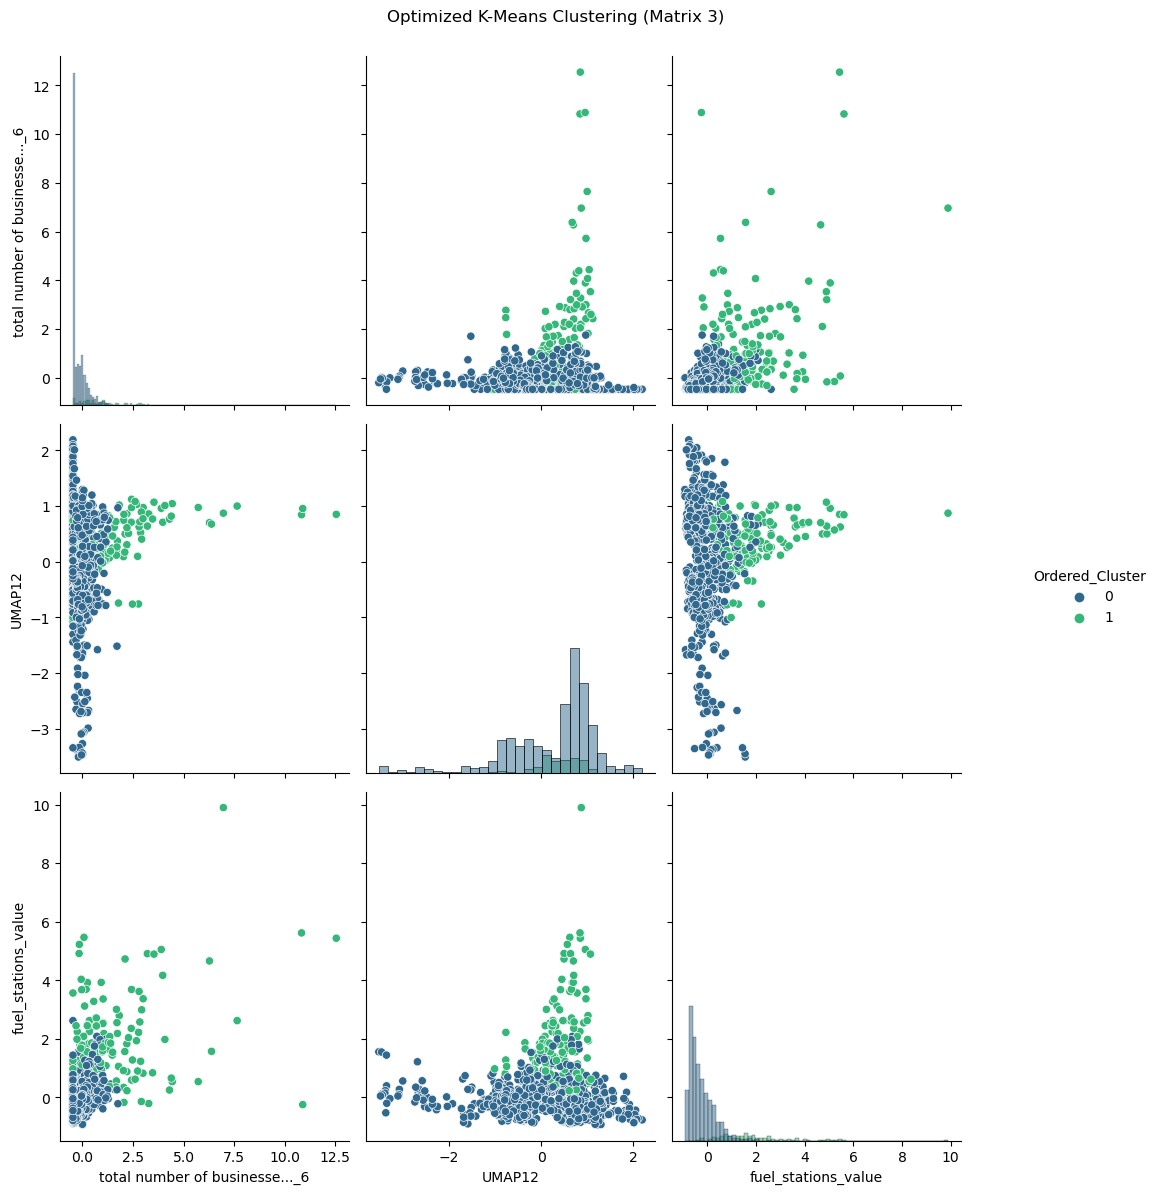

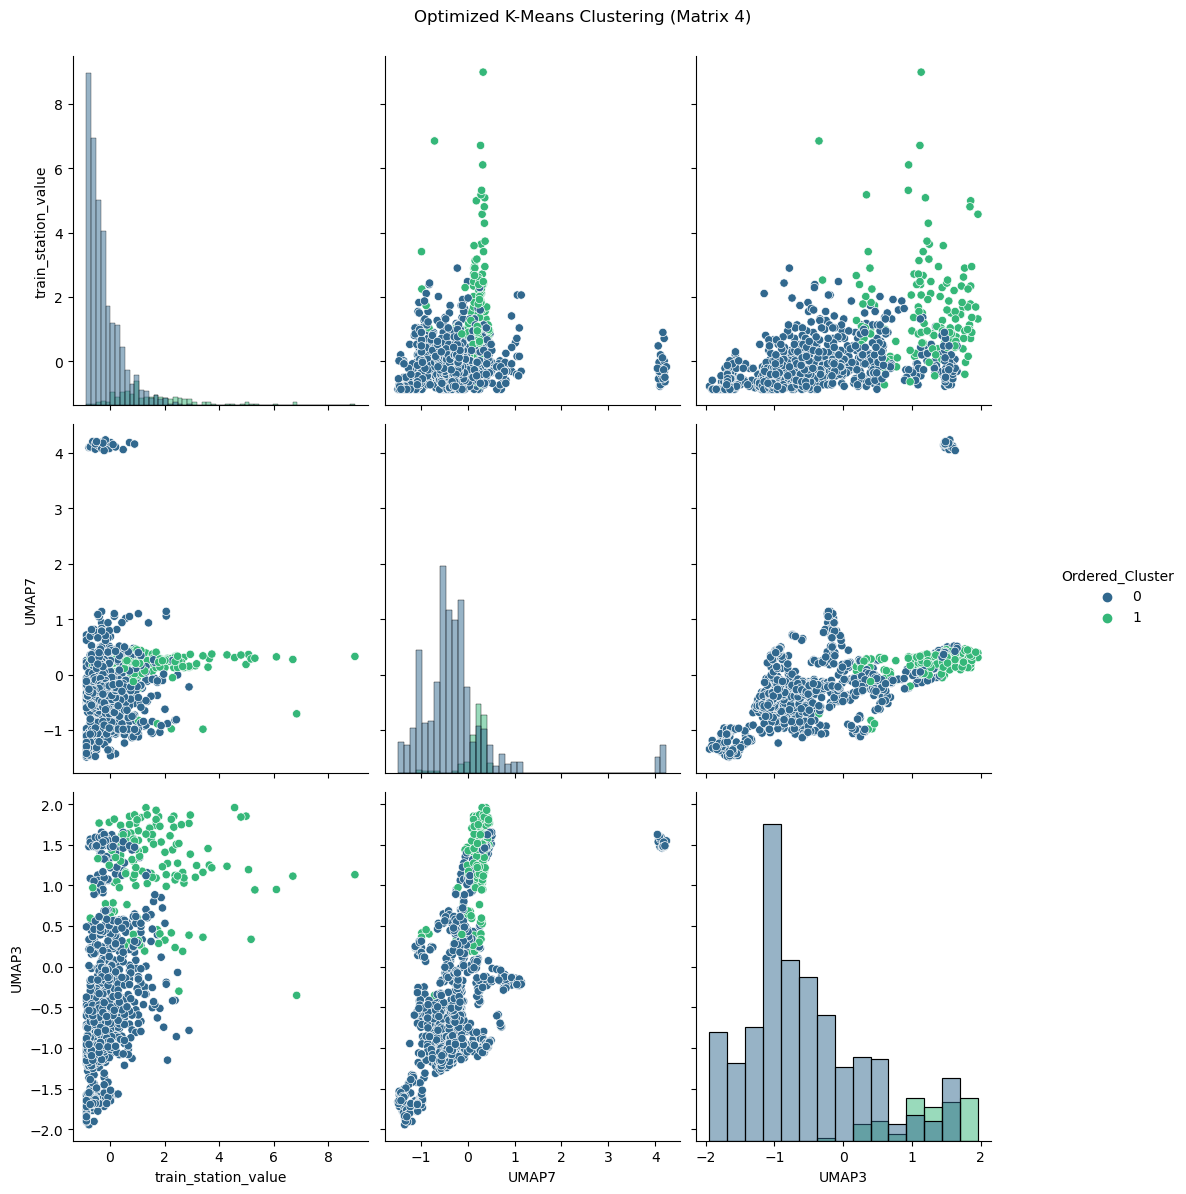

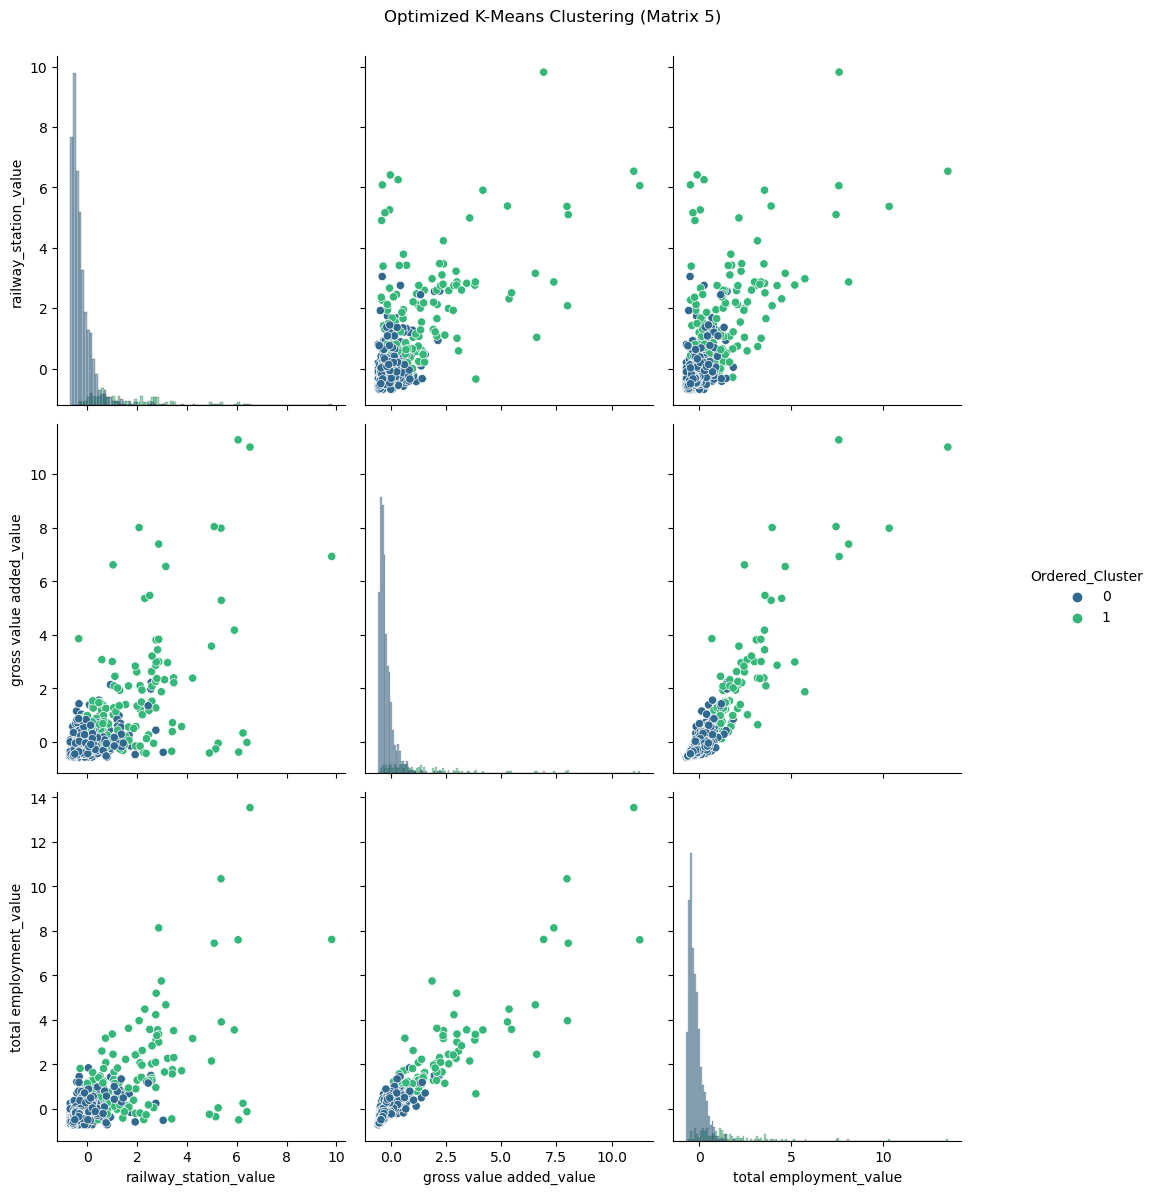

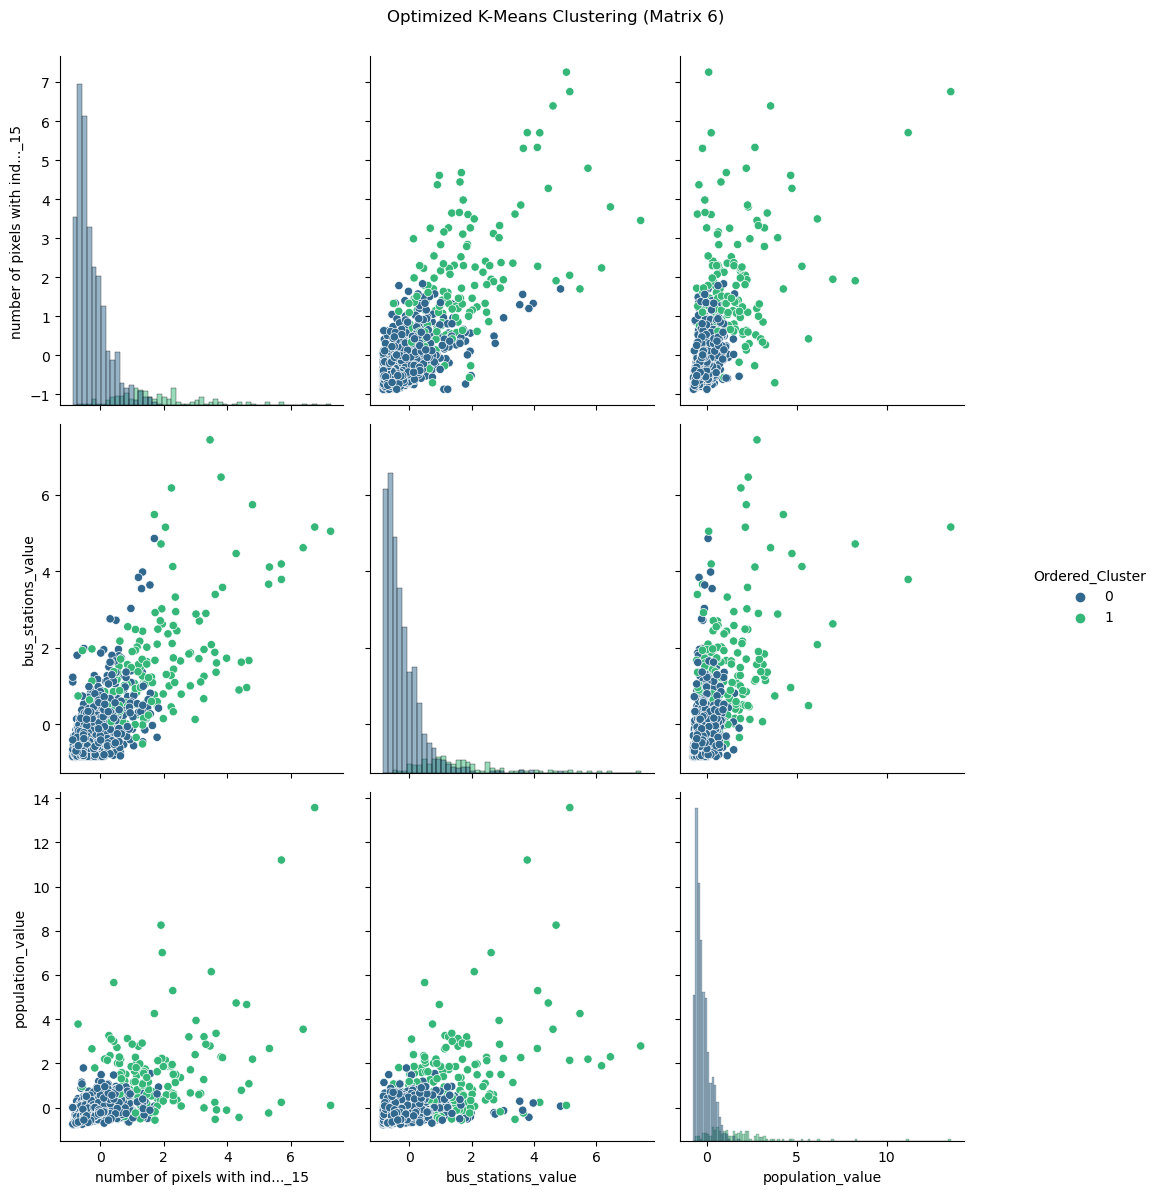

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import AgglomerativeClustering
# from sklearn.metrics import silhouette_score

# # Assuming X_train, X_test, and selected_features are already defined

# # Combine the train and test datasets
# X_combined = pd.concat([X_train, X_test])
# # Sort the DataFrame by index
# X_combined = X_combined.sort_index()
# # Select the features
# X_combined_selected = X_combined[selected_features]

# # Standardize the data
# scaler = StandardScaler()
# X_combined_selected_std = scaler.fit_transform(X_combined_selected)

# import numpy as np
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score

# def find_best_kmeans_params(X_std, cluster_range):
#     best_n_clusters = 0
#     best_score = -1

#     for n_clusters in cluster_range:
#         kmeans = KMeans(n_clusters=n_clusters, random_state=42)
#         kmeans.fit(X_std)
#         labels = kmeans.labels_
#         score = silhouette_score(X_std, labels)
#         print(f'n_clusters: {n_clusters}, score: {score}')

#         if score > best_score:
#             best_n_clusters = n_clusters
#             best_score = score

#     print(f'Best parameters: n_clusters={best_n_clusters}, score={best_score}')
#     return best_n_clusters, best_score

# # Call the function with your data:
# best_n_clusters, best_score = find_best_kmeans_params(X_combined_selected_std, range(2, 11))

# ### 4.Apply the KMeans clustering algorithm:
# # Initialize the KMeans model with specified parameters
# kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)

# # Fit the model and predict the cluster labels
# cluster_labels = kmeans.fit_predict(X_combined_selected_std)

# ### 5.Evaluate the clustering results using the silhouette score:
# # Calculate the silhouette score
# sil_score = silhouette_score(X_combined_selected_std, cluster_labels)

# print(f'Silhouette Score: {sil_score}')

# # 6. Create a scatter plot matrix for any number of features
# import seaborn as sns

# # Create a new DataFrame with the selected features
# X_combined_selected_with_labels = X_combined_selected.copy()
# # Add a column for the cluster labels
# X_combined_selected_with_labels['Cluster'] = cluster_labels

# def shorten_feature_names(name, index, max_length=25):
#     if len(name) > max_length:
#         return f"{name[:max_length]}..._{index}"
#     else:
#         return name

# # Apply the function to the column names
# shortened_column_names = [shorten_feature_names(name, idx) for idx, name in enumerate(X_combined_selected_with_labels.columns)]
# X_combined_selected_with_labels_shortened_names = X_combined_selected_with_labels.copy()
# X_combined_selected_with_labels_shortened_names.columns = shortened_column_names

# # Call the function to create the scatter plot matrices
# plot_sub_matrices(X_combined_selected_with_labels_shortened_names, features_per_matrix=3)

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

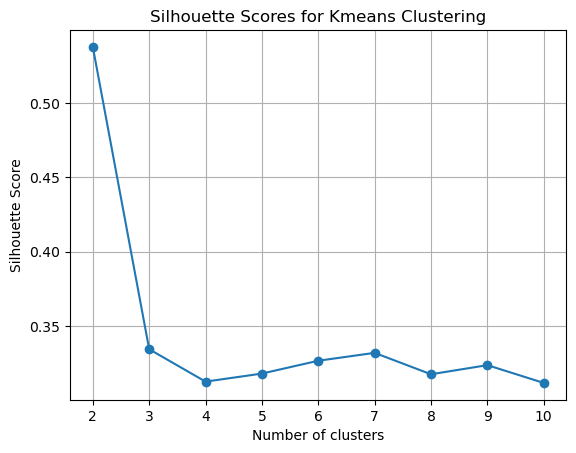

In [ ]:
# from sklearn.cluster import KMeans

# def plot_silhouette_scores(X_std, cluster_range, clusterer):
#     scores = []

#     for n_clusters in cluster_range:
#         if clusterer == 'kmeans':
#             model = KMeans(n_clusters=n_clusters)
#         else:
#             raise ValueError("Invalid clusterer. Supported options: 'kmeans'")

#         model.fit(X_std)
#         labels = model.labels_
#         score = silhouette_score(X_std, labels)
#         scores.append(score)

#     plt.plot(cluster_range, scores, marker='o')
#     plt.xlabel('Number of clusters')
#     plt.ylabel('Silhouette Score')
#     plt.title(f'Silhouette Scores for {clusterer.capitalize()} Clustering')
#     plt.grid()
#     plt.show()

# # Call the function with your data and a range of cluster sizes
# plot_silhouette_scores(X_combined_selected_std, range(2, 11), clusterer='kmeans')


c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

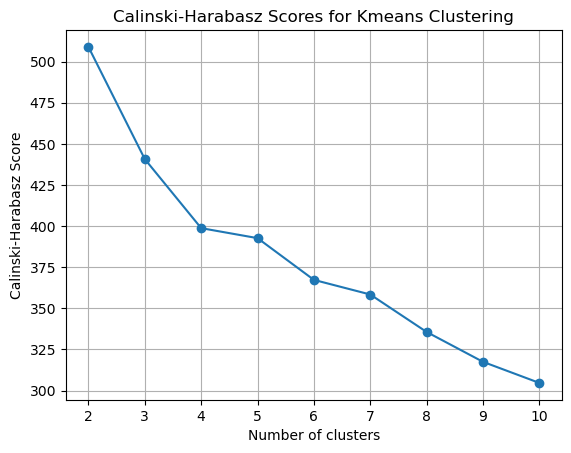

In [ ]:
# from sklearn.cluster import KMeans
# from sklearn.metrics import calinski_harabasz_score

# def plot_calinski_harabasz_scores(X_std, cluster_range, clusterer):
#     scores = []

#     for n_clusters in cluster_range:
#         if clusterer == 'kmeans':
#             model = KMeans(n_clusters=n_clusters)
#         else:
#             raise ValueError("Invalid clusterer. Supported options: 'kmeans'")

#         model.fit(X_std)
#         labels = model.labels_
#         score = calinski_harabasz_score(X_std, labels)
#         scores.append(score)

#     plt.plot(cluster_range, scores, marker='o')
#     plt.xlabel('Number of clusters')
#     plt.ylabel('Calinski-Harabasz Score')
#     plt.title(f'Calinski-Harabasz Scores for {clusterer.capitalize()} Clustering')
#     plt.grid()
#     plt.show()

# # Call the function with your data and a range of cluster sizes
# plot_calinski_harabasz_scores(X_combined_selected_std, range(2, 11), clusterer='kmeans')



### 9.Add the cluster labels to the DataFrame:

In [ ]:
# # Create a new DataFrame from X_combined_selected
# X_combined_selected_modified = X_combined_selected.copy()

# # Assign cluster labels to the new DataFrame
# X_combined_selected_modified.loc[:, 'Cluster'] = cluster_labels

# Concatenate y_train and y_test
y_combined = pd.concat([y_train, y_test], axis=0)

# Sort y_combined by index
y_combined_sorted = y_combined.sort_index()

# Create a new DataFrame for y_combined_sorted
y_combined_sorted_df = pd.DataFrame(y_combined_sorted, columns=[agg_var_to_disagg])

# Combine the DataFrames
# df = pd.concat([df_eu.iloc[:, :5], y_combined_sorted_df, X_combined_selected_modified], axis=1)
df = pd.concat([df_eu.iloc[:, :5], y_combined_sorted_df, X_combined_selected_with_labels_shortened_names], axis=1)

### 10.Separate the dataframe into different clusters

In [ ]:
def separate_clusters(df):
    if 'Cluster' not in df.columns:
        df['Cluster'] = 0

    clusters = df['Cluster'].unique()
    cluster_dfs = {}

    for i, cluster in enumerate(clusters):
        cluster_name = f'df_cluster_{i}'
        cluster_df = df.loc[df['Cluster'] == cluster].copy()
        cluster_df['Cluster'] = i
        cluster_dfs[cluster_name] = cluster_df

    return cluster_dfs


cluster_dfs = separate_clusters(df)
n_clusters = len(cluster_dfs)
cluster_names = list(cluster_dfs.keys())

df_cluster_0 = cluster_dfs.get('df_cluster_0', None)
df_cluster_1 = cluster_dfs.get('df_cluster_1', None)
df_cluster_2 = cluster_dfs.get('df_cluster_2', None)
df_cluster_3 = cluster_dfs.get('df_cluster_3', None)
df_cluster_4 = cluster_dfs.get('df_cluster_4', None)

# Access the first cluster name and its corresponding DataFrame
first_cluster_name = cluster_names[0]
df_cluster_0 = cluster_dfs[first_cluster_name]

try:
    # Access the second cluster name and its corresponding DataFrame
    second_cluster_name = cluster_names[1]
    df_cluster_1 = cluster_dfs[second_cluster_name]
except IndexError:
    pass

try:
    # Access the third cluster name and its corresponding DataFrame
    third_cluster_name = cluster_names[2]
    df_cluster_2 = cluster_dfs[third_cluster_name]
except IndexError:
    pass

try:
    # Access the fourth cluster name and its corresponding DataFrame
    fourth_cluster_name = cluster_names[3]
    df_cluster_3 = cluster_dfs[fourth_cluster_name]
except IndexError:
    pass

try:
    # Access the fifth cluster name and its corresponding DataFrame
    fifth_cluster_name = cluster_names[4]
    df_cluster_4 = cluster_dfs[fifth_cluster_name]
except IndexError:
    pass

In [ ]:
print('shape of first cluster: ', df_cluster_0.shape)
try:
    print('shape of second cluster: ', df_cluster_1.shape)
except:
    pass
try:
    print('shape of third cluster: ', df_cluster_2.shape)
except:
    pass
try:
    print('shape of fourth cluster: ', df_cluster_3.shape)
except:
    pass
try:
    print('shape of fith cluster: ', df_cluster_4.shape)
except:
    pass

shape of first cluster:  (1026, 26)
shape of second cluster:  (144, 26)


In [ ]:
df_cluster_1.head()

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
10             EU                AT               AT1              AT13   
21             EU                AT               AT3              AT31   
35             EU                BE               BE1              BE10   
36             EU                BE               BE2              BE21   
97             EU                BG               BG4              BG41   

   NUTS3_region_code  charging_stations_value  gross domestic product_va..._0  \
10             AT130                 6.001407                        4.190019   
21             AT312                 1.322299                        1.016624   
35             BE100                 1.241625                        3.594598   
36             BE211                 1.817870                        1.938907   
97             BG411                -0.314236                        0.684915   

    bicycle_stations_value     UMAP8  number of pixels with min..._3  ...  \
10                1.865336 -1.591251                       -0.567470  ...   
21               -0.217342 -0.912717                        0.752853  ...   
35                4.923815 -1.056455                        1.280982  ...   
36                4.399504 -1.085047                        0.074874  ...   
97               -0.362984 -0.944314                        0.098631  ...   

       UMAP7     UMAP3  railway_station_value  gross value added_value  \
10  0.274621  1.114830               5.905461                 4.173291   
21 -0.060152  0.608749               1.037027                 1.012322   
35  0.052158  0.681665               4.986308                 3.575688   
36  0.304651  0.555346               1.296501                 1.928241   
97  0.085458  0.595004               0.729177                 0.639515   

    total employment_value  number of pixels with ind..._15  \
10                3.547804                         0.271300   
21                0.797782                         1.377934   
35                2.152313                        -0.175812   
36                1.279678                         1.143850   
97                3.178672                         1.144470   

    bus_stations_value  population_value    UMAP14  Cluster  
10            1.144532          3.260532  1.032547        1  
21            1.110092          0.453641  0.990339        1  
35            0.377800          1.792971  0.955353        1  
36            0.836823          1.444300  1.450107        1  
97            0.516693          2.017910  1.141413        1  

[5 rows x 26 columns]

# Master Dataframe Preparation

In [ ]:
def create_master_dataframe_based_on_population_weights_v2(df, first_five_columns_df, feature_names, agg_var_to_disagg, region, predicted_values=None):

    # Check if there is a column named 'index' and drop it if necessary
    if 'index' in df.columns:
        df = df.drop(columns='index')

    # Append the "region_columns" dataframe to the main features dataframe
    df = pd.concat([first_five_columns_df, df], axis=1)

    # Extract the "aggregated_metric" column as a new dataframe
    aggregated_metric = df.loc[:, f"{agg_var_to_disagg}"].copy()
    aggregated_metric_df = pd.concat([first_five_columns_df, pd.DataFrame(aggregated_metric)], axis=1)

    # Extract the "aggregated_metric_df" column as two new dataframes: The real variable at NUTS3 level. Target to disaggregate.
    df_eu_apply_target = aggregated_metric_df.copy()
    df_eu_apply_target = df_eu_apply_target.rename(columns={df_eu_apply_target.columns[5]: 'target_variable'})
    # Add the index as a column to the EU target DataFrame
    df_eu_apply_target['index'] = df_eu_apply_target.index
    df_region_apply_target = df_eu_apply_target.loc[df_eu_apply_target ['NUTS0_region_code'] == region, :].copy()

    # Remove the "aggregated_metric" column from the main dataframe
    df = df.drop(columns=[f"{agg_var_to_disagg}"])

    # Remove "aggregated_metric" from the feature_names list
    print('The length of all ancilliary features + the aggregated feature is: ', len(feature_names))
    feature_names = [f for f in feature_names if f != f"{agg_var_to_disagg}"]
    print('The length of all ancilliary features is: ', len(feature_names))

    # Compute the population weights
    pd.set_option('display.float_format', lambda x: '%.4f' % x)
    df.reset_index(drop=True, inplace=True)
    metric_weight_df = df.iloc[:, :5].copy()  # select first 5 columns and make a copy

    # Calculate population weights
    population_weights = df.groupby('NUTS0_region_code', group_keys=False)['population_value'].apply(lambda x: x / x.sum().round(4)).reset_index(drop=True)
    # Assign population weights to the metric_weight_df
    metric_weight_df['population_weight'] = population_weights

    # Compute the sum of the agg_var_to_disagg at country level (variable that want to be disaggregated)
    agg_metric_country_value = aggregated_metric_df.groupby('NUTS0_region_code').agg({f'{agg_var_to_disagg}': 'sum'}).reset_index(drop=False)

    # Calculate the pseudo value multiplying the population weight of each NUTS3_region by the agg_var_to_disagg for each country (each NUTS3_region_code weight by each NUTS0_region_code aggregate population)
    agg_metric_pseudo_value = metric_weight_df.merge(agg_metric_country_value, on=['NUTS0_region_code'], how='left')[[f'{agg_var_to_disagg}', 'population_weight']].prod(axis=1).groupby(level=0).sum()

    agg_metric_pseudo_value = pd.DataFrame(agg_metric_pseudo_value, columns=[f"{agg_var_to_disagg}"])
    agg_metric_pseudo_value.reset_index(drop=True, inplace=True)

    # Extract the metric disaggregated at NUTS3 level from the pseudo value from population_weight as the first initial disaggregated method
    first_five_columns_df.reset_index(drop=True, inplace=True)
    disagg_metric_population_all = pd.concat([first_five_columns_df, agg_metric_pseudo_value], axis=1).copy()
    disagg_metric_population_all = disagg_metric_population_all.rename(columns={disagg_metric_population_all.columns[5]: 'target_variable'})
    disagg_metric_population_all['index'] = disagg_metric_population_all.index

    # Filter the disagg_metric_population_all DataFrame to get the disaggregated metric for the specified region
    disagg_metric_population = disagg_metric_population_all[disagg_metric_population_all['NUTS0_region_code'].str.startswith(f'{region}')].copy()

    # Extract the disaggregated metric for the entire EU
    disagg_metric_population_eu = disagg_metric_population_all.copy()

    # Combine all the dataframes to start the creation of the master dataframe
    df_apply_eu = pd.concat([first_five_columns_df, df[feature_names], agg_metric_pseudo_value], axis=1)
    # Add the index as a column to the EU target DataFrame
    df_apply_eu['index'] = df_apply_eu.index
    # Filter the master_df to only include NUTS_0 regions that start with 'DE'
    df_apply_region = df_apply_eu[df_apply_eu['NUTS0_region_code'].str.startswith(f'{region}')].copy()

    # Create a DataFrame to store the master input and target data
    master_input_df = pd.DataFrame()
    master_label_df = pd.DataFrame()

    # Loop through each feature
    for feature in feature_names:
        # Compute the sum of the feature for each NUTS0 region (country level)
        agg_country_value = df.groupby('NUTS0_region_code').agg({f'{feature}': 'sum'}).reset_index(drop=False)

        # Calculate the pseudo value multiplying the population weight of each NUTS3_region by the agg_var_to_disagg for each country (each NUTS3_region_code weight by each NUTS0_region_code aggregate feature)
        pseudo_value = metric_weight_df.merge(agg_country_value, on=['NUTS0_region_code'], how='left')[[f'{feature}', 'population_weight']].prod(axis=1).groupby(level=0).sum()

        # Create a DataFrame with the target variable (variable to predict. The true value of the pseudo_value)
        y = df[f'{feature}'].reset_index(drop=True)

        # Create a copy of the df DataFrame to store the pseudo-value for this feature
        df_pseudo = df.copy()

        # Replace the feature column in df_pseudo with the new feature_df
        feature_df = pd.DataFrame(data=pseudo_value.values, index=pseudo_value.index, columns=[f'{feature}_pseudo'])
        df_pseudo[f'{feature}'] = feature_df[f'{feature}_pseudo']

        # Append the DataFrame to the master DataFrame
        master_input_df = pd.concat([master_input_df, df_pseudo], axis=0, ignore_index=True)
        master_label_df = pd.concat([master_label_df, y], axis=0, ignore_index=True)

    # Append the "agg_metric_pseudo_value" dataframe as many times as necessary
    master_input_df = pd.concat([master_input_df, pd.concat([agg_metric_pseudo_value]*len(feature_names), axis=0, ignore_index=True)], axis=1)

    # Append the "region_columns" dataframe as many times as necessary to the "y" labeled column
    master_label_df = pd.concat([pd.concat([first_five_columns_df]*len(feature_names), axis=0, ignore_index=True), master_label_df], axis=1)

    # Add the index as a column to the master DataFrame
    master_input_df['index'] = master_input_df.index
    master_label_df = master_label_df.rename(columns={master_label_df.columns[5]: 'target_variable'})
    master_label_df['index'] = master_label_df.index

    # Splitting the master DataFrame into train and test data (Splitting the data into EU and the country to test on)
    master_input_train_df = master_input_df.loc[master_input_df['NUTS0_region_code'] != region, :].copy()
    master_label_train_df = master_label_df.loc[master_label_df['NUTS0_region_code'] != region, :].copy()
    master_input_test_df = master_input_df.loc[master_input_df['NUTS0_region_code'] == region, :].copy()
    master_label_test_df = master_label_df.loc[master_label_df['NUTS0_region_code'] == region, :].copy()

    # If predicted_values are provided, update the relevant DataFrames
    if predicted_values is not None:
        # Calculate the repeat factor
        repeat_factor = len(master_input_df) // len(predicted_values)

        # Repeat predicted_values by the repeat factor along the y-axis
        repeated_predicted_values = pd.concat([predicted_values] * repeat_factor, axis=0, ignore_index=True)

        # Update master_input_df with repeated_predicted_values
        master_input_df.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values
        # master_input_df.loc[:, agg_var_to_disagg] = repeated_predicted_values.values

        # Update master_input_train_df and master_input_test_df with repeated_predicted_values
        master_input_train_df = master_input_df.loc[master_input_df['NUTS0_region_code'] != region, :].copy()
        master_input_test_df = master_input_df.loc[master_input_df['NUTS0_region_code'] == region, :].copy()

        # Update df_apply_eu with repeated_predicted_values
        df_apply_eu.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values
        # df_apply_eu.loc[:, agg_var_to_disagg] = repeated_predicted_values.values

        # Update df_apply_region with repeated_predicted_values
        df_apply_region = df_apply_eu[df_apply_eu['NUTS0_region_code'].str.startswith(f'{region}')].copy()

    return master_input_df, master_label_df, master_input_train_df, master_label_train_df, master_input_test_df, master_label_test_df, \
        df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
            disagg_metric_population, disagg_metric_population_eu

## Dataset for the model

In [ ]:
def prepare_data_for_cluster(cluster_id, master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu):
    # Select only numeric columns for train and test data
    numeric_cols_1 = master_input_train_df.select_dtypes(include=['int32', 'int64', 'float64', 'float32']).columns
    numeric_cols_2 = master_input_test_df.select_dtypes(include=['int32', 'int64', 'float64', 'float32']).columns
    X_train = master_input_train_df[numeric_cols_1].copy()
    X_test = master_input_test_df[numeric_cols_2].copy()

    # Select only numeric columns for label train and test data
    numeric_cols_3 = master_label_train_df.select_dtypes(include=['int32', 'int64', 'float64', 'float32']).columns
    numeric_cols_4 = master_label_test_df.select_dtypes(include=['int32', 'int64', 'float64', 'float32']).columns
    y_train = master_label_train_df[numeric_cols_3].copy()
    y_test = master_label_test_df[numeric_cols_4].copy()

    # Select only numeric columns for apply EU and apply region data
    numeric_cols_5 = df_apply_eu.select_dtypes(include=['int32', 'int64', 'float64', 'float32']).columns
    numeric_cols_6 = df_apply_region.select_dtypes(include=['int32', 'int64', 'float64', 'float32']).columns
    X_train_apply = df_apply_eu[numeric_cols_5].copy()
    X_test_apply = df_apply_region[numeric_cols_6].copy()

    # Select only numeric columns for apply EU and apply region data
    numeric_cols_7 = df_eu_apply_target.select_dtypes(include=['int32', 'int64', 'float64', 'float32']).columns
    numeric_cols_8 = df_region_apply_target.select_dtypes(include=['int32', 'int64', 'float64', 'float32']).columns
    y_train_apply = df_eu_apply_target[numeric_cols_7].copy()
    y_test_apply = df_region_apply_target[numeric_cols_8].copy()

    # Select only numeric columns for the first disaggregation metric with population
    numeric_cols_9 = disagg_metric_population.select_dtypes(include=['int32', 'int64', 'float64', 'float32']).columns
    y_predict_pop = disagg_metric_population[numeric_cols_9].copy()

    # Select only numeric columns for the first disaggregation metric with population
    numeric_cols_10 = disagg_metric_population_eu.select_dtypes(include=['int32', 'int64', 'float64', 'float32']).columns
    y_predict_pop_eu = disagg_metric_population_eu[numeric_cols_10].copy()

    # Select target variable for label train and test data
    y_train = y_train['target_variable']
    y_test = y_test['target_variable']
    y_train_apply = y_train_apply['target_variable']
    y_test_apply = y_test_apply['target_variable']

    return X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, y_predict_pop_eu

def save_dataframes(cluster_id, X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, y_predict_pop_eu, country_code, agg_var_to_disagg):
    # Set the directory to save the dataframes
    output_dir = os.path.join(os.getcwd(), '..', '..', '..', 'data', 'output', 'spatial_disaggregation', 'data_train_test', country_code)

    # Create the directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Set the file paths for the dataframes with cluster_id
    file_paths = [
        (X_train, f'X_train_{agg_var_to_disagg}_{country_code}_cluster{cluster_id}.csv'),
        (X_test, f'X_test_{agg_var_to_disagg}_{country_code}_cluster{cluster_id}.csv'),
        (y_train, f'y_train_{agg_var_to_disagg}_{country_code}_cluster{cluster_id}.csv'),
        (y_test, f'y_test_{agg_var_to_disagg}_{country_code}_cluster{cluster_id}.csv'),
        (X_train_apply, f'X_train_apply_{agg_var_to_disagg}_{country_code}_cluster{cluster_id}.csv'),
        (X_test_apply, f'X_test_apply_{agg_var_to_disagg}_{country_code}_cluster{cluster_id}.csv'),
        (y_train_apply, f'y_train_apply_{agg_var_to_disagg}_{country_code}_cluster{cluster_id}.csv'),
        (y_test_apply, f'y_test_apply_{agg_var_to_disagg}_{country_code}_cluster{cluster_id}.csv'),
        (y_predict_pop, f'y_predict_pop_{agg_var_to_disagg}_{country_code}_cluster{cluster_id}.csv'),
        (y_predict_pop_eu, f'y_predict_pop_eu_{agg_var_to_disagg}_{country_code}_cluster{cluster_id}.csv')
    ]

    # Save each dataframe to a CSV file
    for df, filename in file_paths:
        filepath = os.path.join(output_dir, filename)
        df.to_csv(filepath, index=False)


    # Save each dataframe to a CSV file
    for df, filename in file_paths:
        filepath = os.path.join(output_dir, filename)
        df.to_csv(filepath, index=False)

def load_dataframes(cluster_id, country_code, agg_var_to_disagg):
    # Set the directory to load the dataframes
    input_dir = os.path.join(os.getcwd(), '..', '..', '..', 'data', 'output', 'spatial_disaggregation', 'data_train_test', country_code)

    # Set the file paths for the dataframes with cluster_id
    file_paths = [
        (f'X_train_{agg_var_to_disagg}_{country_code}_cluster{cluster_id}.csv', f'X_train_{agg_var_to_disagg}_{country_code}'),
        (f'X_test_{agg_var_to_disagg}_{country_code}_cluster{cluster_id}.csv', f'X_test_{agg_var_to_disagg}_{country_code}'),
        (f'y_train_{agg_var_to_disagg}_{country_code}_cluster{cluster_id}.csv', f'y_train_{agg_var_to_disagg}_{country_code}'),
        (f'y_test_{agg_var_to_disagg}_{country_code}_cluster{cluster_id}.csv', f'y_test_{agg_var_to_disagg}_{country_code}'),
        (f'X_train_apply_{agg_var_to_disagg}_{country_code}_cluster{cluster_id}.csv', f'X_train_apply_{agg_var_to_disagg}_{country_code}'),
        (f'X_test_apply_{agg_var_to_disagg}_{country_code}_cluster{cluster_id}.csv', f'X_test_apply_{agg_var_to_disagg}_{country_code}'),
        (f'y_train_apply_{agg_var_to_disagg}_{country_code}_cluster{cluster_id}.csv', f'y_train_apply_{agg_var_to_disagg}_{country_code}'),
        (f'y_test_apply_{agg_var_to_disagg}_{country_code}_cluster{cluster_id}.csv', f'y_test_apply_{agg_var_to_disagg}_{country_code}'),
        (f'y_predict_pop_{agg_var_to_disagg}_{country_code}_cluster{cluster_id}.csv', f'y_predict_pop_{agg_var_to_disagg}_{country_code}'),
        (f'y_predict_pop_eu_{agg_var_to_disagg}_{country_code}_cluster{cluster_id}.csv', f'y_predict_pop_eu_{agg_var_to_disagg}_{country_code}')
    ]

    # Load each dataframe from a CSV file
    dataframes = []
    for filename, var_name in file_paths:
        filepath = os.path.join(input_dir, filename)
        df = pd.read_csv(filepath)
        dataframes.append((var_name, df))

    # Return the dataframes as separate variables
    return tuple(df[1] for df in dataframes)

def extract_cluster_id(cluster_name):
    # Extract the cluster_id from the cluster_name using a regex pattern
    match = re.search(r'cluster_(\d+)', cluster_name)
    if match:
        return int(match.group(1))
    else:
        raise ValueError(f"Invalid cluster name: {cluster_name}")

## Shuffling the data

In [ ]:
def shuffle_dataframes(X_train, y_train, X_test, y_test, random_state=42):
    # Concatenate the X and y dataframes for both training and testing sets
    train_df = pd.concat([X_train, y_train], axis=1)
    test_df = pd.concat([X_test, y_test], axis=1)

    # Shuffle the rows of each dataframe
    train_df = train_df.sample(frac=1, random_state=random_state)
    test_df = test_df.sample(frac=1, random_state=random_state)

    # Split the shuffled dataframes back into X and y
    X_train = train_df.drop(columns=['target_variable'])
    y_train = train_df['target_variable']
    X_test = test_df.drop(columns=['target_variable'])
    y_test = test_df['target_variable']

    return X_train, y_train, X_test, y_test

# XGBoost decision-tree


In [ ]:
def train_xgb_model(X_train, y_train, model_params, n_splits=5, random_states=[42]):

    # Initialize lists to store training and CV losses for all random states
    train_losses_all = []
    cv_losses_all = []
    train_maes_all = []
    cv_maes_all = []
    train_r2_all = []

    for random_state in random_states:
        print(f"Training with random state: {random_state}")

        # Define the model with the current random_state
        model = xgb.XGBRegressor(**model_params, random_state=random_state)

        # Perform KFold CV with 5 splits
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        # model = SVR(kernel='rbf', C=200)
        
        # Initialize lists to store training and CV losses
        train_losses = []
        cv_losses = []
        train_maes = []
        cv_maes = []
        train_r2 = []

        # Loop over each fold
        for fold, (train_index, cv_index) in enumerate(kf.split(X_train, y_train)):
            print("Training fold", fold + 1)
            X_train_fold, X_cv_fold = X_train.iloc[train_index, :], X_train.iloc[cv_index, :]
            y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]

            # Train the model
            eval_set = [(X_train_fold, y_train_fold), (X_cv_fold, y_cv_fold)]
            model.fit(X_train_fold, y_train_fold, eval_set=eval_set, verbose=False)
            # model.fit(X_train_fold, y_train_fold)

            # Evaluate the model on the training set
            y_pred_train = model.predict(X_train_fold)
            mse_train = mean_squared_error(y_train_fold, y_pred_train)
            rmse_train = np.sqrt(mse_train)
            train_losses.append(rmse_train)
            mae_train = mean_absolute_error(y_train_fold, y_pred_train)
            train_maes.append(mae_train)
            r2_train = r2_score(y_train_fold, y_pred_train)
            train_r2.append(r2_train)

            # Evaluate the model on the CV set
            y_pred_cv = model.predict(X_cv_fold)
            mse_cv = mean_squared_error(y_cv_fold, y_pred_cv)
            rmse_cv = np.sqrt(mse_cv)
            cv_losses.append(rmse_cv)
            mae_cv = mean_absolute_error(y_cv_fold, y_pred_cv)
            cv_maes.append(mae_cv)

        train_losses_all.extend(train_losses)
        cv_losses_all.extend(cv_losses)
        train_maes_all.extend(train_maes)
        cv_maes_all.extend(cv_maes)
        train_r2_all.extend(train_r2)

    # Calculate the mean training and CV losses for all random states
    avg_train_rmse = np.mean(train_losses_all)
    avg_cv_rmse = np.mean(cv_losses_all)
    avg_train_mae = np.mean(train_maes_all)
    avg_cv_mae = np.mean(cv_maes_all)
    avg_train_r2 = np.mean(train_r2_all)

    # Print the mean training and CV losses
    print("Mean Train RMSE: {:.4f}, Mean CV RMSE: {:.4f}".format(avg_train_rmse, avg_cv_rmse))
    print("Mean Train MAE: {:.4f}, Mean CV MAE: {:.4f}".format(avg_train_mae, avg_cv_mae))
    print("Mean Train R2: {:.4f}".format(avg_train_r2))

    return model, train_losses_all, cv_losses_all, train_maes_all, cv_maes_all

In [ ]:
def plot_cv_error(model):
    results = model.evals_result()
    num_rounds = len(results['validation_0']['rmse'])
    x_axis = range(0, num_rounds)
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['rmse'], label='Train RMSE')
    ax.plot(x_axis, results['validation_0']['mae'], label='Train MAE')
    ax.plot(x_axis, results['validation_1']['rmse'], label='CV RMSE')
    ax.plot(x_axis, results['validation_1']['mae'], label='CV MAE')
    ax.legend()
    plt.xlabel('Number of rounds')
    plt.ylabel('Error')
    plt.title('XGBoost Model Training and CV Errors')
    plt.show()

def plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    ax1.plot(train_losses, label='Training RMSE')
    ax1.plot(cv_losses, label='CV RMSE')
    ax1.legend()
    ax1.set_xlabel('Fold')
    ax1.set_ylabel('RMSE')
    ax1.set_title('XGBoost Model Training and CV RMSE')

    ax2.plot(train_maes, label='Training MAE')
    ax2.plot(cv_maes, label='CV MAE')
    ax2.legend()
    ax2.set_xlabel('Fold')
    ax2.set_ylabel('MAE')
    ax2.set_title('XGBoost Model Training and CV MAE')
    plt.show()

from sklearn.metrics import mean_absolute_error

def evaluate_model_xgb(model, X_test, y_test):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)

    print('XGBoost Model Performance')
    print('R2 Score: ', r2)
    # print('MSE: ', mse)
    print('RMSE: ', rmse)
    print('MAE: ', mae)

## Evaluate the model on the Test set

In [ ]:
def evaluate_model(model, X_test, y_test):
    # Evaluate the model on the test set
    y_pred_test = model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)

    print("\nTest RMSE: {:.4f}".format(rmse_test))
    print("Test MAE: {:.4f}".format(mae_test))
    print("Test R2: {:.4f}".format(r2_test))

    return rmse_test, mae_test, r2_test

## Apply the model to the EU and the region of interest

In [ ]:
def make_predictions(model, X_train_apply, X_test_apply):
    y_pred_apply_eu = model.predict(X_train_apply)
    y_pred_apply_region = model.predict(X_test_apply)

    return y_pred_apply_eu, y_pred_apply_region

## Create a DataFrame with the predictions

In [ ]:
def create_prediction_dataframes(y_pred_apply_eu, y_pred_apply_region):
    pred_apply_eu = pd.DataFrame(y_pred_apply_eu, columns=['predicted_value']).reset_index(drop=True)
    pred_apply_region = pd.DataFrame(y_pred_apply_region, columns=['predicted_value']).reset_index(drop=True)

    return pred_apply_eu, pred_apply_region

## Merge the predictions with the respective DataFrames

In [ ]:
def merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu, pred_apply_region):
    df_eu_apply_target['predicted_value'] = pred_apply_eu['predicted_value'].to_numpy()
    df_region_apply_target['predicted_value'] = pred_apply_region['predicted_value'].to_numpy()

    return df_eu_apply_target, df_region_apply_target

## Calculate the performance metrics for the disaggregated values using population weights and the model's predictions

In [ ]:
def print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target):
    pop_rmse = np.sqrt(mean_squared_error(y_test_apply, y_predict_pop['target_variable']))
    pop_mae = mean_absolute_error(y_test_apply, y_predict_pop['target_variable'])
    pop_r2 = r2_score(y_test_apply, y_predict_pop['target_variable'])

    model_rmse = np.sqrt(mean_squared_error(y_test_apply, df_region_apply_target['predicted_value']))
    model_mae = mean_absolute_error(y_test_apply, df_region_apply_target['predicted_value'])
    model_r2 = r2_score(y_test_apply, df_region_apply_target['predicted_value'])

    print("\nPopulation-based Disaggregation Metrics:")
    print("RMSE: {:.4f}".format(pop_rmse))
    print("MAE: {:.4f}".format(pop_mae))
    print("R2: {:.4f}".format(pop_r2))

    print("\nModel-based Disaggregation Metrics:")
    print("RMSE: {:.4f}".format(model_rmse))
    print("MAE: {:.4f}".format(model_mae))
    print("R2: {:.4f}".format(model_r2))

# XGBoost Model Cluster 1

## 1st Iteration

In [ ]:
print('The variable to disaggregate is: ', agg_var_to_disagg)

id_cluster = 0
cluster_name = cluster_names[id_cluster]
cluster_id = extract_cluster_id(cluster_name)
cluster_df = cluster_dfs[cluster_name]

# Check if cluster exists
cluster_df_region = cluster_df.loc[cluster_df['NUTS0_region_code'] == region, :].copy()

try:
    if cluster_df_region.empty:
        warnings.warn(f"The cluster doesn't contain the region '{region}'.")
        # Stop the runtime (you can also remove this line if you want the code to continue executing)
        raise SystemExit("The cluster doesn't contain the specified region.")
except SystemExit as e:
    print(e)

# Create a new DataFrame with the first five columns
first_five_columns_df = cluster_df.iloc[:, :5].copy()

# Drop the first five columns and the 'Cluster' column from cluster_df
cluster_df = cluster_df.drop(columns=['Cluster']).iloc[:, 5:]

# Create a list of feature names from the modified DataFrame
feature_names_cluster_df = []
for col in cluster_df.columns:
    feature_names_cluster_df.append(col)


The variable to disaggregate is:  charging_stations_value


In [ ]:
master_input_df, master_label_df, master_input_train_df, master_label_train_df, master_input_test_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu = create_master_dataframe_based_on_population_weights_v2(cluster_df, first_five_columns_df, feature_names_cluster_df, agg_var_to_disagg, region)

X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, y_predict_pop_eu = prepare_data_for_cluster(cluster_id, master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

The length of all ancilliary features + the aggregated feature is:  20
The length of all ancilliary features is:  19


In [ ]:
# X_train

In [ ]:
# # Check if there are any missing (nan) values in the dataset
# has_nan = X_train.isnull().any().any()
# # Check if there are any missing (nan) values in the dataset
# has_nan = y_train.isnull().any().any()

# print(f"Does the X_train dataset have any missing (nan) values? {has_nan}")
# print(f"Does the y_train dataset have any missing (nan) values? {has_nan}")

# # Check if there are any infinite (inf) values in the dataset
# has_inf_x = np.isinf(X_train).any().any()
# has_inf_y = np.isinf(y_train).any()

# print(f"Does the X_train dataset have any infinite (inf) values? {has_inf_x}")
# print(f"Does the y_train dataset have any infinite (inf) values? {has_inf_y}")

# # Get the indexes of rows and columns where the infinite values exist
# inf_rows, inf_cols = np.where(np.isinf(X_train))

# # Get the unique row indices with infinite values
# unique_inf_rows = np.unique(inf_rows)

# # Create a new DataFrame with only the rows containing infinite values
# inf_values_df = X_train.iloc[unique_inf_rows]

# # Display the DataFrame with infinite values
# print("DataFrame with infinite values:")
# print(inf_values_df)

In [ ]:
# Define model parameters
model_params = {
    "objective": "reg:squarederror",
    "n_estimators": 290,
    "max_depth": 3,
    'min_child_weight': 1.66,
    "learning_rate": 1,
    "subsample": 0.96,
    "colsample_bytree": 0.49,
    'gamma': 0.8570781361610906,
    # "colsample_bylevel": 0.8,
    # "colsample_bynode": 0.8,
    "reg_alpha": 0.90,
    "reg_lambda": 0.85,
    # "scale_pos_weight": 1,
    # "max_delta_step": 0,
    # "booster": "gbtree",
    # "tree_method": "auto",
    # "grow_policy": "depthwise",
    # "max_leaves": 0,
    # "max_bin": 256,
    # "min_split_loss": 0,
    "eval_metric": ["rmse", "mae"],
}


# Define a list of random states
random_states = [42,
                #  123,
                #  456,
                #  789
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

Training with random state: 42
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Mean Train RMSE: 0.2990, Mean CV RMSE: 0.4370
Mean Train MAE: 0.2084, Mean CV MAE: 0.2731
Mean Train R2: 0.8292


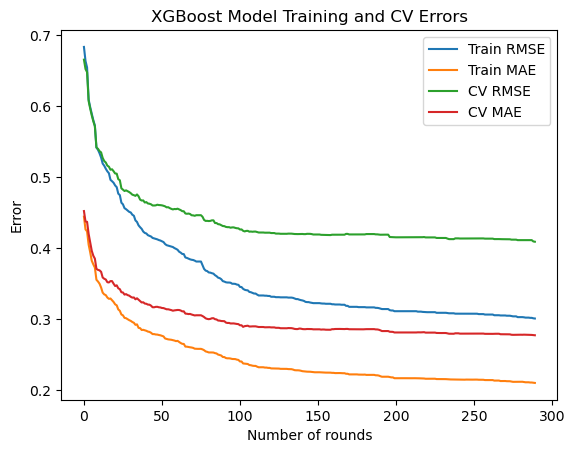

In [ ]:
plot_cv_error(model)

In [ ]:
# plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [ ]:
evaluate_model_xgb(model, X_test, y_test)

XGBoost Model Performance
R2 Score:  0.29816005126709577
RMSE:  0.497123816692477
MAE:  0.3530238081802362


In [ ]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

XGBoost Model Performance
R2 Score:  0.1775060986369269
RMSE:  0.5194982748949809
MAE:  0.3236315303398669


In [ ]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

XGBoost Model Performance
R2 Score:  0.10591601373191117
RMSE:  0.4650020528018336
MAE:  0.2898695887023648


In [ ]:
predictions_eu, predictions_region = make_predictions(model, X_train_apply, X_test_apply)
pred_apply_eu_df, pred_apply_region_df = create_prediction_dataframes(predictions_eu, predictions_region)
df_eu_apply_target_updated, df_region_apply_target_updated = merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu_df, pred_apply_region_df)

In [ ]:
print_disaggregation_metrics(y_train_apply, y_predict_pop_eu, df_eu_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 3.8776
MAE: 1.3746
R2: -44.8229

Model-based Disaggregation Metrics:
RMSE: 0.5195
MAE: 0.3236
R2: 0.1775


In [ ]:
print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 0.4233
MAE: 0.2555
R2: 0.2589

Model-based Disaggregation Metrics:
RMSE: 0.4650
MAE: 0.2899
R2: 0.1059


In [ ]:
# df_eu_apply_target

In [ ]:
# master_input_train_df

### Hyperparameters Optimization - GridSearchCV

In [ ]:
print('The variable to disaggregate is: ', agg_var_to_disagg)

id_cluster = 0
cluster_name = cluster_names[id_cluster]
cluster_id = extract_cluster_id(cluster_name)
cluster_df = cluster_dfs[cluster_name]

# Check if cluster exists
cluster_df_region = cluster_df.loc[cluster_df['NUTS0_region_code'] == region, :].copy()

try:
    if cluster_df_region.empty:
        warnings.warn(f"The cluster doesn't contain the region '{region}'.")
        # Stop the runtime (you can also remove this line if you want the code to continue executing)
        raise SystemExit("The cluster doesn't contain the specified region.")
except SystemExit as e:
    print(e)

# Create a new DataFrame with the first five columns
first_five_columns_df = cluster_df.iloc[:, :5].copy()

# Drop the first five columns and the 'Cluster' column from cluster_df
cluster_df = cluster_df.drop(columns=['Cluster']).iloc[:, 5:]

# Create a list of feature names from the modified DataFrame
feature_names_cluster_df = []
for col in cluster_df.columns:
    feature_names_cluster_df.append(col)

In [ ]:
master_input_df, master_label_df, master_input_train_df, master_label_train_df, master_input_test_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu = create_master_dataframe_based_on_population_weights_v2(cluster_df, first_five_columns_df, feature_names_cluster_df, agg_var_to_disagg, region)

X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, y_predict_pop_eu = prepare_data_for_cluster(cluster_id, master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

#### Bayesian Optimization with HYPEROPT

        https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning

In [ ]:
# Define the objective function that the fmin module can later optimize
def objective(params):
    model = xgb.XGBRegressor(
        learning_rate=params["learning_rate"],
        max_depth=int(params["max_depth"]),
        n_estimators=int(params["n_estimators"]),
        min_child_weight=params["min_child_weight"],
        gamma=params["gamma"],
        subsample=params["subsample"],
        colsample_bytree=params["colsample_bytree"],
        # colsample_bylevel=params["colsample_bylevel"],
        # colsample_bynode=params["colsample_bynode"],
        reg_alpha=params["reg_alpha"],
        reg_lambda=params["reg_lambda"],
        # scale_pos_weight=params["scale_pos_weight"],
        # max_delta_step=params["max_delta_step"],
        # booster=params["booster"],
        # tree_method=params["tree_method"],
        # grow_policy=params["grow_policy"],
        # max_leaves=int(params["max_leaves"]),
        # max_bin=int(params["max_bin"]),
        # min_split_loss=params["min_split_loss"],
    )

    score = cross_val_score(
    model, X_train, y_train, cv=KFold(10), scoring="neg_mean_absolute_error", n_jobs=-1
    ).mean()
    return {"loss": -score, "status": STATUS_OK}


# Define the search space for hyperparameters
space = {
    "learning_rate": hp.loguniform("learning_rate", 0.01, 0.3),
    "max_depth": hp.choice("max_depth", range(1, 11)),
    "n_estimators": hp.choice("n_estimators", range(80, 330)),
    "min_child_weight": hp.uniform("min_child_weight", 1, 11),
    "gamma": hp.uniform("gamma", 0, 1),
    "subsample": hp.uniform("subsample", 0.4, 1),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.4, 1),
    # "colsample_bylevel": hp.uniform("colsample_bylevel", 0.1, 1),
    # "colsample_bynode": hp.uniform("colsample_bynode", 0.1, 1),
    "reg_alpha": hp.uniform("reg_alpha", 0, 1),
    "reg_lambda": hp.uniform("reg_lambda", 0, 1),
    # "scale_pos_weight": hp.uniform("scale_pos_weight", 1, 10),
    # "max_delta_step": hp.uniform("max_delta_step", 0, 10),
    # "booster": hp.choice("booster", ["gbtree", "dart"]),
    # "tree_method": hp.choice("tree_method", ["auto", "exact", "approx", "hist"]),
    # "grow_policy": hp.choice("grow_policy", ["depthwise", "lossguide"]),
    # "max_leaves": hp.choice("max_leaves", range(0, 2**8)),
    # "max_bin": hp.choice("max_bin", range(256, 512)),
    # "min_split_loss": hp.uniform("min_split_loss", 0, 1),
}

# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=200, trials=trials)

best_model = xgb.XGBRegressor(
    learning_rate=best["learning_rate"],
    max_depth=int(best["max_depth"]),
    n_estimators=int(best["n_estimators"]),
    min_child_weight=best["min_child_weight"],
    gamma=best["gamma"],
    subsample=best["subsample"],
    colsample_bytree=best["colsample_bytree"],
    # colsample_bylevel=best["colsample_bylevel"],
    # colsample_bynode=best["colsample_bynode"],
    reg_alpha=best["reg_alpha"],
    reg_lambda=best["reg_lambda"],
    # scale_pos_weight=best["scale_pos_weight"],
    # max_delta_step=best["max_delta_step"],
    # booster=["gbtree", "dart"][best["booster"]],
    # tree_method=["auto", "exact", "approx", "hist"][best["tree_method"]],
    # grow_policy=["depthwise", "lossguide"][best["grow_policy"]],
    # max_leaves=int(best["max_leaves"]),
    # max_bin=int(best["max_bin"]),
    # min_split_loss=best["min_split_loss"],
)

best_model.fit(X_train, y_train)

# Make predictions and calculate the test RMSE
predictions = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print("Best hyperparameters:", best)
print("Test RMSE:", rmse)

## 1st Iteration - Post - Hypertune Optimization


In [67]:
print('The variable to disaggregate is: ', agg_var_to_disagg)

id_cluster = 0
cluster_name = cluster_names[id_cluster]
cluster_id = extract_cluster_id(cluster_name)
cluster_df = cluster_dfs[cluster_name]

# Check if cluster exists
cluster_df_region = cluster_df.loc[cluster_df['NUTS0_region_code'] == region, :].copy()

try:
    if cluster_df_region.empty:
        warnings.warn(f"The cluster doesn't contain the region '{region}'.")
        # Stop the runtime (you can also remove this line if you want the code to continue executing)
        raise SystemExit("The cluster doesn't contain the specified region.")
except SystemExit as e:
    print(e)

# Create a new DataFrame with the first five columns
first_five_columns_df = cluster_df.iloc[:, :5].copy()

# Drop the first five columns and the 'Cluster' column from cluster_df
cluster_df = cluster_df.drop(columns=['Cluster']).iloc[:, 5:]

# Create a list of feature names from the modified DataFrame
feature_names_cluster_df = []
for col in cluster_df.columns:
    feature_names_cluster_df.append(col)


The variable to disaggregate is:  charging_stations_value


In [68]:
master_input_df, master_label_df, master_input_train_df, master_label_train_df, master_input_test_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu = create_master_dataframe_based_on_population_weights_v2(cluster_df, first_five_columns_df, feature_names_cluster_df, agg_var_to_disagg, region)

X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, y_predict_pop_eu = prepare_data_for_cluster(cluster_id, master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

The length of all ancilliary features + the aggregated feature is:  20
The length of all ancilliary features is:  19


In [69]:
# X_train

In [70]:
# # Check if there are any missing (nan) values in the dataset
# has_nan = X_train.isnull().any().any()
# # Check if there are any missing (nan) values in the dataset
# has_nan = y_train.isnull().any().any()

# print(f"Does the X_train dataset have any missing (nan) values? {has_nan}")
# print(f"Does the y_train dataset have any missing (nan) values? {has_nan}")

# # Check if there are any infinite (inf) values in the dataset
# has_inf_x = np.isinf(X_train).any().any()
# has_inf_y = np.isinf(y_train).any()

# print(f"Does the X_train dataset have any infinite (inf) values? {has_inf_x}")
# print(f"Does the y_train dataset have any infinite (inf) values? {has_inf_y}")

# # Get the indexes of rows and columns where the infinite values exist
# inf_rows, inf_cols = np.where(np.isinf(X_train))

# # Get the unique row indices with infinite values
# unique_inf_rows = np.unique(inf_rows)

# # Create a new DataFrame with only the rows containing infinite values
# inf_values_df = X_train.iloc[unique_inf_rows]

# # Display the DataFrame with infinite values
# print("DataFrame with infinite values:")
# print(inf_values_df)

In [71]:
# Define model parameters
model_params = {
    "objective": "reg:squarederror",
    "n_estimators": 280,
    "max_depth": 3,
    'min_child_weight': 1.660916224600812,
    "learning_rate": 0.09,
    "subsample": 0.96,
    "colsample_bytree": 0.49,
    'gamma': 0.8570781361610906,
    # "colsample_bylevel": 0.8,
    # "colsample_bynode": 0.8,
    "reg_alpha": 0.9,
    "reg_lambda": 0.82,
    # "scale_pos_weight": 1,
    # "max_delta_step": 0,
    # "booster": "gbtree",
    # "tree_method": "auto",
    # "grow_policy": "depthwise",
    # "max_leaves": 0,
    # "max_bin": 256,
    # "min_split_loss": 0,
    "eval_metric": ["rmse", "mae"],
}
# 100%|██████████| 200/200 [15:13<00:00,  4.57s/trial, best loss: 0.34964494828303005]
# Best hyperparameters: {'colsample_bytree': 0.49830551169744997, 'gamma': 0.8570781361610906, 'learning_rate': 1.0102637167744897, 'max_depth': 5, 
#                        'min_child_weight': 1.660916224600812, 'n_estimators': 108, 'reg_alpha': 0.9040503627591635, 'reg_lambda': 0.8276229758032445, 'subsample': 0.9626689595276247}
# Test RMSE: 0.5035584222555602

# Define a list of random states
random_states = [42,
                #  123,
                #  456,
                #  789
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

Training with random state: 42
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Mean Train RMSE: 0.4304, Mean CV RMSE: 0.4709
Mean Train MAE: 0.2815, Mean CV MAE: 0.3039
Mean Train R2: 0.6461


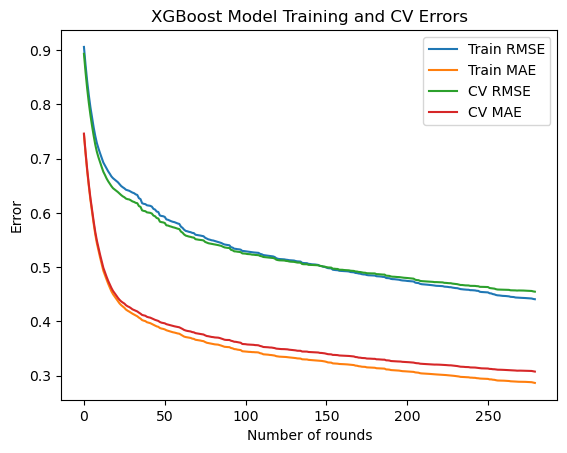

In [72]:
plot_cv_error(model)

In [73]:
# plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [74]:
evaluate_model_xgb(model, X_test, y_test)

XGBoost Model Performance
R2 Score:  0.39566640483259463
RMSE:  0.4613004695789977
MAE:  0.31772686936646877


In [75]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

XGBoost Model Performance
R2 Score:  0.17479211474102674
RMSE:  0.5203546634921031
MAE:  0.3295161180396668


In [76]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

XGBoost Model Performance
R2 Score:  0.14044047241732838
RMSE:  0.4559357967698349
MAE:  0.2671904931221975


In [77]:
predictions_eu, predictions_region = make_predictions(model, X_train_apply, X_test_apply)
pred_apply_eu_df, pred_apply_region_df = create_prediction_dataframes(predictions_eu, predictions_region)
df_eu_apply_target_updated, df_region_apply_target_updated = merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu_df, pred_apply_region_df)

In [78]:
print_disaggregation_metrics(y_train_apply, y_predict_pop_eu, df_eu_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 3.8776
MAE: 1.3746
R2: -44.8229

Model-based Disaggregation Metrics:
RMSE: 0.5204
MAE: 0.3295
R2: 0.1748


In [79]:
print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 0.4233
MAE: 0.2555
R2: 0.2589

Model-based Disaggregation Metrics:
RMSE: 0.4559
MAE: 0.2672
R2: 0.1404


In [80]:
# df_eu_apply_target

In [81]:
# master_input_train_df

## 2nd Iteration

In [82]:
print('The variable to disaggregate is: ', agg_var_to_disagg)

id_cluster = 0
cluster_name = cluster_names[id_cluster]
cluster_id = extract_cluster_id(cluster_name)
cluster_df = cluster_dfs[cluster_name]

# Create a new DataFrame with the first five columns
first_five_columns_df = cluster_df.iloc[:, :5].copy()

# Drop the first five columns and the 'Cluster' column from cluster_df
cluster_df = cluster_df.drop(columns=['Cluster']).iloc[:, 5:]

# Create a list of feature names from the modified DataFrame
feature_names_cluster_df = []
for col in cluster_df.columns:
    feature_names_cluster_df.append(col)

master_input_df, master_label_df, master_input_train_df, master_label_train_df, master_input_test_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu = create_master_dataframe_based_on_population_weights_v2(cluster_df, first_five_columns_df, feature_names_cluster_df, agg_var_to_disagg, region, predicted_values=df_eu_apply_target['predicted_value'])

X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, y_predict_pop_eu = prepare_data_for_cluster(cluster_id, master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

The variable to disaggregate is:  charging_stations_value
The length of all ancilliary features + the aggregated feature is:  20
The length of all ancilliary features is:  19


C:\Users\rofer\AppData\Local\Temp\ipykernel_15616\1253404897.py:119: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  master_input_df.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values
C:\Users\rofer\AppData\Local\Temp\ipykernel_15616\1253404897.py:127: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_apply_eu.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values


In [83]:
# master_input_train_df

In [84]:
# Define model parameters
model_params = {
    "objective": "reg:squarederror",
    "n_estimators": 280,
    "max_depth": 3,
    'min_child_weight': 1.660916224600812,
    "learning_rate": 0.09,
    "subsample": 0.96,
    "colsample_bytree": 0.49,
    'gamma': 0.8570781361610906,
    # "colsample_bylevel": 0.8,
    # "colsample_bynode": 0.8,
    "reg_alpha": 0.9,
    "reg_lambda": 0.82,
    # "scale_pos_weight": 1,
    # "max_delta_step": 0,
    # "booster": "gbtree",
    # "tree_method": "auto",
    # "grow_policy": "depthwise",
    # "max_leaves": 0,
    # "max_bin": 256,
    # "min_split_loss": 0,
    "eval_metric": ["rmse", "mae"],
}
# 100%|██████████| 200/200 [15:13<00:00,  4.57s/trial, best loss: 0.34964494828303005]
# Best hyperparameters: {'colsample_bytree': 0.49830551169744997, 'gamma': 0.8570781361610906, 'learning_rate': 1.0102637167744897, 'max_depth': 5, 
#                        'min_child_weight': 1.660916224600812, 'n_estimators': 108, 'reg_alpha': 0.9040503627591635, 'reg_lambda': 0.8276229758032445, 'subsample': 0.9626689595276247}
# Test RMSE: 0.5035584222555602

# Define a list of random states
random_states = [42,
                #  123,
                #  456,
                #  789
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

# Define a list of random states
random_states = [42,
                #  123,
                #  456,
                #  789
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

Training with random state: 42
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Mean Train RMSE: 0.4270, Mean CV RMSE: 0.4733
Mean Train MAE: 0.2818, Mean CV MAE: 0.3039
Mean Train R2: 0.6516
Training with random state: 42
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Mean Train RMSE: 0.4270, Mean CV RMSE: 0.4733
Mean Train MAE: 0.2818, Mean CV MAE: 0.3039
Mean Train R2: 0.6516


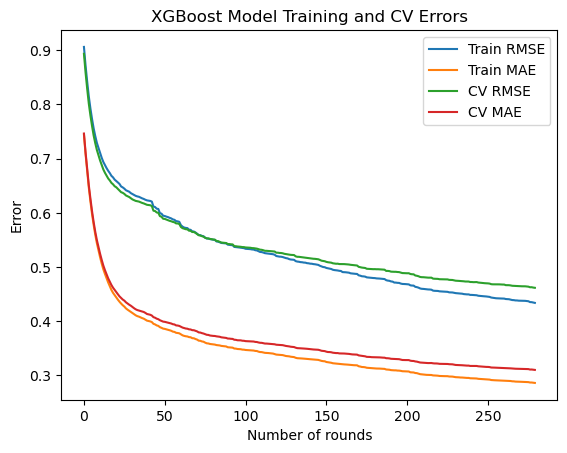

In [85]:
plot_cv_error(model)

In [86]:
# plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [87]:
evaluate_model_xgb(model, X_test, y_test)

XGBoost Model Performance
R2 Score:  0.26726927776664855
RMSE:  0.5079462150378347
MAE:  0.3365359284015673


In [88]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

XGBoost Model Performance
R2 Score:  0.11226506122349733
RMSE:  0.5397087050595736
MAE:  0.3379941820823257


In [89]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

XGBoost Model Performance
R2 Score:  -0.0726436918007829
RMSE:  0.5093231934628041
MAE:  0.2875157467802761


In [90]:
predictions_eu, predictions_region = make_predictions(model, X_train_apply, X_test_apply)
pred_apply_eu_df, pred_apply_region_df = create_prediction_dataframes(predictions_eu, predictions_region)
df_eu_apply_target_updated, df_region_apply_target_updated = merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu_df, pred_apply_region_df)

In [91]:
print_disaggregation_metrics(y_train_apply, y_predict_pop_eu, df_eu_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 3.8776
MAE: 1.3746
R2: -44.8229

Model-based Disaggregation Metrics:
RMSE: 0.5397
MAE: 0.3380
R2: 0.1123


In [92]:
print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 0.4233
MAE: 0.2555
R2: 0.2589

Model-based Disaggregation Metrics:
RMSE: 0.5093
MAE: 0.2875
R2: -0.0726


In [93]:
# df_eu_apply_target

In [94]:
# master_input_train_df

## 3rd Iteration

In [95]:
print('The variable to disaggregate is: ', agg_var_to_disagg)

id_cluster = 0
cluster_name = cluster_names[id_cluster]
cluster_id = extract_cluster_id(cluster_name)
cluster_df = cluster_dfs[cluster_name]

# Create a new DataFrame with the first five columns
first_five_columns_df = cluster_df.iloc[:, :5].copy()

# Drop the first five columns and the 'Cluster' column from cluster_df
cluster_df = cluster_df.drop(columns=['Cluster']).iloc[:, 5:]

# Create a list of feature names from the modified DataFrame
feature_names_cluster_df = []
for col in cluster_df.columns:
    feature_names_cluster_df.append(col)

The variable to disaggregate is:  charging_stations_value


In [96]:
master_input_df, master_label_df, master_input_train_df, master_label_train_df, master_input_test_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu = create_master_dataframe_based_on_population_weights_v2(cluster_df, first_five_columns_df, feature_names_cluster_df, agg_var_to_disagg, region, predicted_values=df_eu_apply_target['predicted_value'])

X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, y_predict_pop_eu = prepare_data_for_cluster(cluster_id, master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

The length of all ancilliary features + the aggregated feature is:  20
The length of all ancilliary features is:  19


C:\Users\rofer\AppData\Local\Temp\ipykernel_15616\1253404897.py:119: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  master_input_df.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values
C:\Users\rofer\AppData\Local\Temp\ipykernel_15616\1253404897.py:127: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_apply_eu.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values


In [97]:
# master_input_train_df

In [98]:
# Define model parameters
model_params = {
    "objective": "reg:squarederror",
    "n_estimators": 280,
    "max_depth": 3,
    'min_child_weight': 1.660916224600812,
    "learning_rate": 0.09,
    "subsample": 0.96,
    "colsample_bytree": 0.49,
    'gamma': 0.8570781361610906,
    # "colsample_bylevel": 0.8,
    # "colsample_bynode": 0.8,
    "reg_alpha": 0.9,
    "reg_lambda": 0.82,
    # "scale_pos_weight": 1,
    # "max_delta_step": 0,
    # "booster": "gbtree",
    # "tree_method": "auto",
    # "grow_policy": "depthwise",
    # "max_leaves": 0,
    # "max_bin": 256,
    # "min_split_loss": 0,
    "eval_metric": ["rmse", "mae"],
}
# 100%|██████████| 200/200 [15:13<00:00,  4.57s/trial, best loss: 0.34964494828303005]
# Best hyperparameters: {'colsample_bytree': 0.49830551169744997, 'gamma': 0.8570781361610906, 'learning_rate': 1.0102637167744897, 'max_depth': 5, 
#                        'min_child_weight': 1.660916224600812, 'n_estimators': 108, 'reg_alpha': 0.9040503627591635, 'reg_lambda': 0.8276229758032445, 'subsample': 0.9626689595276247}
# Test RMSE: 0.5035584222555602

# Define a list of random states
random_states = [42,
                #  123,
                #  456,
                #  789
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

# Define a list of random states
random_states = [42,
                #  123,
                #  456,
                #  789
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

Training with random state: 42
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Mean Train RMSE: 0.4305, Mean CV RMSE: 0.4785
Mean Train MAE: 0.2849, Mean CV MAE: 0.3073
Mean Train R2: 0.6458
Training with random state: 42
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Mean Train RMSE: 0.4305, Mean CV RMSE: 0.4785
Mean Train MAE: 0.2849, Mean CV MAE: 0.3073
Mean Train R2: 0.6458


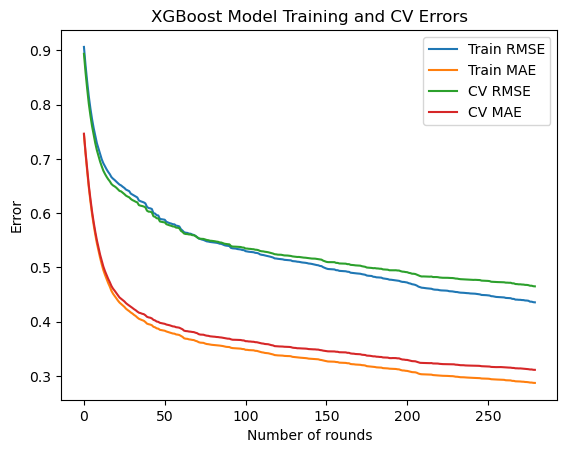

In [99]:
plot_cv_error(model)

In [100]:
# plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [101]:
evaluate_model_xgb(model, X_test, y_test)

XGBoost Model Performance
R2 Score:  -1.2004226019713449
RMSE:  0.880234885492145
MAE:  0.417464050524939


In [102]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

XGBoost Model Performance
R2 Score:  -0.5188516766490878
RMSE:  0.705952448708709
MAE:  0.37170921600156737


In [103]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

XGBoost Model Performance
R2 Score:  -2.3190911374134813
RMSE:  0.8959325202877473
MAE:  0.3796080424927795


In [104]:
predictions_eu, predictions_region = make_predictions(model, X_train_apply, X_test_apply)
pred_apply_eu_df, pred_apply_region_df = create_prediction_dataframes(predictions_eu, predictions_region)
df_eu_apply_target_updated, df_region_apply_target_updated = merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu_df, pred_apply_region_df)

In [105]:
print_disaggregation_metrics(y_train_apply, y_predict_pop_eu, df_eu_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 3.8776
MAE: 1.3746
R2: -44.8229

Model-based Disaggregation Metrics:
RMSE: 0.7060
MAE: 0.3717
R2: -0.5189


In [106]:
print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 0.4233
MAE: 0.2555
R2: 0.2589

Model-based Disaggregation Metrics:
RMSE: 0.8959
MAE: 0.3796
R2: -2.3191


In [107]:
# df_eu_apply_target

In [108]:
# master_input_train_df

## 4rd Iteration

In [109]:
print('The variable to disaggregate is: ', agg_var_to_disagg)

id_cluster = 0
cluster_name = cluster_names[id_cluster]
cluster_id = extract_cluster_id(cluster_name)
cluster_df = cluster_dfs[cluster_name]

# Create a new DataFrame with the first five columns
first_five_columns_df = cluster_df.iloc[:, :5].copy()

# Drop the first five columns and the 'Cluster' column from cluster_df
cluster_df = cluster_df.drop(columns=['Cluster']).iloc[:, 5:]

# Create a list of feature names from the modified DataFrame
feature_names_cluster_df = []
for col in cluster_df.columns:
    feature_names_cluster_df.append(col)

The variable to disaggregate is:  charging_stations_value


In [110]:
master_input_df, master_label_df, master_input_train_df, master_label_train_df, master_input_test_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu = create_master_dataframe_based_on_population_weights_v2(cluster_df, first_five_columns_df, feature_names_cluster_df, agg_var_to_disagg, region, predicted_values=df_eu_apply_target['predicted_value'])

X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, y_predict_pop_eu = prepare_data_for_cluster(cluster_id, master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

The length of all ancilliary features + the aggregated feature is:  20
The length of all ancilliary features is:  19


C:\Users\rofer\AppData\Local\Temp\ipykernel_15616\1253404897.py:119: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  master_input_df.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values
C:\Users\rofer\AppData\Local\Temp\ipykernel_15616\1253404897.py:127: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_apply_eu.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values


In [111]:
# master_input_train_df

In [112]:
# Define model parameters
model_params = {
    "objective": "reg:squarederror",
    "n_estimators": 280,
    "max_depth": 3,
    'min_child_weight': 1.660916224600812,
    "learning_rate": 0.09,
    "subsample": 0.96,
    "colsample_bytree": 0.49,
    'gamma': 0.8570781361610906,
    # "colsample_bylevel": 0.8,
    # "colsample_bynode": 0.8,
    "reg_alpha": 0.9,
    "reg_lambda": 0.82,
    # "scale_pos_weight": 1,
    # "max_delta_step": 0,
    # "booster": "gbtree",
    # "tree_method": "auto",
    # "grow_policy": "depthwise",
    # "max_leaves": 0,
    # "max_bin": 256,
    # "min_split_loss": 0,
    "eval_metric": ["rmse", "mae"],
}
# 100%|██████████| 200/200 [15:13<00:00,  4.57s/trial, best loss: 0.34964494828303005]
# Best hyperparameters: {'colsample_bytree': 0.49830551169744997, 'gamma': 0.8570781361610906, 'learning_rate': 1.0102637167744897, 'max_depth': 5, 
#                        'min_child_weight': 1.660916224600812, 'n_estimators': 108, 'reg_alpha': 0.9040503627591635, 'reg_lambda': 0.8276229758032445, 'subsample': 0.9626689595276247}
# Test RMSE: 0.5035584222555602

# Define a list of random states
random_states = [42,
                #  123,
                #  456,
                #  789
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

# Define a list of random states
random_states = [42,
                #  123,
                #  456,
                #  789
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

Training with random state: 42
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Mean Train RMSE: 0.4298, Mean CV RMSE: 0.4767
Mean Train MAE: 0.2837, Mean CV MAE: 0.3063
Mean Train R2: 0.6470
Training with random state: 42
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Mean Train RMSE: 0.4298, Mean CV RMSE: 0.4767
Mean Train MAE: 0.2837, Mean CV MAE: 0.3063
Mean Train R2: 0.6470


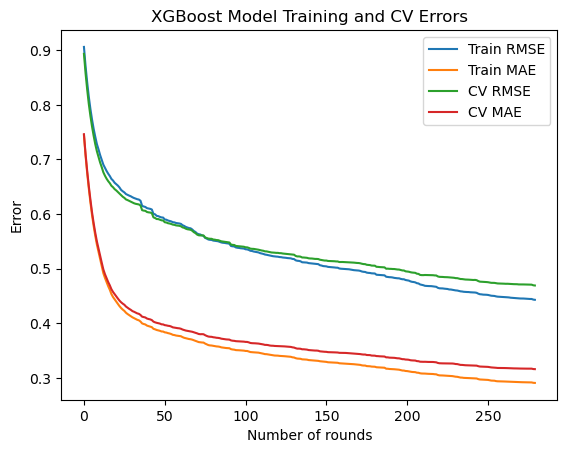

In [113]:
plot_cv_error(model)

In [114]:
# plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [115]:
evaluate_model_xgb(model, X_test, y_test)

XGBoost Model Performance
R2 Score:  -0.06242461173280245
RMSE:  0.6116381828236694
MAE:  0.3708876158745085


In [116]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

XGBoost Model Performance
R2 Score:  -0.016346986556213805
RMSE:  0.5774824208928043
MAE:  0.3476264201205926


In [117]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

XGBoost Model Performance
R2 Score:  -0.520015908913708
RMSE:  0.606303085862259
MAE:  0.310345522862574


In [118]:
predictions_eu, predictions_region = make_predictions(model, X_train_apply, X_test_apply)
pred_apply_eu_df, pred_apply_region_df = create_prediction_dataframes(predictions_eu, predictions_region)
df_eu_apply_target_updated, df_region_apply_target_updated = merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu_df, pred_apply_region_df)

In [119]:
print_disaggregation_metrics(y_train_apply, y_predict_pop_eu, df_eu_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 3.8776
MAE: 1.3746
R2: -44.8229

Model-based Disaggregation Metrics:
RMSE: 0.5775
MAE: 0.3476
R2: -0.0163


In [120]:
print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 0.4233
MAE: 0.2555
R2: 0.2589

Model-based Disaggregation Metrics:
RMSE: 0.6063
MAE: 0.3103
R2: -0.5200


In [121]:
# df_eu_apply_target

In [122]:
# master_input_train_df

## 5th Iteration

In [123]:
print('The variable to disaggregate is: ', agg_var_to_disagg)

id_cluster = 0
cluster_name = cluster_names[id_cluster]
cluster_id = extract_cluster_id(cluster_name)
cluster_df = cluster_dfs[cluster_name]

# Create a new DataFrame with the first five columns
first_five_columns_df = cluster_df.iloc[:, :5].copy()

# Drop the first five columns and the 'Cluster' column from cluster_df
cluster_df = cluster_df.drop(columns=['Cluster']).iloc[:, 5:]

# Create a list of feature names from the modified DataFrame
feature_names_cluster_df = []
for col in cluster_df.columns:
    feature_names_cluster_df.append(col)

The variable to disaggregate is:  charging_stations_value


In [124]:
master_input_df, master_label_df, master_input_train_df, master_label_train_df, master_input_test_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu = create_master_dataframe_based_on_population_weights_v2(cluster_df, first_five_columns_df, feature_names_cluster_df, agg_var_to_disagg, region, predicted_values=df_eu_apply_target['predicted_value'])

X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, y_predict_pop_eu = prepare_data_for_cluster(cluster_id, master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

The length of all ancilliary features + the aggregated feature is:  20
The length of all ancilliary features is:  19


C:\Users\rofer\AppData\Local\Temp\ipykernel_15616\1253404897.py:119: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  master_input_df.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values
C:\Users\rofer\AppData\Local\Temp\ipykernel_15616\1253404897.py:127: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_apply_eu.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values


In [125]:
# master_input_train_df

In [126]:
# Define model parameters
model_params = {
    "objective": "reg:squarederror",
    "n_estimators": 280,
    "max_depth": 3,
    'min_child_weight': 1.660916224600812,
    "learning_rate": 0.09,
    "subsample": 0.96,
    "colsample_bytree": 0.49,
    'gamma': 0.8570781361610906,
    # "colsample_bylevel": 0.8,
    # "colsample_bynode": 0.8,
    "reg_alpha": 0.9,
    "reg_lambda": 0.82,
    # "scale_pos_weight": 1,
    # "max_delta_step": 0,
    # "booster": "gbtree",
    # "tree_method": "auto",
    # "grow_policy": "depthwise",
    # "max_leaves": 0,
    # "max_bin": 256,
    # "min_split_loss": 0,
    "eval_metric": ["rmse", "mae"],
}
# 100%|██████████| 200/200 [15:13<00:00,  4.57s/trial, best loss: 0.34964494828303005]
# Best hyperparameters: {'colsample_bytree': 0.49830551169744997, 'gamma': 0.8570781361610906, 'learning_rate': 1.0102637167744897, 'max_depth': 5, 
#                        'min_child_weight': 1.660916224600812, 'n_estimators': 108, 'reg_alpha': 0.9040503627591635, 'reg_lambda': 0.8276229758032445, 'subsample': 0.9626689595276247}
# Test RMSE: 0.5035584222555602

# Define a list of random states
random_states = [42,
                #  123,
                #  456,
                #  789
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

# Define a list of random states
random_states = [42,
                #  123,
                #  456,
                #  789
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

Training with random state: 42
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Mean Train RMSE: 0.4319, Mean CV RMSE: 0.4725
Mean Train MAE: 0.2816, Mean CV MAE: 0.3030
Mean Train R2: 0.6436
Training with random state: 42
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Mean Train RMSE: 0.4319, Mean CV RMSE: 0.4725
Mean Train MAE: 0.2816, Mean CV MAE: 0.3030
Mean Train R2: 0.6436


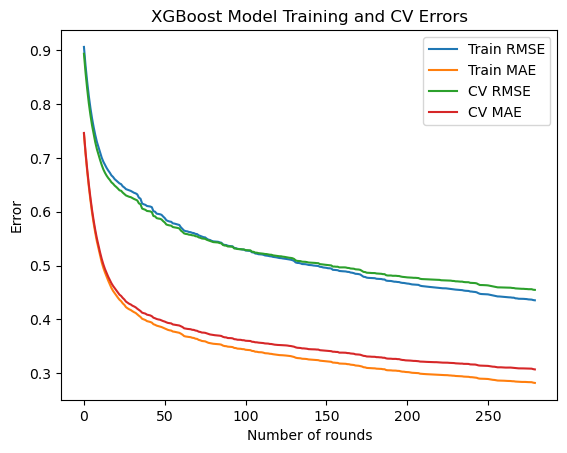

In [127]:
plot_cv_error(model)

In [128]:
# plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [129]:
evaluate_model_xgb(model, X_test, y_test)

XGBoost Model Performance
R2 Score:  0.3608535438036974
RMSE:  0.4744011362717976
MAE:  0.3210225064960651


In [130]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

XGBoost Model Performance
R2 Score:  0.18442030513290963
RMSE:  0.517310113374025
MAE:  0.32761775341429844


In [131]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

XGBoost Model Performance
R2 Score:  0.09654890950753836
RMSE:  0.46743156371293854
MAE:  0.2709219980206211


In [132]:
predictions_eu, predictions_region = make_predictions(model, X_train_apply, X_test_apply)
pred_apply_eu_df, pred_apply_region_df = create_prediction_dataframes(predictions_eu, predictions_region)
df_eu_apply_target_updated, df_region_apply_target_updated = merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu_df, pred_apply_region_df)

In [133]:
print_disaggregation_metrics(y_train_apply, y_predict_pop_eu, df_eu_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 3.8776
MAE: 1.3746
R2: -44.8229

Model-based Disaggregation Metrics:
RMSE: 0.5173
MAE: 0.3276
R2: 0.1844


In [134]:
print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 0.4233
MAE: 0.2555
R2: 0.2589

Model-based Disaggregation Metrics:
RMSE: 0.4674
MAE: 0.2709
R2: 0.0965


In [135]:
# df_eu_apply_target

In [136]:
# master_input_train_df

# XGBoost Model Cluster 2

## 1st Iteration

In [207]:
print('The variable to disaggregate is: ', agg_var_to_disagg)

id_cluster = 1
cluster_name = cluster_names[id_cluster]
cluster_id = extract_cluster_id(cluster_name)
cluster_df = cluster_dfs[cluster_name]

# Check if cluster exists
cluster_df_region = cluster_df.loc[cluster_df['NUTS0_region_code'] == region, :].copy()

try:
    if cluster_df_region.empty:
        warnings.warn(f"The cluster doesn't contain the region '{region}'.")
        # Stop the runtime (you can also remove this line if you want the code to continue executing)
        raise SystemExit("The cluster doesn't contain the specified region.")
except SystemExit as e:
    print(e)

# Create a new DataFrame with the first five columns
first_five_columns_df = cluster_df.iloc[:, :5].copy()

# Drop the first five columns and the 'Cluster' column from cluster_df
cluster_df = cluster_df.drop(columns=['Cluster']).iloc[:, 5:]

# Create a list of feature names from the modified DataFrame
feature_names_cluster_df = []
for col in cluster_df.columns:
    feature_names_cluster_df.append(col)

The variable to disaggregate is:  charging_stations_value


In [208]:
master_input_df, master_label_df, master_input_train_df, master_label_train_df, master_input_test_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu = create_master_dataframe_based_on_population_weights_v2(cluster_df, first_five_columns_df, feature_names_cluster_df, agg_var_to_disagg, region)

X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, y_predict_pop_eu = prepare_data_for_cluster(cluster_id, master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

The length of all ancilliary features + the aggregated feature is:  20
The length of all ancilliary features is:  19


In [209]:
# Define model parameters
model_params = {
    "objective": "reg:squarederror",
    "n_estimators": 280,
    "max_depth": 3,
    'min_child_weight': 1.660916224600812,
    "learning_rate": 0.09,
    "subsample": 0.96,
    "colsample_bytree": 0.49,
    'gamma': 0.8570781361610906,
    # "colsample_bylevel": 0.8,
    # "colsample_bynode": 0.8,
    "reg_alpha": 0.9,
    "reg_lambda": 0.82,
    # "scale_pos_weight": 1,
    # "max_delta_step": 0,
    # "booster": "gbtree",
    # "tree_method": "auto",
    # "grow_policy": "depthwise",
    # "max_leaves": 0,
    # "max_bin": 256,
    # "min_split_loss": 0,
    "eval_metric": ["rmse", "mae"],
}

# Define a list of random states
random_states = [47,
                #  123,
                #  456,
                #  789
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

Training with random state: 47
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Mean Train RMSE: 0.8570, Mean CV RMSE: 1.2083
Mean Train MAE: 0.5820, Mean CV MAE: 0.7648
Mean Train R2: 0.7543


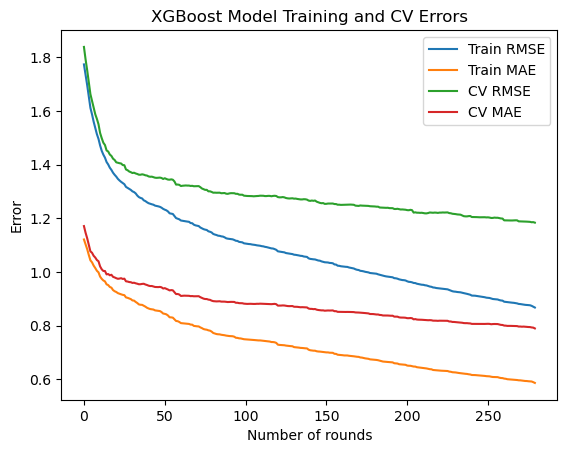

In [210]:
plot_cv_error(model)

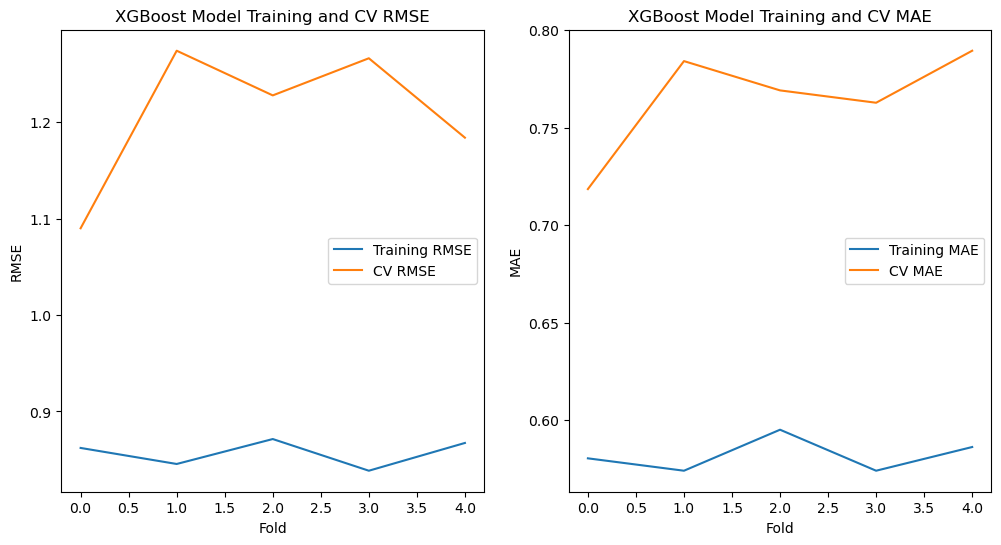

In [211]:
plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [212]:
evaluate_model_xgb(model, X_test, y_test)

XGBoost Model Performance
R2 Score:  0.20624140645960343
RMSE:  1.9626985761337745
MAE:  1.5544537250926558


In [213]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

XGBoost Model Performance
R2 Score:  -0.369091187419214
RMSE:  2.0451622877954807
MAE:  1.3668113760822738


In [214]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

XGBoost Model Performance
R2 Score:  -0.16712221120017023
RMSE:  3.2235447223935516
MAE:  2.6165643197562556


In [215]:
predictions_eu, predictions_region = make_predictions(model, X_train_apply, X_test_apply)
pred_apply_eu_df, pred_apply_region_df = create_prediction_dataframes(predictions_eu, predictions_region)
df_eu_apply_target_updated, df_region_apply_target_updated = merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu_df, pred_apply_region_df)

In [216]:
print_disaggregation_metrics(y_train_apply, y_predict_pop_eu, df_eu_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 1.7493
MAE: 1.1643
R2: -0.0016

Model-based Disaggregation Metrics:
RMSE: 2.0452
MAE: 1.3668
R2: -0.3691


In [217]:
print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 2.4250
MAE: 2.0233
R2: 0.3395

Model-based Disaggregation Metrics:
RMSE: 3.2235
MAE: 2.6166
R2: -0.1671


In [218]:
df_eu_apply_target

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
10               EU                AT               AT1              AT13   
21               EU                AT               AT3              AT31   
35               EU                BE               BE1              BE10   
36               EU                BE               BE2              BE21   
97               EU                BG               BG4              BG41   
...             ...               ...               ...               ...   
1118             EU                RO               RO3              RO32   
1129             EU                SE               SE1              SE11   
1140             EU                SE               SE2              SE22   
1142             EU                SE               SE2              SE23   
1162             EU                SK               SK0              SK01   

     NUTS3_region_code  target_variable  index  predicted_value  
10               AT130           6.0014     10           2.2211  
21               AT312           1.3223     21           0.7663  
35               BE100           1.2416     35           2.0683  
36               BE211           1.8179     36           1.7414  
97               BG411          -0.3142     97           0.7718  
...                ...              ...    ...              ...  
1118             RO321          -0.2681   1118           1.9439  
1129             SE110           0.8498   1129           3.4965  
1140             SE224           0.1237   1140           1.7619  
1142             SE232           0.7000   1142           2.1527  
1162             SK010           0.8037   1162           0.9243  

[144 rows x 8 columns]

In [219]:
master_input_train_df

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0                EU                AT               AT1              AT13   
1                EU                AT               AT3              AT31   
2                EU                BE               BE1              BE10   
3                EU                BE               BE2              BE21   
4                EU                BG               BG4              BG41   
...             ...               ...               ...               ...   
2731             EU                RO               RO3              RO32   
2732             EU                SE               SE1              SE11   
2733             EU                SE               SE2              SE22   
2734             EU                SE               SE2              SE23   
2735             EU                SK               SK0              SK01   

     NUTS3_region_code  gross domestic product_va..._0  \
0                AT130                          4.5707   
1                AT312                          0.6359   
2                BE100                          3.0647   
3                BE211                          2.4687   
4                BG411                          0.6849   
...                ...                             ...   
2731             RO321                          2.0686   
2732             SE110                          6.6217   
2733             SE224                          2.0379   
2734             SE232                          3.2430   
2735             SK010                          0.6900   

      bicycle_stations_value   UMAP8  number of pixels with min..._3  UMAP19  \
0                     1.8653 -1.5913                         -0.5675  1.1443   
1                    -0.2173 -0.9127                          0.7529  0.3459   
2                     4.9238 -1.0565                          1.2810  0.7408   
3                     4.3995 -1.0850                          0.0749  0.4320   
4                    -0.3630 -0.9443                          0.0986  0.5697   
...                      ...     ...                             ...     ...   
2731                 -0.0426 -1.4176                         -0.5126  1.0279   
2732                  0.0739 -1.6407                          0.8333  1.0740   
2733                  1.3847 -1.5894                          0.5253  0.9988   
2734                  1.5741 -1.5430                          1.0626  0.9650   
2735                  2.1712 -0.6212                         -0.2532  0.3000   

      ...  UMAP3  railway_station_value  gross value added_value  \
0     ... 1.1148                 5.9055                   4.1733   
1     ... 0.6087                 1.0370                   1.0123   
2     ... 0.6817                 4.9863                   3.5757   
3     ... 0.5553                 1.2965                   1.9282   
4     ... 0.5950                 0.7292                   0.6395   
...   ...    ...                    ...                      ...   
2731  ... 0.9458                 1.6527                   2.0909   
2732  ... 1.2302                 3.1524                   6.5501   
2733  ... 1.2452                 1.2129                   2.0131   
2734  ... 1.2201                 2.5983                   3.2059   
2735  ... 0.3983                 0.6236                   0.6868   

      total employment_value  number of pixels with ind..._15  \
0                     3.5478                           0.2713   
1                     0.7978                           1.3779   
2                     2.1523                          -0.1758   
3                     1.2797                           1.1439   
4                     3.1787                           1.1445   
...                      ...                              ...   
2731                  3.6228                           0.3400   
2732                  4.6762                           1.7015   
2733                

## 2nd Iteration

In [220]:
print('The variable to disaggregate is: ', agg_var_to_disagg)

id_cluster = 1
cluster_name = cluster_names[id_cluster]
cluster_id = extract_cluster_id(cluster_name)
cluster_df = cluster_dfs[cluster_name]

# Create a new DataFrame with the first five columns
first_five_columns_df = cluster_df.iloc[:, :5].copy()

# Drop the first five columns and the 'Cluster' column from cluster_df
cluster_df = cluster_df.drop(columns=['Cluster']).iloc[:, 5:]

# Create a list of feature names from the modified DataFrame
feature_names_cluster_df = []
for col in cluster_df.columns:
    feature_names_cluster_df.append(col)

The variable to disaggregate is:  charging_stations_value


In [221]:
master_input_df, master_label_df, master_input_train_df, master_label_train_df, master_input_test_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu = create_master_dataframe_based_on_population_weights_v2(cluster_df, first_five_columns_df, feature_names_cluster_df, agg_var_to_disagg, region, predicted_values=df_eu_apply_target['predicted_value'])

X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, y_predict_pop_eu = prepare_data_for_cluster(cluster_id, master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

The length of all ancilliary features + the aggregated feature is:  20
The length of all ancilliary features is:  19


C:\Users\rofer\AppData\Local\Temp\ipykernel_15616\1253404897.py:119: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  master_input_df.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values
C:\Users\rofer\AppData\Local\Temp\ipykernel_15616\1253404897.py:127: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_apply_eu.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values


In [222]:
master_input_train_df

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0                EU                AT               AT1              AT13   
1                EU                AT               AT3              AT31   
2                EU                BE               BE1              BE10   
3                EU                BE               BE2              BE21   
4                EU                BG               BG4              BG41   
...             ...               ...               ...               ...   
2731             EU                RO               RO3              RO32   
2732             EU                SE               SE1              SE11   
2733             EU                SE               SE2              SE22   
2734             EU                SE               SE2              SE23   
2735             EU                SK               SK0              SK01   

     NUTS3_region_code  gross domestic product_va..._0  \
0                AT130                          4.5707   
1                AT312                          0.6359   
2                BE100                          3.0647   
3                BE211                          2.4687   
4                BG411                          0.6849   
...                ...                             ...   
2731             RO321                          2.0686   
2732             SE110                          6.6217   
2733             SE224                          2.0379   
2734             SE232                          3.2430   
2735             SK010                          0.6900   

      bicycle_stations_value   UMAP8  number of pixels with min..._3  UMAP19  \
0                     1.8653 -1.5913                         -0.5675  1.1443   
1                    -0.2173 -0.9127                          0.7529  0.3459   
2                     4.9238 -1.0565                          1.2810  0.7408   
3                     4.3995 -1.0850                          0.0749  0.4320   
4                    -0.3630 -0.9443                          0.0986  0.5697   
...                      ...     ...                             ...     ...   
2731                 -0.0426 -1.4176                         -0.5126  1.0279   
2732                  0.0739 -1.6407                          0.8333  1.0740   
2733                  1.3847 -1.5894                          0.5253  0.9988   
2734                  1.5741 -1.5430                          1.0626  0.9650   
2735                  2.1712 -0.6212                         -0.2532  0.3000   

      ...  UMAP3  railway_station_value  gross value added_value  \
0     ... 1.1148                 5.9055                   4.1733   
1     ... 0.6087                 1.0370                   1.0123   
2     ... 0.6817                 4.9863                   3.5757   
3     ... 0.5553                 1.2965                   1.9282   
4     ... 0.5950                 0.7292                   0.6395   
...   ...    ...                    ...                      ...   
2731  ... 0.9458                 1.6527                   2.0909   
2732  ... 1.2302                 3.1524                   6.5501   
2733  ... 1.2452                 1.2129                   2.0131   
2734  ... 1.2201                 2.5983                   3.2059   
2735  ... 0.3983                 0.6236                   0.6868   

      total employment_value  number of pixels with ind..._15  \
0                     3.5478                           0.2713   
1                     0.7978                           1.3779   
2                     2.1523                          -0.1758   
3                     1.2797                           1.1439   
4                     3.1787                           1.1445   
...                      ...                              ...   
2731                  3.6228                           0.3400   
2732                  4.6762                           1.7015   
2733                

In [223]:
# Define model parameters
model_params = {
    "objective": "reg:squarederror",
    "n_estimators": 280,
    "max_depth": 3,
    'min_child_weight': 1.660916224600812,
    "learning_rate": 0.09,
    "subsample": 0.96,
    "colsample_bytree": 0.49,
    'gamma': 0.8570781361610906,
    # "colsample_bylevel": 0.8,
    # "colsample_bynode": 0.8,
    "reg_alpha": 0.9,
    "reg_lambda": 0.82,
    # "scale_pos_weight": 1,
    # "max_delta_step": 0,
    # "booster": "gbtree",
    # "tree_method": "auto",
    # "grow_policy": "depthwise",
    # "max_leaves": 0,
    # "max_bin": 256,
    # "min_split_loss": 0,
    "eval_metric": ["rmse", "mae"],
}

# Define a list of random states
random_states = [48,
                #  123,
                #  456,
                #  789
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

Training with random state: 48
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Mean Train RMSE: 0.8450, Mean CV RMSE: 1.2081
Mean Train MAE: 0.5708, Mean CV MAE: 0.7543
Mean Train R2: 0.7612


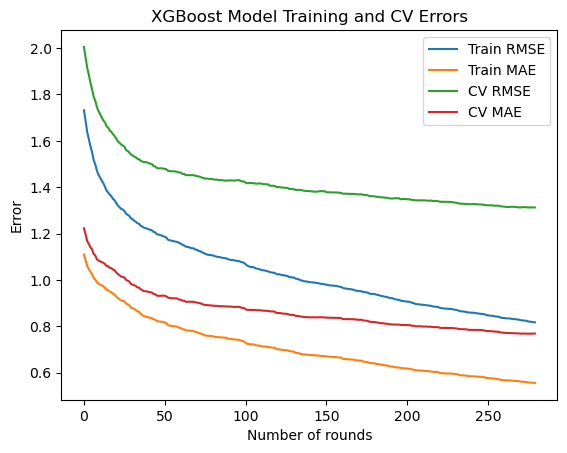

In [224]:
plot_cv_error(model)

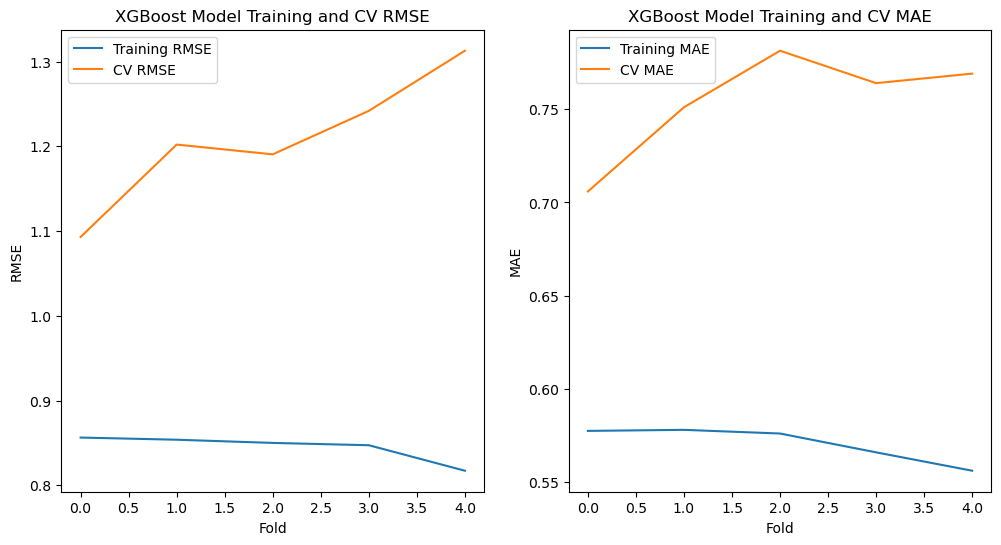

In [225]:
plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [226]:
evaluate_model_xgb(model, X_test, y_test)

XGBoost Model Performance
R2 Score:  0.23614814484319324
RMSE:  1.9253689164154664
MAE:  1.4823379139940969


In [227]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

XGBoost Model Performance
R2 Score:  -0.4391665054256406
RMSE:  2.0968487729462812
MAE:  1.4425868252081422


In [228]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

XGBoost Model Performance
R2 Score:  0.11358104538506464
RMSE:  2.8092801457982413
MAE:  2.4064893766946285


In [229]:
predictions_eu, predictions_region = make_predictions(model, X_train_apply, X_test_apply)
pred_apply_eu_df, pred_apply_region_df = create_prediction_dataframes(predictions_eu, predictions_region)
df_eu_apply_target_updated, df_region_apply_target_updated = merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu_df, pred_apply_region_df)

In [230]:
print_disaggregation_metrics(y_train_apply, y_predict_pop_eu, df_eu_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 1.7493
MAE: 1.1643
R2: -0.0016

Model-based Disaggregation Metrics:
RMSE: 2.0968
MAE: 1.4426
R2: -0.4392


In [231]:
print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 2.4250
MAE: 2.0233
R2: 0.3395

Model-based Disaggregation Metrics:
RMSE: 2.8093
MAE: 2.4065
R2: 0.1136


In [232]:
df_eu_apply_target

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
10               EU                AT               AT1              AT13   
21               EU                AT               AT3              AT31   
35               EU                BE               BE1              BE10   
36               EU                BE               BE2              BE21   
97               EU                BG               BG4              BG41   
...             ...               ...               ...               ...   
1118             EU                RO               RO3              RO32   
1129             EU                SE               SE1              SE11   
1140             EU                SE               SE2              SE22   
1142             EU                SE               SE2              SE23   
1162             EU                SK               SK0              SK01   

     NUTS3_region_code  target_variable  index  predicted_value  
10               AT130           6.0014     10           3.4368  
21               AT312           1.3223     21           0.5752  
35               BE100           1.2416     35           3.1173  
36               BE211           1.8179     36           1.4130  
97               BG411          -0.3142     97           1.0308  
...                ...              ...    ...              ...  
1118             RO321          -0.2681   1118           1.8346  
1129             SE110           0.8498   1129           5.8866  
1140             SE224           0.1237   1140           1.6603  
1142             SE232           0.7000   1142           2.6667  
1162             SK010           0.8037   1162           1.3016  

[144 rows x 8 columns]

In [233]:
master_input_train_df

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0                EU                AT               AT1              AT13   
1                EU                AT               AT3              AT31   
2                EU                BE               BE1              BE10   
3                EU                BE               BE2              BE21   
4                EU                BG               BG4              BG41   
...             ...               ...               ...               ...   
2731             EU                RO               RO3              RO32   
2732             EU                SE               SE1              SE11   
2733             EU                SE               SE2              SE22   
2734             EU                SE               SE2              SE23   
2735             EU                SK               SK0              SK01   

     NUTS3_region_code  gross domestic product_va..._0  \
0                AT130                          4.5707   
1                AT312                          0.6359   
2                BE100                          3.0647   
3                BE211                          2.4687   
4                BG411                          0.6849   
...                ...                             ...   
2731             RO321                          2.0686   
2732             SE110                          6.6217   
2733             SE224                          2.0379   
2734             SE232                          3.2430   
2735             SK010                          0.6900   

      bicycle_stations_value   UMAP8  number of pixels with min..._3  UMAP19  \
0                     1.8653 -1.5913                         -0.5675  1.1443   
1                    -0.2173 -0.9127                          0.7529  0.3459   
2                     4.9238 -1.0565                          1.2810  0.7408   
3                     4.3995 -1.0850                          0.0749  0.4320   
4                    -0.3630 -0.9443                          0.0986  0.5697   
...                      ...     ...                             ...     ...   
2731                 -0.0426 -1.4176                         -0.5126  1.0279   
2732                  0.0739 -1.6407                          0.8333  1.0740   
2733                  1.3847 -1.5894                          0.5253  0.9988   
2734                  1.5741 -1.5430                          1.0626  0.9650   
2735                  2.1712 -0.6212                         -0.2532  0.3000   

      ...  UMAP3  railway_station_value  gross value added_value  \
0     ... 1.1148                 5.9055                   4.1733   
1     ... 0.6087                 1.0370                   1.0123   
2     ... 0.6817                 4.9863                   3.5757   
3     ... 0.5553                 1.2965                   1.9282   
4     ... 0.5950                 0.7292                   0.6395   
...   ...    ...                    ...                      ...   
2731  ... 0.9458                 1.6527                   2.0909   
2732  ... 1.2302                 3.1524                   6.5501   
2733  ... 1.2452                 1.2129                   2.0131   
2734  ... 1.2201                 2.5983                   3.2059   
2735  ... 0.3983                 0.6236                   0.6868   

      total employment_value  number of pixels with ind..._15  \
0                     3.5478                           0.2713   
1                     0.7978                           1.3779   
2                     2.1523                          -0.1758   
3                     1.2797                           1.1439   
4                     3.1787                           1.1445   
...                      ...                              ...   
2731                  3.6228                           0.3400   
2732                  4.6762                           1.7015   
2733                

## 3rd Iteration

In [234]:
print('The variable to disaggregate is: ', agg_var_to_disagg)

id_cluster = 1
cluster_name = cluster_names[id_cluster]
cluster_id = extract_cluster_id(cluster_name)
cluster_df = cluster_dfs[cluster_name]

# Create a new DataFrame with the first five columns
first_five_columns_df = cluster_df.iloc[:, :5].copy()

# Drop the first five columns and the 'Cluster' column from cluster_df
cluster_df = cluster_df.drop(columns=['Cluster']).iloc[:, 5:]

# Create a list of feature names from the modified DataFrame
feature_names_cluster_df = []
for col in cluster_df.columns:
    feature_names_cluster_df.append(col)

The variable to disaggregate is:  charging_stations_value


In [235]:
master_input_df, master_label_df, master_input_train_df, master_label_train_df, master_input_test_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu = create_master_dataframe_based_on_population_weights_v2(cluster_df, first_five_columns_df, feature_names_cluster_df, agg_var_to_disagg, region, predicted_values=df_eu_apply_target['predicted_value'])

X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, y_predict_pop_eu = prepare_data_for_cluster(cluster_id, master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

The length of all ancilliary features + the aggregated feature is:  20
The length of all ancilliary features is:  19


C:\Users\rofer\AppData\Local\Temp\ipykernel_15616\1253404897.py:119: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  master_input_df.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values
C:\Users\rofer\AppData\Local\Temp\ipykernel_15616\1253404897.py:127: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_apply_eu.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values


In [236]:
master_input_train_df

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0                EU                AT               AT1              AT13   
1                EU                AT               AT3              AT31   
2                EU                BE               BE1              BE10   
3                EU                BE               BE2              BE21   
4                EU                BG               BG4              BG41   
...             ...               ...               ...               ...   
2731             EU                RO               RO3              RO32   
2732             EU                SE               SE1              SE11   
2733             EU                SE               SE2              SE22   
2734             EU                SE               SE2              SE23   
2735             EU                SK               SK0              SK01   

     NUTS3_region_code  gross domestic product_va..._0  \
0                AT130                          4.5707   
1                AT312                          0.6359   
2                BE100                          3.0647   
3                BE211                          2.4687   
4                BG411                          0.6849   
...                ...                             ...   
2731             RO321                          2.0686   
2732             SE110                          6.6217   
2733             SE224                          2.0379   
2734             SE232                          3.2430   
2735             SK010                          0.6900   

      bicycle_stations_value   UMAP8  number of pixels with min..._3  UMAP19  \
0                     1.8653 -1.5913                         -0.5675  1.1443   
1                    -0.2173 -0.9127                          0.7529  0.3459   
2                     4.9238 -1.0565                          1.2810  0.7408   
3                     4.3995 -1.0850                          0.0749  0.4320   
4                    -0.3630 -0.9443                          0.0986  0.5697   
...                      ...     ...                             ...     ...   
2731                 -0.0426 -1.4176                         -0.5126  1.0279   
2732                  0.0739 -1.6407                          0.8333  1.0740   
2733                  1.3847 -1.5894                          0.5253  0.9988   
2734                  1.5741 -1.5430                          1.0626  0.9650   
2735                  2.1712 -0.6212                         -0.2532  0.3000   

      ...  UMAP3  railway_station_value  gross value added_value  \
0     ... 1.1148                 5.9055                   4.1733   
1     ... 0.6087                 1.0370                   1.0123   
2     ... 0.6817                 4.9863                   3.5757   
3     ... 0.5553                 1.2965                   1.9282   
4     ... 0.5950                 0.7292                   0.6395   
...   ...    ...                    ...                      ...   
2731  ... 0.9458                 1.6527                   2.0909   
2732  ... 1.2302                 3.1524                   6.5501   
2733  ... 1.2452                 1.2129                   2.0131   
2734  ... 1.2201                 2.5983                   3.2059   
2735  ... 0.3983                 0.6236                   0.6868   

      total employment_value  number of pixels with ind..._15  \
0                     3.5478                           0.2713   
1                     0.7978                           1.3779   
2                     2.1523                          -0.1758   
3                     1.2797                           1.1439   
4                     3.1787                           1.1445   
...                      ...                              ...   
2731                  3.6228                           0.3400   
2732                  4.6762                           1.7015   
2733                

In [237]:
# Define model parameters
model_params = {
    "objective": "reg:squarederror",
    "n_estimators": 280,
    "max_depth": 3,
    'min_child_weight': 1.660916224600812,
    "learning_rate": 0.09,
    "subsample": 0.96,
    "colsample_bytree": 0.49,
    'gamma': 0.8570781361610906,
    # "colsample_bylevel": 0.8,
    # "colsample_bynode": 0.8,
    "reg_alpha": 0.9,
    "reg_lambda": 0.82,
    # "scale_pos_weight": 1,
    # "max_delta_step": 0,
    # "booster": "gbtree",
    # "tree_method": "auto",
    # "grow_policy": "depthwise",
    # "max_leaves": 0,
    # "max_bin": 256,
    # "min_split_loss": 0,
    "eval_metric": ["rmse", "mae"],
}

# Define a list of random states
random_states = [49,
                #  123,
                #  456,
                #  789
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

Training with random state: 49
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Mean Train RMSE: 0.8342, Mean CV RMSE: 1.1999
Mean Train MAE: 0.5664, Mean CV MAE: 0.7528
Mean Train R2: 0.7671


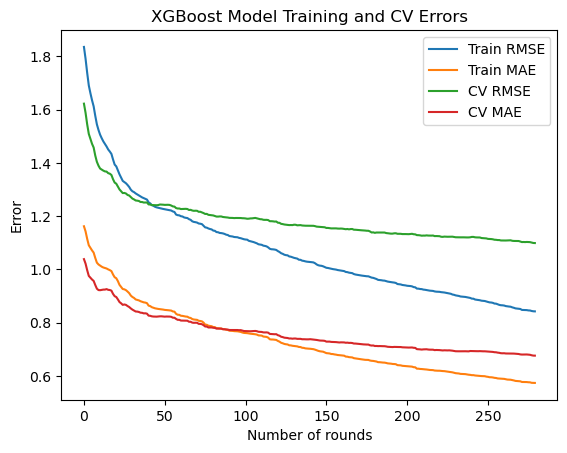

In [238]:
plot_cv_error(model)

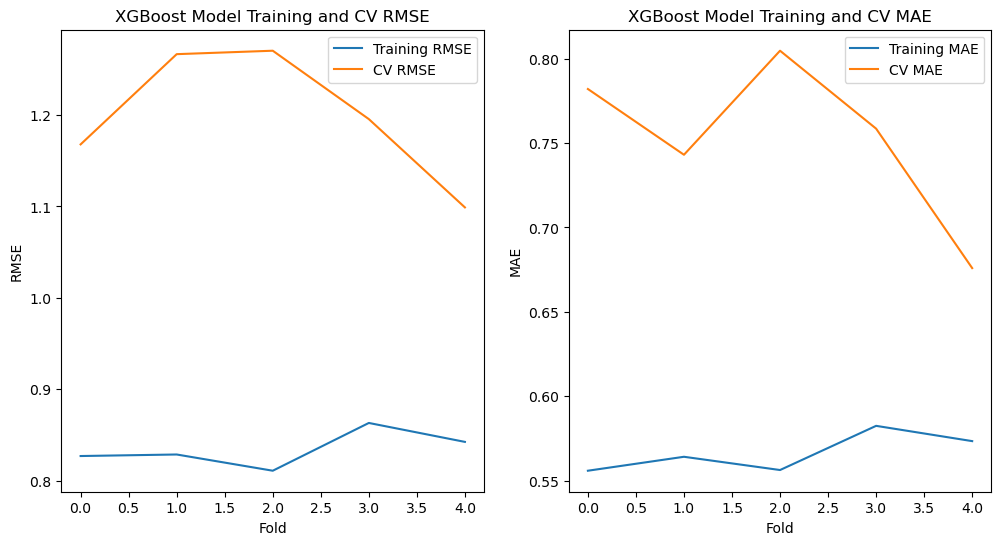

In [239]:
plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [240]:
evaluate_model_xgb(model, X_test, y_test)

XGBoost Model Performance
R2 Score:  0.1982614641558531
RMSE:  1.972539763157129
MAE:  1.583568423129004


In [241]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

XGBoost Model Performance
R2 Score:  -0.5386866627057008
RMSE:  2.1681368110633237
MAE:  1.4515959828006488


In [242]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

XGBoost Model Performance
R2 Score:  0.15066848913050446
RMSE:  2.749882589379264
MAE:  2.0351852620350015


In [243]:
predictions_eu, predictions_region = make_predictions(model, X_train_apply, X_test_apply)
pred_apply_eu_df, pred_apply_region_df = create_prediction_dataframes(predictions_eu, predictions_region)
df_eu_apply_target_updated, df_region_apply_target_updated = merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu_df, pred_apply_region_df)

In [244]:
print_disaggregation_metrics(y_train_apply, y_predict_pop_eu, df_eu_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 1.7493
MAE: 1.1643
R2: -0.0016

Model-based Disaggregation Metrics:
RMSE: 2.1681
MAE: 1.4516
R2: -0.5387


In [245]:
print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 2.4250
MAE: 2.0233
R2: 0.3395

Model-based Disaggregation Metrics:
RMSE: 2.7499
MAE: 2.0352
R2: 0.1507


In [246]:
df_eu_apply_target

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
10               EU                AT               AT1              AT13   
21               EU                AT               AT3              AT31   
35               EU                BE               BE1              BE10   
36               EU                BE               BE2              BE21   
97               EU                BG               BG4              BG41   
...             ...               ...               ...               ...   
1118             EU                RO               RO3              RO32   
1129             EU                SE               SE1              SE11   
1140             EU                SE               SE2              SE22   
1142             EU                SE               SE2              SE23   
1162             EU                SK               SK0              SK01   

     NUTS3_region_code  target_variable  index  predicted_value  
10               AT130           6.0014     10           3.7593  
21               AT312           1.3223     21           0.6290  
35               BE100           1.2416     35           3.0460  
36               BE211           1.8179     36           1.6828  
97               BG411          -0.3142     97           0.8001  
...                ...              ...    ...              ...  
1118             RO321          -0.2681   1118           1.8344  
1129             SE110           0.8498   1129           5.9964  
1140             SE224           0.1237   1140           1.7080  
1142             SE232           0.7000   1142           2.4645  
1162             SK010           0.8037   1162           0.7163  

[144 rows x 8 columns]

In [247]:
master_input_train_df

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0                EU                AT               AT1              AT13   
1                EU                AT               AT3              AT31   
2                EU                BE               BE1              BE10   
3                EU                BE               BE2              BE21   
4                EU                BG               BG4              BG41   
...             ...               ...               ...               ...   
2731             EU                RO               RO3              RO32   
2732             EU                SE               SE1              SE11   
2733             EU                SE               SE2              SE22   
2734             EU                SE               SE2              SE23   
2735             EU                SK               SK0              SK01   

     NUTS3_region_code  gross domestic product_va..._0  \
0                AT130                          4.5707   
1                AT312                          0.6359   
2                BE100                          3.0647   
3                BE211                          2.4687   
4                BG411                          0.6849   
...                ...                             ...   
2731             RO321                          2.0686   
2732             SE110                          6.6217   
2733             SE224                          2.0379   
2734             SE232                          3.2430   
2735             SK010                          0.6900   

      bicycle_stations_value   UMAP8  number of pixels with min..._3  UMAP19  \
0                     1.8653 -1.5913                         -0.5675  1.1443   
1                    -0.2173 -0.9127                          0.7529  0.3459   
2                     4.9238 -1.0565                          1.2810  0.7408   
3                     4.3995 -1.0850                          0.0749  0.4320   
4                    -0.3630 -0.9443                          0.0986  0.5697   
...                      ...     ...                             ...     ...   
2731                 -0.0426 -1.4176                         -0.5126  1.0279   
2732                  0.0739 -1.6407                          0.8333  1.0740   
2733                  1.3847 -1.5894                          0.5253  0.9988   
2734                  1.5741 -1.5430                          1.0626  0.9650   
2735                  2.1712 -0.6212                         -0.2532  0.3000   

      ...  UMAP3  railway_station_value  gross value added_value  \
0     ... 1.1148                 5.9055                   4.1733   
1     ... 0.6087                 1.0370                   1.0123   
2     ... 0.6817                 4.9863                   3.5757   
3     ... 0.5553                 1.2965                   1.9282   
4     ... 0.5950                 0.7292                   0.6395   
...   ...    ...                    ...                      ...   
2731  ... 0.9458                 1.6527                   2.0909   
2732  ... 1.2302                 3.1524                   6.5501   
2733  ... 1.2452                 1.2129                   2.0131   
2734  ... 1.2201                 2.5983                   3.2059   
2735  ... 0.3983                 0.6236                   0.6868   

      total employment_value  number of pixels with ind..._15  \
0                     3.5478                           0.2713   
1                     0.7978                           1.3779   
2                     2.1523                          -0.1758   
3                     1.2797                           1.1439   
4                     3.1787                           1.1445   
...                      ...                              ...   
2731                  3.6228                           0.3400   
2732                  4.6762                           1.7015   
2733                

## 4rd Iteration

In [248]:
print('The variable to disaggregate is: ', agg_var_to_disagg)

id_cluster = 1
cluster_name = cluster_names[id_cluster]
cluster_id = extract_cluster_id(cluster_name)
cluster_df = cluster_dfs[cluster_name]

# Create a new DataFrame with the first five columns
first_five_columns_df = cluster_df.iloc[:, :5].copy()

# Drop the first five columns and the 'Cluster' column from cluster_df
cluster_df = cluster_df.drop(columns=['Cluster']).iloc[:, 5:]

# Create a list of feature names from the modified DataFrame
feature_names_cluster_df = []
for col in cluster_df.columns:
    feature_names_cluster_df.append(col)

The variable to disaggregate is:  charging_stations_value


In [249]:
master_input_df, master_label_df, master_input_train_df, master_label_train_df, master_input_test_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu = create_master_dataframe_based_on_population_weights_v2(cluster_df, first_five_columns_df, feature_names_cluster_df, agg_var_to_disagg, region, predicted_values=df_eu_apply_target['predicted_value'])

X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, y_predict_pop_eu = prepare_data_for_cluster(cluster_id, master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

The length of all ancilliary features + the aggregated feature is:  20
The length of all ancilliary features is:  19


C:\Users\rofer\AppData\Local\Temp\ipykernel_15616\1253404897.py:119: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  master_input_df.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values
C:\Users\rofer\AppData\Local\Temp\ipykernel_15616\1253404897.py:127: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_apply_eu.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values


In [250]:
master_input_train_df

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0                EU                AT               AT1              AT13   
1                EU                AT               AT3              AT31   
2                EU                BE               BE1              BE10   
3                EU                BE               BE2              BE21   
4                EU                BG               BG4              BG41   
...             ...               ...               ...               ...   
2731             EU                RO               RO3              RO32   
2732             EU                SE               SE1              SE11   
2733             EU                SE               SE2              SE22   
2734             EU                SE               SE2              SE23   
2735             EU                SK               SK0              SK01   

     NUTS3_region_code  gross domestic product_va..._0  \
0                AT130                          4.5707   
1                AT312                          0.6359   
2                BE100                          3.0647   
3                BE211                          2.4687   
4                BG411                          0.6849   
...                ...                             ...   
2731             RO321                          2.0686   
2732             SE110                          6.6217   
2733             SE224                          2.0379   
2734             SE232                          3.2430   
2735             SK010                          0.6900   

      bicycle_stations_value   UMAP8  number of pixels with min..._3  UMAP19  \
0                     1.8653 -1.5913                         -0.5675  1.1443   
1                    -0.2173 -0.9127                          0.7529  0.3459   
2                     4.9238 -1.0565                          1.2810  0.7408   
3                     4.3995 -1.0850                          0.0749  0.4320   
4                    -0.3630 -0.9443                          0.0986  0.5697   
...                      ...     ...                             ...     ...   
2731                 -0.0426 -1.4176                         -0.5126  1.0279   
2732                  0.0739 -1.6407                          0.8333  1.0740   
2733                  1.3847 -1.5894                          0.5253  0.9988   
2734                  1.5741 -1.5430                          1.0626  0.9650   
2735                  2.1712 -0.6212                         -0.2532  0.3000   

      ...  UMAP3  railway_station_value  gross value added_value  \
0     ... 1.1148                 5.9055                   4.1733   
1     ... 0.6087                 1.0370                   1.0123   
2     ... 0.6817                 4.9863                   3.5757   
3     ... 0.5553                 1.2965                   1.9282   
4     ... 0.5950                 0.7292                   0.6395   
...   ...    ...                    ...                      ...   
2731  ... 0.9458                 1.6527                   2.0909   
2732  ... 1.2302                 3.1524                   6.5501   
2733  ... 1.2452                 1.2129                   2.0131   
2734  ... 1.2201                 2.5983                   3.2059   
2735  ... 0.3983                 0.6236                   0.6868   

      total employment_value  number of pixels with ind..._15  \
0                     3.5478                           0.2713   
1                     0.7978                           1.3779   
2                     2.1523                          -0.1758   
3                     1.2797                           1.1439   
4                     3.1787                           1.1445   
...                      ...                              ...   
2731                  3.6228                           0.3400   
2732                  4.6762                           1.7015   
2733                

In [251]:
# Define model parameters
model_params = {
    "objective": "reg:squarederror",
    "n_estimators": 280,
    "max_depth": 3,
    'min_child_weight': 1.660916224600812,
    "learning_rate": 0.09,
    "subsample": 0.96,
    "colsample_bytree": 0.49,
    'gamma': 0.8570781361610906,
    # "colsample_bylevel": 0.8,
    # "colsample_bynode": 0.8,
    "reg_alpha": 0.9,
    "reg_lambda": 0.82,
    # "scale_pos_weight": 1,
    # "max_delta_step": 0,
    # "booster": "gbtree",
    # "tree_method": "auto",
    # "grow_policy": "depthwise",
    # "max_leaves": 0,
    # "max_bin": 256,
    # "min_split_loss": 0,
    "eval_metric": ["rmse", "mae"],
}

# Define a list of random states
random_states = [50,
                #  123,
                #  456,
                #  789
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

Training with random state: 50
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Mean Train RMSE: 0.8498, Mean CV RMSE: 1.1927
Mean Train MAE: 0.5761, Mean CV MAE: 0.7533
Mean Train R2: 0.7584


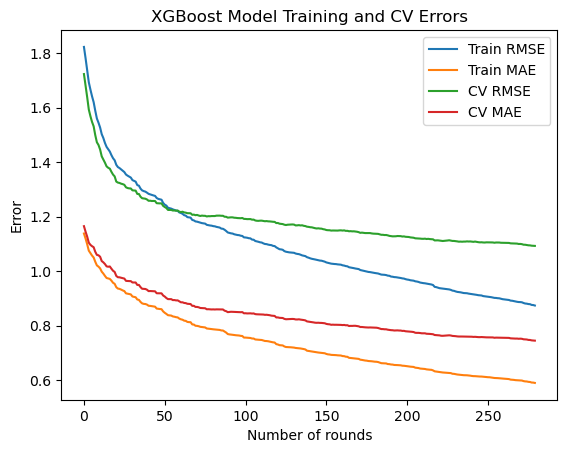

In [252]:
plot_cv_error(model)

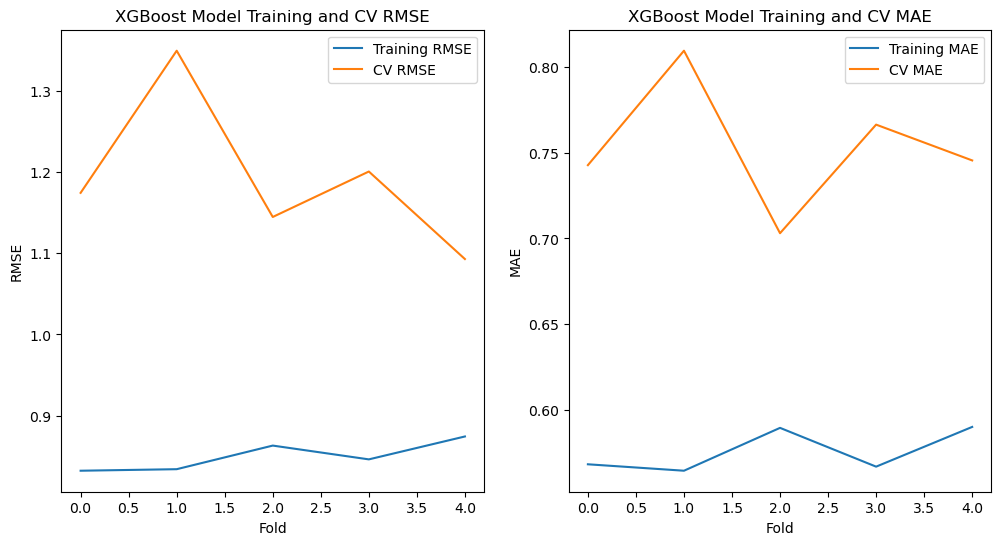

In [253]:
plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [254]:
evaluate_model_xgb(model, X_test, y_test)

XGBoost Model Performance
R2 Score:  0.34206002788512624
RMSE:  1.7869093585623954
MAE:  1.4101315131268795


In [255]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

XGBoost Model Performance
R2 Score:  -0.3577709341287878
RMSE:  2.0366895828882408
MAE:  1.3910043490810333


In [256]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

XGBoost Model Performance
R2 Score:  0.21793346845736838
RMSE:  2.6387447554799217
MAE:  2.0553005580809405


In [257]:
predictions_eu, predictions_region = make_predictions(model, X_train_apply, X_test_apply)
pred_apply_eu_df, pred_apply_region_df = create_prediction_dataframes(predictions_eu, predictions_region)
df_eu_apply_target_updated, df_region_apply_target_updated = merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu_df, pred_apply_region_df)

In [258]:
print_disaggregation_metrics(y_train_apply, y_predict_pop_eu, df_eu_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 1.7493
MAE: 1.1643
R2: -0.0016

Model-based Disaggregation Metrics:
RMSE: 2.0367
MAE: 1.3910
R2: -0.3578


In [259]:
print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 2.4250
MAE: 2.0233
R2: 0.3395

Model-based Disaggregation Metrics:
RMSE: 2.6387
MAE: 2.0553
R2: 0.2179


In [260]:
df_eu_apply_target

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
10               EU                AT               AT1              AT13   
21               EU                AT               AT3              AT31   
35               EU                BE               BE1              BE10   
36               EU                BE               BE2              BE21   
97               EU                BG               BG4              BG41   
...             ...               ...               ...               ...   
1118             EU                RO               RO3              RO32   
1129             EU                SE               SE1              SE11   
1140             EU                SE               SE2              SE22   
1142             EU                SE               SE2              SE23   
1162             EU                SK               SK0              SK01   

     NUTS3_region_code  target_variable  index  predicted_value  
10               AT130           6.0014     10           3.5404  
21               AT312           1.3223     21           0.6716  
35               BE100           1.2416     35           3.1307  
36               BE211           1.8179     36           0.9661  
97               BG411          -0.3142     97           0.7538  
...                ...              ...    ...              ...  
1118             RO321          -0.2681   1118           1.2814  
1129             SE110           0.8498   1129           5.1792  
1140             SE224           0.1237   1140           1.1947  
1142             SE232           0.7000   1142           2.6803  
1162             SK010           0.8037   1162           0.7168  

[144 rows x 8 columns]

In [261]:
master_input_train_df

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0                EU                AT               AT1              AT13   
1                EU                AT               AT3              AT31   
2                EU                BE               BE1              BE10   
3                EU                BE               BE2              BE21   
4                EU                BG               BG4              BG41   
...             ...               ...               ...               ...   
2731             EU                RO               RO3              RO32   
2732             EU                SE               SE1              SE11   
2733             EU                SE               SE2              SE22   
2734             EU                SE               SE2              SE23   
2735             EU                SK               SK0              SK01   

     NUTS3_region_code  gross domestic product_va..._0  \
0                AT130                          4.5707   
1                AT312                          0.6359   
2                BE100                          3.0647   
3                BE211                          2.4687   
4                BG411                          0.6849   
...                ...                             ...   
2731             RO321                          2.0686   
2732             SE110                          6.6217   
2733             SE224                          2.0379   
2734             SE232                          3.2430   
2735             SK010                          0.6900   

      bicycle_stations_value   UMAP8  number of pixels with min..._3  UMAP19  \
0                     1.8653 -1.5913                         -0.5675  1.1443   
1                    -0.2173 -0.9127                          0.7529  0.3459   
2                     4.9238 -1.0565                          1.2810  0.7408   
3                     4.3995 -1.0850                          0.0749  0.4320   
4                    -0.3630 -0.9443                          0.0986  0.5697   
...                      ...     ...                             ...     ...   
2731                 -0.0426 -1.4176                         -0.5126  1.0279   
2732                  0.0739 -1.6407                          0.8333  1.0740   
2733                  1.3847 -1.5894                          0.5253  0.9988   
2734                  1.5741 -1.5430                          1.0626  0.9650   
2735                  2.1712 -0.6212                         -0.2532  0.3000   

      ...  UMAP3  railway_station_value  gross value added_value  \
0     ... 1.1148                 5.9055                   4.1733   
1     ... 0.6087                 1.0370                   1.0123   
2     ... 0.6817                 4.9863                   3.5757   
3     ... 0.5553                 1.2965                   1.9282   
4     ... 0.5950                 0.7292                   0.6395   
...   ...    ...                    ...                      ...   
2731  ... 0.9458                 1.6527                   2.0909   
2732  ... 1.2302                 3.1524                   6.5501   
2733  ... 1.2452                 1.2129                   2.0131   
2734  ... 1.2201                 2.5983                   3.2059   
2735  ... 0.3983                 0.6236                   0.6868   

      total employment_value  number of pixels with ind..._15  \
0                     3.5478                           0.2713   
1                     0.7978                           1.3779   
2                     2.1523                          -0.1758   
3                     1.2797                           1.1439   
4                     3.1787                           1.1445   
...                      ...                              ...   
2731                  3.6228                           0.3400   
2732                  4.6762                           1.7015   
2733                

## 5th Iteration

In [262]:
print('The variable to disaggregate is: ', agg_var_to_disagg)

id_cluster = 1
cluster_name = cluster_names[id_cluster]
cluster_id = extract_cluster_id(cluster_name)
cluster_df = cluster_dfs[cluster_name]

# Create a new DataFrame with the first five columns
first_five_columns_df = cluster_df.iloc[:, :5].copy()

# Drop the first five columns and the 'Cluster' column from cluster_df
cluster_df = cluster_df.drop(columns=['Cluster']).iloc[:, 5:]

# Create a list of feature names from the modified DataFrame
feature_names_cluster_df = []
for col in cluster_df.columns:
    feature_names_cluster_df.append(col)

The variable to disaggregate is:  charging_stations_value


In [263]:
master_input_df, master_label_df, master_input_train_df, master_label_train_df, master_input_test_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu = create_master_dataframe_based_on_population_weights_v2(cluster_df, first_five_columns_df, feature_names_cluster_df, agg_var_to_disagg, region, predicted_values=df_eu_apply_target['predicted_value'])

X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, y_predict_pop_eu = prepare_data_for_cluster(cluster_id, master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

The length of all ancilliary features + the aggregated feature is:  20
The length of all ancilliary features is:  19


C:\Users\rofer\AppData\Local\Temp\ipykernel_15616\1253404897.py:119: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  master_input_df.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values
C:\Users\rofer\AppData\Local\Temp\ipykernel_15616\1253404897.py:127: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_apply_eu.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values


In [264]:
master_input_train_df

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0                EU                AT               AT1              AT13   
1                EU                AT               AT3              AT31   
2                EU                BE               BE1              BE10   
3                EU                BE               BE2              BE21   
4                EU                BG               BG4              BG41   
...             ...               ...               ...               ...   
2731             EU                RO               RO3              RO32   
2732             EU                SE               SE1              SE11   
2733             EU                SE               SE2              SE22   
2734             EU                SE               SE2              SE23   
2735             EU                SK               SK0              SK01   

     NUTS3_region_code  gross domestic product_va..._0  \
0                AT130                          4.5707   
1                AT312                          0.6359   
2                BE100                          3.0647   
3                BE211                          2.4687   
4                BG411                          0.6849   
...                ...                             ...   
2731             RO321                          2.0686   
2732             SE110                          6.6217   
2733             SE224                          2.0379   
2734             SE232                          3.2430   
2735             SK010                          0.6900   

      bicycle_stations_value   UMAP8  number of pixels with min..._3  UMAP19  \
0                     1.8653 -1.5913                         -0.5675  1.1443   
1                    -0.2173 -0.9127                          0.7529  0.3459   
2                     4.9238 -1.0565                          1.2810  0.7408   
3                     4.3995 -1.0850                          0.0749  0.4320   
4                    -0.3630 -0.9443                          0.0986  0.5697   
...                      ...     ...                             ...     ...   
2731                 -0.0426 -1.4176                         -0.5126  1.0279   
2732                  0.0739 -1.6407                          0.8333  1.0740   
2733                  1.3847 -1.5894                          0.5253  0.9988   
2734                  1.5741 -1.5430                          1.0626  0.9650   
2735                  2.1712 -0.6212                         -0.2532  0.3000   

      ...  UMAP3  railway_station_value  gross value added_value  \
0     ... 1.1148                 5.9055                   4.1733   
1     ... 0.6087                 1.0370                   1.0123   
2     ... 0.6817                 4.9863                   3.5757   
3     ... 0.5553                 1.2965                   1.9282   
4     ... 0.5950                 0.7292                   0.6395   
...   ...    ...                    ...                      ...   
2731  ... 0.9458                 1.6527                   2.0909   
2732  ... 1.2302                 3.1524                   6.5501   
2733  ... 1.2452                 1.2129                   2.0131   
2734  ... 1.2201                 2.5983                   3.2059   
2735  ... 0.3983                 0.6236                   0.6868   

      total employment_value  number of pixels with ind..._15  \
0                     3.5478                           0.2713   
1                     0.7978                           1.3779   
2                     2.1523                          -0.1758   
3                     1.2797                           1.1439   
4                     3.1787                           1.1445   
...                      ...                              ...   
2731                  3.6228                           0.3400   
2732                  4.6762                           1.7015   
2733                

In [265]:
# Define model parameters
model_params = {
    "objective": "reg:squarederror",
    "n_estimators": 280,
    "max_depth": 3,
    'min_child_weight': 1.660916224600812,
    "learning_rate": 0.09,
    "subsample": 0.96,
    "colsample_bytree": 0.49,
    'gamma': 0.8570781361610906,
    # "colsample_bylevel": 0.8,
    # "colsample_bynode": 0.8,
    "reg_alpha": 0.9,
    "reg_lambda": 0.82,
    # "scale_pos_weight": 1,
    # "max_delta_step": 0,
    # "booster": "gbtree",
    # "tree_method": "auto",
    # "grow_policy": "depthwise",
    # "max_leaves": 0,
    # "max_bin": 256,
    # "min_split_loss": 0,
    "eval_metric": ["rmse", "mae"],
}

# Define a list of random states
random_states = [51,
                #  123,
                #  456,
                #  789
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

Training with random state: 51
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Mean Train RMSE: 0.8459, Mean CV RMSE: 1.1820
Mean Train MAE: 0.5716, Mean CV MAE: 0.7465
Mean Train R2: 0.7607


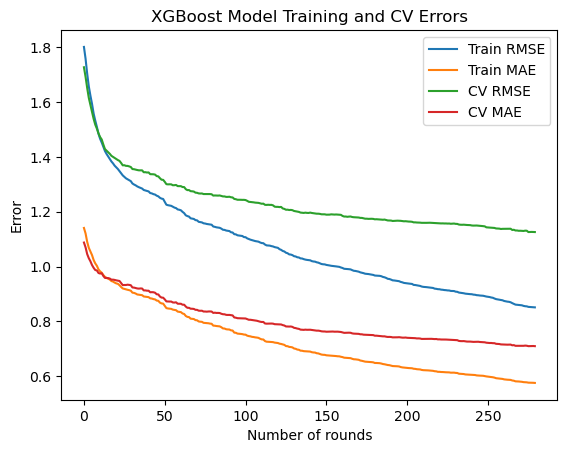

In [266]:
plot_cv_error(model)

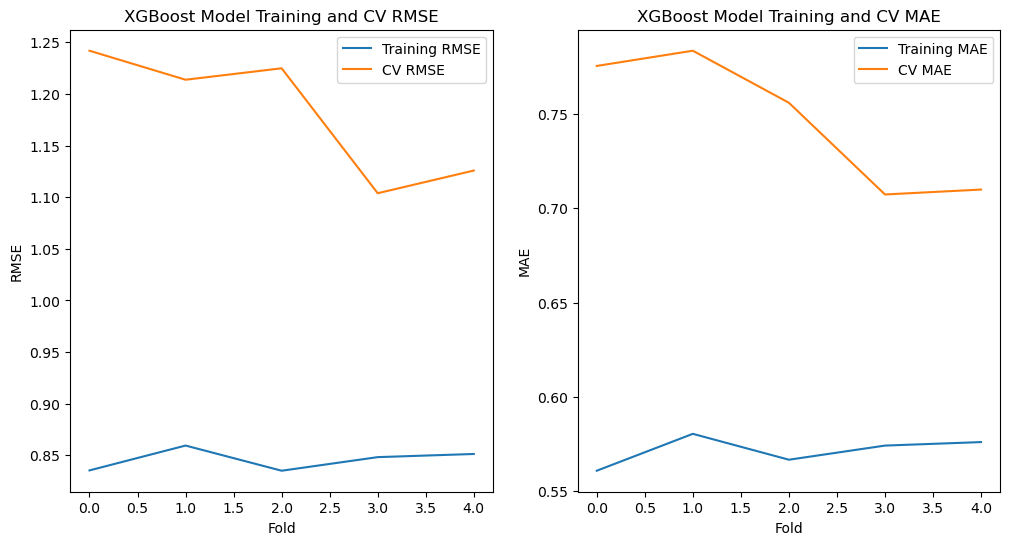

In [267]:
plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [268]:
evaluate_model_xgb(model, X_test, y_test)

XGBoost Model Performance
R2 Score:  0.12107160995220134
RMSE:  2.065314212677855
MAE:  1.6759175998999873


In [269]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

XGBoost Model Performance
R2 Score:  -0.4448301018525358
RMSE:  2.1009706186115555
MAE:  1.4176070155074767


In [270]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

XGBoost Model Performance
R2 Score:  -0.1968986510506161
RMSE:  3.264406406954252
MAE:  2.4252914234704464


In [271]:
predictions_eu, predictions_region = make_predictions(model, X_train_apply, X_test_apply)
pred_apply_eu_df, pred_apply_region_df = create_prediction_dataframes(predictions_eu, predictions_region)
df_eu_apply_target_updated, df_region_apply_target_updated = merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu_df, pred_apply_region_df)

In [272]:
print_disaggregation_metrics(y_train_apply, y_predict_pop_eu, df_eu_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 1.7493
MAE: 1.1643
R2: -0.0016

Model-based Disaggregation Metrics:
RMSE: 2.1010
MAE: 1.4176
R2: -0.4448


In [273]:
print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 2.4250
MAE: 2.0233
R2: 0.3395

Model-based Disaggregation Metrics:
RMSE: 3.2644
MAE: 2.4253
R2: -0.1969


In [274]:
df_eu_apply_target

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
10               EU                AT               AT1              AT13   
21               EU                AT               AT3              AT31   
35               EU                BE               BE1              BE10   
36               EU                BE               BE2              BE21   
97               EU                BG               BG4              BG41   
...             ...               ...               ...               ...   
1118             EU                RO               RO3              RO32   
1129             EU                SE               SE1              SE11   
1140             EU                SE               SE2              SE22   
1142             EU                SE               SE2              SE23   
1162             EU                SK               SK0              SK01   

     NUTS3_region_code  target_variable  index  predicted_value  
10               AT130           6.0014     10           3.8148  
21               AT312           1.3223     21           0.6094  
35               BE100           1.2416     35           3.5411  
36               BE211           1.8179     36           1.6067  
97               BG411          -0.3142     97           0.9453  
...                ...              ...    ...              ...  
1118             RO321          -0.2681   1118           1.7499  
1129             SE110           0.8498   1129           4.9011  
1140             SE224           0.1237   1140           1.6772  
1142             SE232           0.7000   1142           2.5350  
1162             SK010           0.8037   1162           1.0206  

[144 rows x 8 columns]

In [275]:
master_input_train_df

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0                EU                AT               AT1              AT13   
1                EU                AT               AT3              AT31   
2                EU                BE               BE1              BE10   
3                EU                BE               BE2              BE21   
4                EU                BG               BG4              BG41   
...             ...               ...               ...               ...   
2731             EU                RO               RO3              RO32   
2732             EU                SE               SE1              SE11   
2733             EU                SE               SE2              SE22   
2734             EU                SE               SE2              SE23   
2735             EU                SK               SK0              SK01   

     NUTS3_region_code  gross domestic product_va..._0  \
0                AT130                          4.5707   
1                AT312                          0.6359   
2                BE100                          3.0647   
3                BE211                          2.4687   
4                BG411                          0.6849   
...                ...                             ...   
2731             RO321                          2.0686   
2732             SE110                          6.6217   
2733             SE224                          2.0379   
2734             SE232                          3.2430   
2735             SK010                          0.6900   

      bicycle_stations_value   UMAP8  number of pixels with min..._3  UMAP19  \
0                     1.8653 -1.5913                         -0.5675  1.1443   
1                    -0.2173 -0.9127                          0.7529  0.3459   
2                     4.9238 -1.0565                          1.2810  0.7408   
3                     4.3995 -1.0850                          0.0749  0.4320   
4                    -0.3630 -0.9443                          0.0986  0.5697   
...                      ...     ...                             ...     ...   
2731                 -0.0426 -1.4176                         -0.5126  1.0279   
2732                  0.0739 -1.6407                          0.8333  1.0740   
2733                  1.3847 -1.5894                          0.5253  0.9988   
2734                  1.5741 -1.5430                          1.0626  0.9650   
2735                  2.1712 -0.6212                         -0.2532  0.3000   

      ...  UMAP3  railway_station_value  gross value added_value  \
0     ... 1.1148                 5.9055                   4.1733   
1     ... 0.6087                 1.0370                   1.0123   
2     ... 0.6817                 4.9863                   3.5757   
3     ... 0.5553                 1.2965                   1.9282   
4     ... 0.5950                 0.7292                   0.6395   
...   ...    ...                    ...                      ...   
2731  ... 0.9458                 1.6527                   2.0909   
2732  ... 1.2302                 3.1524                   6.5501   
2733  ... 1.2452                 1.2129                   2.0131   
2734  ... 1.2201                 2.5983                   3.2059   
2735  ... 0.3983                 0.6236                   0.6868   

      total employment_value  number of pixels with ind..._15  \
0                     3.5478                           0.2713   
1                     0.7978                           1.3779   
2                     2.1523                          -0.1758   
3                     1.2797                           1.1439   
4                     3.1787                           1.1445   
...                      ...                              ...   
2731                  3.6228                           0.3400   
2732                  4.6762                           1.7015   
2733                

# XGBoost Model Cluster 3

## 1st Iteration

In [276]:
print('The variable to disaggregate is: ', agg_var_to_disagg)

id_cluster = 2
cluster_name = cluster_names[id_cluster]
cluster_id = extract_cluster_id(cluster_name)
cluster_df = cluster_dfs[cluster_name]

# Check if cluster exists
cluster_df_region = cluster_df.loc[cluster_df['NUTS0_region_code'] == region, :].copy()

try:
    if cluster_df_region.empty:
        warnings.warn(f"The cluster doesn't contain the region '{region}'.")
        # Stop the runtime (you can also remove this line if you want the code to continue executing)
        raise SystemExit("The cluster doesn't contain the specified region.")
except SystemExit as e:
    print(e)

# Create a new DataFrame with the first five columns
first_five_columns_df = cluster_df.iloc[:, :5].copy()

# Drop the first five columns and the 'Cluster' column from cluster_df
cluster_df = cluster_df.drop(columns=['Cluster']).iloc[:, 5:]

# Create a list of feature names from the modified DataFrame
feature_names_cluster_df = []
for col in cluster_df.columns:
    feature_names_cluster_df.append(col)

The variable to disaggregate is:  charging_stations_value


IndexError: list index out of range

In [ ]:
master_input_df, master_label_df, master_input_train_df, master_label_train_df, master_input_test_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu = create_master_dataframe_based_on_population_weights_v2(cluster_df, first_five_columns_df, feature_names_cluster_df, agg_var_to_disagg, region)

X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, y_predict_pop_eu = prepare_data_for_cluster(cluster_id, master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

In [ ]:
# Define model parameters
model_params = {
    "objective": "reg:squarederror",
    "n_estimators": 280,
    "max_depth": 3,
    'min_child_weight': 1.660916224600812,
    "learning_rate": 0.09,
    "subsample": 0.96,
    "colsample_bytree": 0.49,
    'gamma': 0.8570781361610906,
    # "colsample_bylevel": 0.8,
    # "colsample_bynode": 0.8,
    "reg_alpha": 0.9,
    "reg_lambda": 0.82,
    # "scale_pos_weight": 1,
    # "max_delta_step": 0,
    # "booster": "gbtree",
    # "tree_method": "auto",
    # "grow_policy": "depthwise",
    # "max_leaves": 0,
    # "max_bin": 256,
    # "min_split_loss": 0,
    "eval_metric": ["rmse", "mae"],
}

# Define a list of random states
random_states = [52,
                #  123,
                #  456,
                #  789
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

In [ ]:
plot_cv_error(model)

In [ ]:
plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [ ]:
evaluate_model_xgb(model, X_test, y_test)

In [ ]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

In [ ]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

In [ ]:
predictions_eu, predictions_region = make_predictions(model, X_train_apply, X_test_apply)
pred_apply_eu_df, pred_apply_region_df = create_prediction_dataframes(predictions_eu, predictions_region)
df_eu_apply_target_updated, df_region_apply_target_updated = merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu_df, pred_apply_region_df)

In [ ]:
print_disaggregation_metrics(y_train_apply, y_predict_pop_eu, df_eu_apply_target_updated)

In [ ]:
print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target_updated)

In [ ]:
df_eu_apply_target

In [ ]:
master_input_train_df

## 2nd Iteration

In [ ]:
print('The variable to disaggregate is: ', agg_var_to_disagg)

id_cluster = 2
cluster_name = cluster_names[id_cluster]
cluster_id = extract_cluster_id(cluster_name)
cluster_df = cluster_dfs[cluster_name]

# Create a new DataFrame with the first five columns
first_five_columns_df = cluster_df.iloc[:, :5].copy()

# Drop the first five columns and the 'Cluster' column from cluster_df
cluster_df = cluster_df.drop(columns=['Cluster']).iloc[:, 5:]

# Create a list of feature names from the modified DataFrame
feature_names_cluster_df = []
for col in cluster_df.columns:
    feature_names_cluster_df.append(col)

In [ ]:
master_input_df, master_label_df, master_input_train_df, master_label_train_df, master_input_test_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu = create_master_dataframe_based_on_population_weights_v2(cluster_df, first_five_columns_df, feature_names_cluster_df, agg_var_to_disagg, region, predicted_values=df_eu_apply_target['predicted_value'])

X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, y_predict_pop_eu = prepare_data_for_cluster(cluster_id, master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

In [ ]:
master_input_train_df

In [ ]:
# Define model parameters
model_params = {
    "objective": "reg:squarederror",
    "n_estimators": 280,
    "max_depth": 3,
    'min_child_weight': 1.660916224600812,
    "learning_rate": 0.09,
    "subsample": 0.96,
    "colsample_bytree": 0.49,
    'gamma': 0.8570781361610906,
    # "colsample_bylevel": 0.8,
    # "colsample_bynode": 0.8,
    "reg_alpha": 0.9,
    "reg_lambda": 0.82,
    # "scale_pos_weight": 1,
    # "max_delta_step": 0,
    # "booster": "gbtree",
    # "tree_method": "auto",
    # "grow_policy": "depthwise",
    # "max_leaves": 0,
    # "max_bin": 256,
    # "min_split_loss": 0,
    "eval_metric": ["rmse", "mae"],
}

# Define a list of random states
random_states = [53,
                #  123,
                #  456,
                #  789
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

In [ ]:
plot_cv_error(model)

In [ ]:
plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [ ]:
evaluate_model_xgb(model, X_test, y_test)

In [ ]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

In [ ]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

In [ ]:
predictions_eu, predictions_region = make_predictions(model, X_train_apply, X_test_apply)
pred_apply_eu_df, pred_apply_region_df = create_prediction_dataframes(predictions_eu, predictions_region)
df_eu_apply_target_updated, df_region_apply_target_updated = merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu_df, pred_apply_region_df)

In [ ]:
print_disaggregation_metrics(y_train_apply, y_predict_pop_eu, df_eu_apply_target_updated)

In [ ]:
print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target_updated)

In [ ]:
df_eu_apply_target

In [ ]:
master_input_train_df

## 3rd Iteration

In [ ]:
print('The variable to disaggregate is: ', agg_var_to_disagg)

id_cluster = 2
cluster_name = cluster_names[id_cluster]
cluster_id = extract_cluster_id(cluster_name)
cluster_df = cluster_dfs[cluster_name]

# Create a new DataFrame with the first five columns
first_five_columns_df = cluster_df.iloc[:, :5].copy()

# Drop the first five columns and the 'Cluster' column from cluster_df
cluster_df = cluster_df.drop(columns=['Cluster']).iloc[:, 5:]

# Create a list of feature names from the modified DataFrame
feature_names_cluster_df = []
for col in cluster_df.columns:
    feature_names_cluster_df.append(col)

In [ ]:
master_input_df, master_label_df, master_input_train_df, master_label_train_df, master_input_test_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu = create_master_dataframe_based_on_population_weights_v2(cluster_df, first_five_columns_df, feature_names_cluster_df, agg_var_to_disagg, region, predicted_values=df_eu_apply_target['predicted_value'])

X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, y_predict_pop_eu = prepare_data_for_cluster(cluster_id, master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

In [ ]:
master_input_train_df

In [ ]:
# Define model parameters
model_params = {
    "objective": "reg:squarederror",
    "n_estimators": 280,
    "max_depth": 3,
    'min_child_weight': 1.660916224600812,
    "learning_rate": 0.09,
    "subsample": 0.96,
    "colsample_bytree": 0.49,
    'gamma': 0.8570781361610906,
    # "colsample_bylevel": 0.8,
    # "colsample_bynode": 0.8,
    "reg_alpha": 0.9,
    "reg_lambda": 0.82,
    # "scale_pos_weight": 1,
    # "max_delta_step": 0,
    # "booster": "gbtree",
    # "tree_method": "auto",
    # "grow_policy": "depthwise",
    # "max_leaves": 0,
    # "max_bin": 256,
    # "min_split_loss": 0,
    "eval_metric": ["rmse", "mae"],
}

# Define a list of random states
random_states = [54,
                #  123,
                #  456,
                #  789
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

In [ ]:
plot_cv_error(model)

In [ ]:
plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [ ]:
evaluate_model_xgb(model, X_test, y_test)

In [ ]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

In [ ]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

In [ ]:
predictions_eu, predictions_region = make_predictions(model, X_train_apply, X_test_apply)
pred_apply_eu_df, pred_apply_region_df = create_prediction_dataframes(predictions_eu, predictions_region)
df_eu_apply_target_updated, df_region_apply_target_updated = merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu_df, pred_apply_region_df)

In [ ]:
print_disaggregation_metrics(y_train_apply, y_predict_pop_eu, df_eu_apply_target_updated)

In [ ]:
print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target_updated)

In [ ]:
df_eu_apply_targets

In [ ]:
master_input_train_df

## 4rd Iteration

In [ ]:
print('The variable to disaggregate is: ', agg_var_to_disagg)

id_cluster = 2
cluster_name = cluster_names[id_cluster]
cluster_id = extract_cluster_id(cluster_name)
cluster_df = cluster_dfs[cluster_name]

# Create a new DataFrame with the first five columns
first_five_columns_df = cluster_df.iloc[:, :5].copy()

# Drop the first five columns and the 'Cluster' column from cluster_df
cluster_df = cluster_df.drop(columns=['Cluster']).iloc[:, 5:]

# Create a list of feature names from the modified DataFrame
feature_names_cluster_df = []
for col in cluster_df.columns:
    feature_names_cluster_df.append(col)

In [ ]:
master_input_df, master_label_df, master_input_train_df, master_label_train_df, master_input_test_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu = create_master_dataframe_based_on_population_weights_v2(cluster_df, first_five_columns_df, feature_names_cluster_df, agg_var_to_disagg, region, predicted_values=df_eu_apply_target['predicted_value'])

X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, y_predict_pop_eu = prepare_data_for_cluster(cluster_id, master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

In [ ]:
master_input_train_df

In [ ]:
# Define model parameters
model_params = {
    "objective": "reg:squarederror",
    "n_estimators": 280,
    "max_depth": 3,
    'min_child_weight': 1.660916224600812,
    "learning_rate": 0.09,
    "subsample": 0.96,
    "colsample_bytree": 0.49,
    'gamma': 0.8570781361610906,
    # "colsample_bylevel": 0.8,
    # "colsample_bynode": 0.8,
    "reg_alpha": 0.9,
    "reg_lambda": 0.82,
    # "scale_pos_weight": 1,
    # "max_delta_step": 0,
    # "booster": "gbtree",
    # "tree_method": "auto",
    # "grow_policy": "depthwise",
    # "max_leaves": 0,
    # "max_bin": 256,
    # "min_split_loss": 0,
    "eval_metric": ["rmse", "mae"],
}

# Define a list of random states
random_states = [55,
                #  123,
                #  456,
                #  789
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

In [ ]:
plot_cv_error(model)

In [ ]:
plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [ ]:
evaluate_model_xgb(model, X_test, y_test)

In [ ]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

In [ ]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

In [ ]:
predictions_eu, predictions_region = make_predictions(model, X_train_apply, X_test_apply)
pred_apply_eu_df, pred_apply_region_df = create_prediction_dataframes(predictions_eu, predictions_region)
df_eu_apply_target_updated, df_region_apply_target_updated = merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu_df, pred_apply_region_df)

In [ ]:
print_disaggregation_metrics(y_train_apply, y_predict_pop_eu, df_eu_apply_target_updated)

In [ ]:
print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target_updated)

In [ ]:
df_eu_apply_target

In [ ]:
master_input_train_df

## 5th Iteration

In [ ]:
print('The variable to disaggregate is: ', agg_var_to_disagg)

id_cluster = 2
cluster_name = cluster_names[id_cluster]
cluster_id = extract_cluster_id(cluster_name)
cluster_df = cluster_dfs[cluster_name]

# Create a new DataFrame with the first five columns
first_five_columns_df = cluster_df.iloc[:, :5].copy()

# Drop the first five columns and the 'Cluster' column from cluster_df
cluster_df = cluster_df.drop(columns=['Cluster']).iloc[:, 5:]

# Create a list of feature names from the modified DataFrame
feature_names_cluster_df = []
for col in cluster_df.columns:
    feature_names_cluster_df.append(col)

In [ ]:
master_input_df, master_label_df, master_input_train_df, master_label_train_df, master_input_test_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu = create_master_dataframe_based_on_population_weights_v2(cluster_df, first_five_columns_df, feature_names_cluster_df, agg_var_to_disagg, region, predicted_values=df_eu_apply_target['predicted_value'])

X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, y_predict_pop_eu = prepare_data_for_cluster(cluster_id, master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

In [ ]:
master_input_train_df

In [ ]:
# Define model parameters
model_params = {
    "objective": "reg:squarederror",
    "n_estimators": 280,
    "max_depth": 3,
    'min_child_weight': 1.660916224600812,
    "learning_rate": 0.09,
    "subsample": 0.96,
    "colsample_bytree": 0.49,
    'gamma': 0.8570781361610906,
    # "colsample_bylevel": 0.8,
    # "colsample_bynode": 0.8,
    "reg_alpha": 0.9,
    "reg_lambda": 0.82,
    # "scale_pos_weight": 1,
    # "max_delta_step": 0,
    # "booster": "gbtree",
    # "tree_method": "auto",
    # "grow_policy": "depthwise",
    # "max_leaves": 0,
    # "max_bin": 256,
    # "min_split_loss": 0,
    "eval_metric": ["rmse", "mae"],
}

# Define a list of random states
random_states = [56,
                #  123,
                #  456,
                #  789
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

In [ ]:
plot_cv_error(model)

In [ ]:
plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [ ]:
evaluate_model_xgb(model, X_test, y_test)

In [ ]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

In [ ]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

In [ ]:
predictions_eu, predictions_region = make_predictions(model, X_train_apply, X_test_apply)
pred_apply_eu_df, pred_apply_region_df = create_prediction_dataframes(predictions_eu, predictions_region)
df_eu_apply_target_updated, df_region_apply_target_updated = merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu_df, pred_apply_region_df)

In [ ]:
print_disaggregation_metrics(y_train_apply, y_predict_pop_eu, df_eu_apply_target_updated)

In [ ]:
print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target_updated)

In [ ]:
df_eu_apply_target

In [ ]:
master_input_train_df